In [1]:
import os
import numpy as np
import pandas as pd
# from gotx import *#as gt

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# import pyspark.pandas as ps
# from pyspark.sql import SparkSession

In [ ]:
# path='/data/input/postransplant_cristian_colab/microarrays/'
path='/mnt/d/rna_editing/'

In [ ]:
# ps_df = ps.read_csv('/mnt/e/cristian_mice_rna_editing/reditools_output/full_bam/X36-ready.bam_RES.txt')

In [ ]:
ens2sym = pd.read_csv(path+'gene_id2gene_nameWgene_lenght.csv')
ens2sym = dict(zip(ens2sym.Gene_ID, ens2sym.Gene_name))

# vst = pd.read_csv(path+'vst_pc.csv', index_col=0).T
meta = pd.read_csv(path+'metadata.txt', index_col=0)

In [ ]:
meta

In [5]:
# fig, ax = plt.subplots(ncols=1, figsize=(5,5))

# plot.pca(vst, meta, ax=ax)



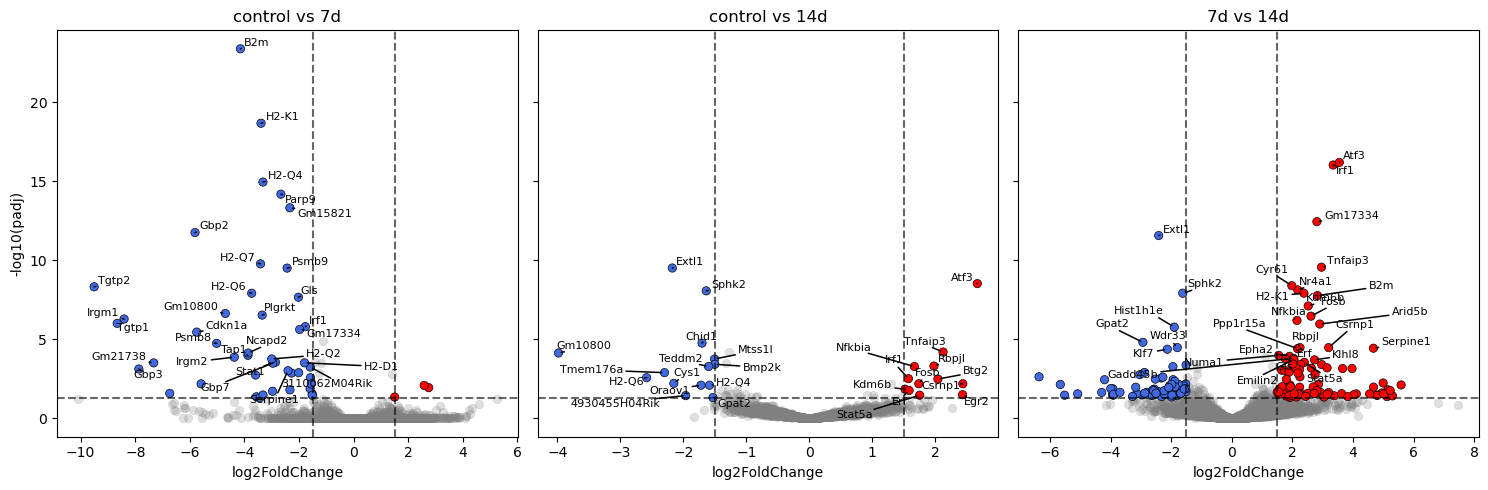

In [4]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5), sharey=True)

files = ['res_c7_pc.csv','res_c14_pc.csv', 'res_714_pc.csv']
titles = ['control vs 7d', 'control vs 14d', '7d vs 14d']
i=0
for t,f in zip(titles,files):
    df = pd.read_csv(path+f, index_col=0)
    df.index = df.index.map(ens2sym)

    plot.volcanoplot(df, ax=ax[i], use_adjusttext=True, pv_lim=0.05)
    ax[i].set_title(t)
    ax[i].get_legend().remove()

    i+=1



fig.tight_layout()
# fig.savefig('volcanos.png')

In [15]:
files = ['res_c7_pc.csv','res_c14_pc.csv', 'res_714_pc.csv']

logFC_col = 'log2FoldChange'
pv_col = 'padj'
logFC_lim = 2
pv_lim = 0.1

genes = []

for f in files:
    df = pd.read_csv(path+f)

    df['-log10(padj)'] = -np.log10(df[pv_col])
    df['log2FoldChange_abs'] = df[logFC_col].abs()
    condlist = [(df[logFC_col] >= logFC_lim) & (df[pv_col] <= pv_lim), (df[logFC_col] <= -logFC_lim) & (df[pv_col] <= pv_lim)]
    choicelist = ['Upregulated','Downregulated']

    df['regulation'] = np.select(condlist, choicelist, default='Not-significant')

    genes.extend(df[df.regulation.isin(['Upregulated','Downregulated'])]['Unnamed: 0'].map(ens2sym).values.tolist())

In [8]:
print(set(genes))

{'Casq1', 'Gbp3', 'Tspyl5', 'Ccdc183', 'Gm19684', 'Tmem255b', 'Prkab2', 'Enc1', 'Fosb', 'Parp9', 'Tgm2', 'Klf7', 'Acyp2', 'Arc', 'H2-Q4', 'Nfkbia', 'Polr3e', 'Fmod', 'Dnajb5', 'Kdm6b', 'Pqlc2', 'Nr4a1', 'Sdhaf1', 'Nup188', 'Ier5', 'Tmem176a', 'BC034090', 'Gm17334', 'Ncapd2', 'Atf3', 'Gale', 'Crygn', 'Gbp2', 'Klhl8', 'Fbxo41', 'Ppp1r15a', 'Emilin2', 'Slc39a11', 'Top3a', 'Ypel4', 'Stat1', 'Stat5a', 'Aim1', 'Irf1', 'Dusp10', 'Psmd5', 'H2-Q2', 'Gm8909', 'Erf', 'Vma21', 'Pex16', 'Gbp8', 'Gls', 'Sec22c', 'Gadd45b', 'H2-Q1', 'Grip2', 'Gbp10', 'Gm10800', 'Tars2', 'Nckap5l', 'Thbs1', 'Ube2l6', 'Treh', 'Wars2', 'Hist1h4d', 'Dennd4b', 'Il10', 'Uba52', 'Litaf', 'Kctd9', 'Egr2', 'Gcnt7', 'Gpr22', 'H2-Q7', 'Extl1', 'Cecr2', 'Cdkn1a', 'Fam83c', 'Rgma', 'Unc50', 'Sipa1', 'Slit1', 'Map3k4', 'H2-Q6', 'Mapkbp1', 'Rlbp1', 'Lrrc56', 'Podnl1', 'Cbr4', 'Dgcr6', 'Elf5', 'Ppm1e', 'AI413582', 'Kcnip4', 'Hist2h2ab', 'Psmb8', 'Kalrn', 'Tnfaip3', 'Ecm1', 'Jun', 'Afg3l2', 'Tle3', 'Cd274', 'Asic3', 'Zfp750', 'Setd4'

# REDITOOLS analysis

In [2]:
import os
import pandas as pd
import numpy as np
import anndata as ad
import seaborn as sns
import pingouin as pg
import scikit_posthocs as sp
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
# import scikit_posthocs as sp

## split files

In [1704]:
cat /mnt/e/cristian_mice_rna_editing/reditools_output/full_bam/X838-ready.bam_RES.txt | wc -l

207486348


In [1705]:
t1=time.time()
with open('/mnt/e/cristian_mice_rna_editing/reditools_output/full_bam/X838-ready.bam_RES.txt', 'r') as fp:
    lines = sum(1 for line in fp)
    print('Total Number of lines:', lines)
print('time: ', time.time()-t1, (time.time()-t1)/60, 'min')

Total Number of lines: 207486348
time:  1074.5996787548065 17.90999465783437 min


In [1702]:
169216534/155248

1089.9756132124085

In [15]:
df_redi = pd.read_csv('/mnt/d/reference_files/mus_musculus/rediportal/TABLE1_mm10.txt.gz', sep='\t')

In [16]:
# df_redi[df_redi['AAChange.refGene']=='Rnf14']

In [17]:
df_redi[(df_redi.Region=='chr6') & (df_redi.dbsnp!='-')].Position.values

array([ 28023256,  45103612,  45440973,  63634014,  64111504,  92447468,
       105953378, 110701134, 112608439, 115554870, 135022358, 149025732])

In [8]:
pathREDI = '/mnt/e/cristian_mice_rna_editing/reditools_output/per_gene/'
bams = list({f.split('_')[0] for f in os.listdir(pathREDI) })
genes = list({f.split('_')[1] for f in os.listdir(pathREDI) })

In [9]:
bams

['X36-ready.bam',
 'X1247-ready.bam',
 'X838-ready.bam',
 'X582-ready.bam',
 'X679-ready.bam',
 'X839-ready.bam',
 'X868-ready.bam',
 'X1249-ready.bam',
 'X840-ready.bam']

In [11]:
# genes

In [36]:
# pd.read_csv( os.path.join(pathREDI,'X838-ready.bam'+'_'+'Podnl1'+'_RES.txt'), sep='\t' )

In [51]:
pd.read_csv( os.path.join(pathREDI,b+'_'+g+'_RES.txt'), sep='\t' )

Empty DataFrame
Columns: [Region, Position, Reference, Strand, Coverage-q30, MeanQ, BaseCount[A,C,G,T], AllSubs, Frequency, gCoverage-q30, gMeanQ, gBaseCount[A,C,G,T], gAllSubs, gFrequency]
Index: []

In [126]:
aux

{'1700008O03Rik': [nan, nan, nan, nan, nan, nan, nan, nan, nan]}

In [5]:
# aux_df

In [125]:
pd.concat(aux_df[k], axis=1).T

Position  44372255  44360274  44385502
838            NaN       NaN       NaN
36            18.0       NaN       NaN
868           28.0      19.0      15.0
840            NaN       NaN       NaN
679           18.0       NaN       NaN
839            NaN       NaN       NaN
582           13.0       NaN       NaN
1249          18.0       NaN       NaN
1247           NaN       NaN       NaN

## ANOVA + Tukey Analysis

In [791]:
meta = pd.read_csv('/mnt/d/rna_editing/metadata.txt', dtype='str').set_index('sample')
stat_res = []
for g in genes:#[:30]: 
# g = '1700008O03Rik'#'Ralgps1'#'1700034I23Rik'#
    # For each gene one need to run all this again
    df_list_a = []
    df_list_g = []
    for b in bams:
        df = pd.read_csv( os.path.join(pathREDI,b+'_'+g+'_RES.txt'), sep='\t' )
        if df.empty:
            df_list_a.append( pd.DataFrame({'Position':[-1], b:[np.nan]}).set_index('Position') )
            df_list_g.append( pd.DataFrame({'Position':[-1], b:[np.nan]}).set_index('Position') )
        else:
            df = df[df['Coverage-q30']>=10]
            df = df[df.Reference.isin(['A','T'])]
            df = df[(df.AllSubs.str.contains('AG')) | (df.AllSubs.str.contains('CT'))]
            if df.empty:
                df_list_a.append( pd.DataFrame({'Position':[-1], b:[np.nan]}).set_index('Position') )
                df_list_g.append( pd.DataFrame({'Position':[-1], b:[np.nan]}).set_index('Position') )
            else:
                df[['count_A','count_C','count_G','count_T']] = df['BaseCount[A,C,G,T]'].str.replace('[','',regex=False).str.replace(']','', regex=False).str.split(',',expand=True).apply(pd.to_numeric)

                df[b] = np.where((df['Reference']=='A'), df.count_A, df.count_T)            
                df_list_a.append(df[['Position',b]].set_index('Position'))

                df[b] = np.where((df['Reference']=='A'), df.count_G, df.count_C)
                df_list_g.append(df[['Position',b]].set_index('Position'))

    # Analysis by gene
    df_a = pd.concat(df_list_a, axis=1)
    df_g = pd.concat(df_list_g, axis=1)

    if (-1 in df_a.index): 
        df_a.drop(-1, axis=0, inplace=True)
        df_g.drop(-1, axis=0, inplace=True)

    if df_a.empty:
        print('gene', g , 'has not filterd edited site.')
    else:
        df = pd.DataFrame(100*df_g.values / (df_a.values+df_g.values), columns=bams, index=df_a.index).T
        df = df.merge(meta, left_index=True, right_index=True)

        array_filter = np.ones(df.shape[1]-1).astype(bool) # minus 1 to exclude type column
        # nan filter
        for cond in df.type.unique():
            idx = np.where(df.type==cond)[0]
            # nan filter
            array_filter *= (df.iloc[idx, :-1].isna().sum(axis=0)<=1).values
            # zero filter
            array_filter *= ((df.iloc[idx, :-1]==0).sum(axis=0)<=1).values
            # hundred filter
            array_filter *= ((df.iloc[idx, :-1]==100).sum(axis=0)<=1).values
        # var filter
        array_filter *= (df.iloc[:, :-1].var()>=.01).values # between every samples to see if there is any variance to check DE. Should I test just for editing levelgreather than 90%

        array_filter = np.append(array_filter, True) # insert True for type column

        # Test for any remains positions
        if df.iloc[:, array_filter].drop('type', axis=1).empty:
            print('after filtering process gene', g , 'has not edited site.')
        else:
            df = df.iloc[:, array_filter]
            # Anova e tukey analysis
            res = []            
            cols_tukey = list(itertools.combinations(df.type.unique(), 2))
            for c in df.columns[:-1]:
                aux_aov = pg.anova(dv=c, between='type', data=df, detailed=False)

                if not aux_aov[aux_aov['p-unc']<=0.1].empty:
                    aux_tukey = sp.posthoc_tukey(df, val_col=c, group_col='type')

                    if (aux_tukey<0.1).values.sum() > 0 :
                        res.append(pg.anova(dv=c, between='type', data=df, detailed=False))#.to_csv('A2I_anova.csv')
                        res[-1]['Position'] = c

                        aux_tukey = aux_tukey.loc[df.type.unique(), df.type.unique()] # just to confirm that the order will be always the same
                        np.fill_diagonal(aux_tukey.values, 0) # to transform to squareform, the diagonal must be zero
                        res[-1].loc[:,cols_tukey] = squareform(aux_tukey)
            if res:
                res = pd.concat(res).set_index('Position')
                stat_res.append(res.merge(df[res.index].T, left_index=True, right_index=True))
                stat_res[-1]['gene'] = g

after filtering process gene 1700008O03Rik has not edited site.
after filtering process gene Dennd4b has not edited site.
after filtering process gene Gadd45b has not edited site.
gene Gm10065 has not filterd edited site.
after filtering process gene Sipa1 has not edited site.
after filtering process gene Fam131a has not edited site.
after filtering process gene Sec22c has not edited site.
after filtering process gene Treh has not edited site.
gene Slit1 has not filterd edited site.
after filtering process gene Fmod has not edited site.
after filtering process gene Csf1 has not edited site.
after filtering process gene Slc23a1 has not edited site.
after filtering process gene Gm10800 has not edited site.
after filtering process gene Brpf3 has not edited site.
after filtering process gene Ecm1 has not edited site.
after filtering process gene Setd4 has not edited site.
after filtering process gene Dnajb5 has not edited site.
gene Rlbp1 has not filterd edited site.
after filtering proces

In [792]:
df_res = pd.concat(stat_res).sort_values('p-unc')
df_res['var'] = df_res[[c for c in df_res if 'bam' in c]].var(axis=1)
df_res = df_res.sort_values('var', ascending=False)

In [793]:
df_res.sort_values('var', ascending=False).to_csv('reditools_filtered_aov_tukey.csv')

In [738]:
# df_anly = df_res[df_res.gene=='Irf1'][[c for c in df_res if 'bam' in c]].T.merge(meta, left_index=True, right_index=True )
# df_anly = df_anly.melt(id_vars='type', ignore_index=False)
# df_anly

[Text(0, 0, '33996446'), Text(1, 0, '33996630')]

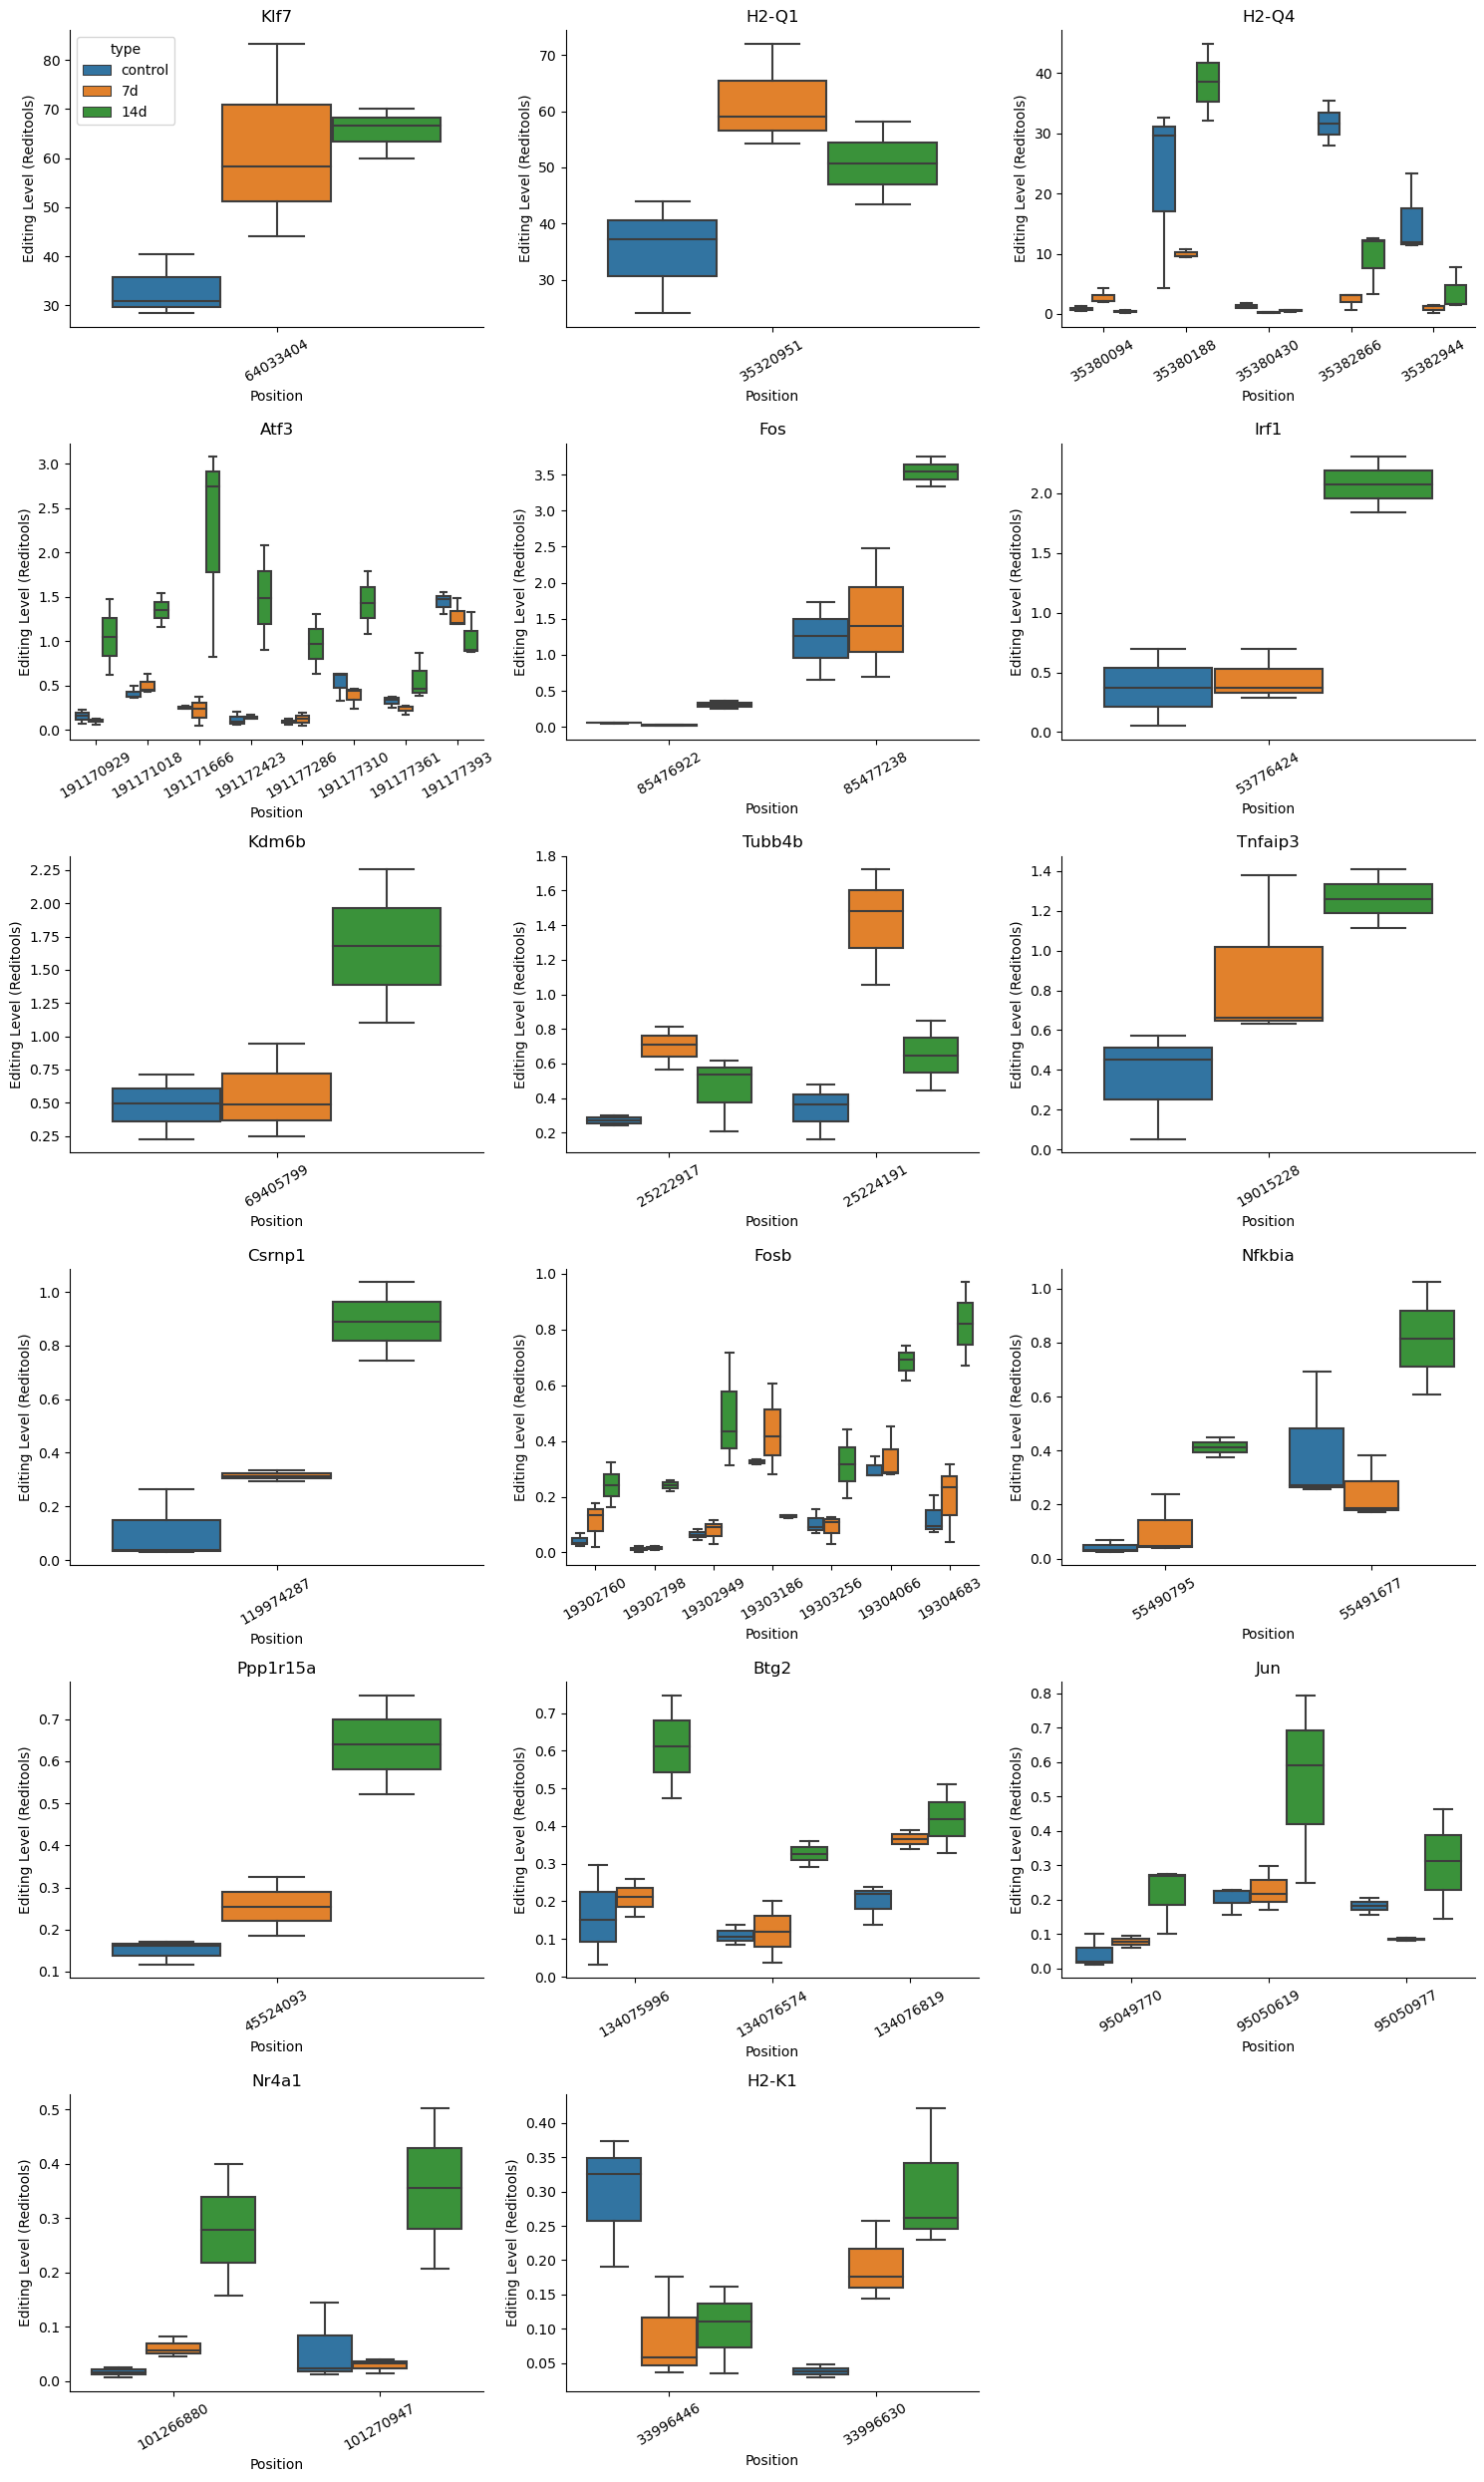

In [794]:
ncols = 3
nrows = int(np.ceil(df_res.gene.unique().shape[0]/ncols))

fig = plt.figure(figsize=(15,25))

for i,g in enumerate(df_res.gene.unique()):
    ax = fig.add_subplot(nrows, ncols, i+1)
    df_anly = df_res[df_res.gene==g][[c for c in df_res if 'bam' in c]].T.merge(meta, left_index=True, right_index=True )
    df_anly = df_anly.melt(id_vars='type')

    sns.boxplot(x='variable', y='value',hue='type',hue_order=['control', '7d', '14d'],data=df_anly, ax=ax)
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)
    ax.set_xlabel('Position')
    ax.set_ylabel('Editing Level (Reditools)')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(g)
    
    if i > 0:
        ax.legend().set_visible(False)
fig.tight_layout()
fig.savefig('reditools_filtered_aov_tukey.pdf', format='pdf', dpi=300)

## FISHER -TEST
Must be at least 5 of frequencies in each cell

In [2]:
0.105+12.214+3.696+6.704+7.748+1.350

31.817000000000004

In [4]:
meta = pd.read_csv('/mnt/d/rna_editing/metadata.txt', dtype='str').set_index('sample')
meta

type
sample                  
X582-ready.bam   control
X679-ready.bam   control
X868-ready.bam   control
X1247-ready.bam       7d
X1249-ready.bam       7d
X36-ready.bam         7d
X838-ready.bam       14d
X839-ready.bam       14d
X840-ready.bam       14d

In [1584]:
import time
meta = pd.read_csv('/mnt/d/rna_editing/metadata.txt', dtype='str').set_index('sample')
stat_res = []
# for g in genes:#[:30]: 
g = 'H2-Q4'#'1700008O03Rik'#'Ralgps1'#'1700034I23Rik'#
# For each gene one need to run all this again
df_list_a = []
df_list_g = []
for b in bams:
    df = pd.read_csv( os.path.join(pathREDI,b+'_'+g+'_RES.txt'), sep='\t' )
    if df.empty:
        df_list_a.append( pd.DataFrame({'Position':[-1], b:[np.nan]}).set_index('Position') )
        df_list_g.append( pd.DataFrame({'Position':[-1], b:[np.nan]}).set_index('Position') )
    else:
        df = df[df['Coverage-q30']>=10]
        df = df[df.Reference.isin(['A','T'])]
        df = df[(df.AllSubs.str.contains('AG')) | (df.AllSubs.str.contains('CT'))]
        if df.empty:
            df_list_a.append( pd.DataFrame({'Position':[-1], b:[np.nan]}).set_index('Position') )
            df_list_g.append( pd.DataFrame({'Position':[-1], b:[np.nan]}).set_index('Position') )
        else:
            df[['count_A','count_C','count_G','count_T']] = df['BaseCount[A,C,G,T]'].str.replace('[','',regex=False).str.replace(']','', regex=False).str.split(',',expand=True).apply(pd.to_numeric)

            df[b] = np.where((df['Reference']=='A'), df.count_A, df.count_T)            
            df_list_a.append(df[['Position',b]].set_index('Position'))

            df[b] = np.where((df['Reference']=='A'), df.count_G, df.count_C)
            df_list_g.append(df[['Position',b]].set_index('Position'))

# Analysis by gene
df_a = pd.concat(df_list_a, axis=1)
df_g = pd.concat(df_list_g, axis=1)

if (-1 in df_a.index): 
    df_a.drop(-1, axis=0, inplace=True)
    df_g.drop(-1, axis=0, inplace=True)

if df_a.empty:
    print('gene', g , 'has not filterd edited site.')
else:
    df = pd.DataFrame(100*df_g.values / (df_a.values+df_g.values), columns=bams, index=df_a.index).T
    df = df.merge(meta, left_index=True, right_index=True)    
    
    array_filter = df_teste.iloc[:,range(df_teste.shape[1]-1)].columns # minus 1 to exclude type column
    # array_filter = np.ones(df.shape[1]-1).astype(bool) # minus 1 to exclude type column
    # nan filter
    t1=time.time()
    for cond in df.type.unique():                        
        # idx = np.where(df.type==cond)[0]
        # nan filter
        array_filter = array_filter[ np.where(df.loc[df.type==cond, array_filter ].isna().sum(axis=0)<=1)[0]]
        # array_filter *= (df.iloc[idx, :-1].isna().sum(axis=0)<=1).values
        # zero filter
        array_filter = array_filter[ np.where((df.loc[df.type==cond, array_filter ]==0).sum(axis=0)<=1)[0]]
        # array_filter *= ((df.iloc[idx, :-1]==0).sum(axis=0)<=1).values
        # hundred filter
        array_filter = array_filter[ np.where((df.loc[df.type==cond, array_filter ]==100).sum(axis=0)<=1)[0]]
        # array_filter *= ((df.iloc[idx, :-1]==100).sum(axis=0)<=1).values        
    # var filter
    array_filter = array_filter[ np.where((df.loc[df.type==cond, array_filter ].var()>=.01))[0]]
    # array_filter *= (df.iloc[:, :-1].var()>=.01).values # between every samples to see if there is any variance to check DE       
    
    # Fisher/chi2 inner cond to pool counts
    # As the filter of quality control in 10 reads with phred >30, we can use 
    # New loop until get new ideia to deal with it
    # for cond in df.type.unique():
#         idx = np.where(df.type==cond)[0]

    # array_filter = np.append(array_filter, True) # insert True for type column
    array_filter = array_filter.tolist()
    array_filter.append('type')
    t2=time.time()
    print(t2-t1)
    # Test for any remains positions
    if df.loc[:, array_filter].drop('type', axis=1).empty:
        print('after filtering process gene', g , 'has not edited site.')
    else:
        df = df.loc[:, array_filter]
        # To calculate contigency table
        # df_a = df_a.T.merge(meta, left_index=True, right_index=True)
        # df_g = df_g.T.merge(meta, left_index=True, right_index=True)                
        df_a = df_a.T.loc[:,array_filter[:-1]].merge(meta, left_index=True, right_index=True)
        df_g = df_g.T.loc[:,array_filter[:-1]].merge(meta, left_index=True, right_index=True)
        # chi2_contigency and fisher/chi2
        res = []
        for c in array_filter[:-1]:
            # dropna() or fillna(0)? should let both options
            # t = np.array([df_a.loc[df_teste.type==cond, c].dropna().values, #.loc[:,12]
            #               df_g.loc[df_teste.type==cond, c].dropna().values]) #.loc[:,12]
            if chi2_contingency(t).pvalue > 0.05:
                pass
#         cols_tukey = list(itertools.combinations(df.type.unique(), 2))
#         for c in df.columns[:-1]:
#             aux_aov = pg.anova(dv=c, between='type', data=df, detailed=False)

#             if not aux_aov[aux_aov['p-unc']<=0.1].empty:
#                 aux_tukey = sp.posthoc_tukey(df, val_col=c, group_col='type')

#                 if (aux_tukey<0.1).values.sum() > 0 :
#                     res.append(pg.anova(dv=c, between='type', data=df, detailed=False))#.to_csv('A2I_anova.csv')
#                     res[-1]['Position'] = c

#                     aux_tukey = aux_tukey.loc[df.type.unique(), df.type.unique()] # just to confirm that the order will be always the same
#                     np.fill_diagonal(aux_tukey.values, 0) # to transform to squareform, the diagonal must be zero
#                     res[-1].loc[:,cols_tukey] = squareform(aux_tukey)
#         if res:
#             res = pd.concat(res).set_index('Position')
#             stat_res.append(res.merge(df[res.index].T, left_index=True, right_index=True))
#             stat_res[-1]['gene'] = g

0.004714250564575195


In [1587]:
df_a

35380049  35380091  35380094  35380131  35380132  35380149  \
X868-ready.bam      191.0     158.0     385.0     311.0     367.0     240.0   
X36-ready.bam      1846.0    1506.0    2037.0    1923.0    1971.0    1904.0   
X679-ready.bam      444.0     433.0     818.0     671.0     690.0     569.0   
X582-ready.bam      507.0     531.0     930.0     718.0     779.0     613.0   
X1247-ready.bam    2369.0    2276.0    3101.0    3178.0       NaN       NaN   
X1249-ready.bam    4171.0    4033.0    5322.0    5215.0    5443.0    4839.0   
X838-ready.bam      232.0     232.0     448.0     321.0       NaN     282.0   
X839-ready.bam      424.0     421.0     463.0     491.0     582.0     511.0   
X840-ready.bam      357.0     383.0     599.0     500.0     507.0     453.0   

                 35380188  35380430  35380509  35380546  35382866  35382944  \
X868-ready.bam       44.0    3841.0     237.0      51.0     182.0     171.0   
X36-ready.bam        83.0    8421.0    1264.0     382.0    1219.0    1229.0   
X679-ready.bam       66.0    4840.0     367.0      81.0     250.0     249.0   
X582-ready.bam       57.0    6564.0     439.0      23.0     326.0     332.0   
X1247-ready.bam      84.0    4471.0    1771.0    1229.0    1689.0    1739.0   
X1249-ready.bam     134.0   19173.0    2885.0     973.0    3174.0    3105.0   
X838-ready.bam       19.0    2361.0     119.0      37.0     202.0     190.0   
X839-ready.bam       27.0    5666.0     311.0       0.0     298.0     285.0   
X840-ready.bam        NaN    3160.0     297.0      98.0     234.0     232.0   

                 35379990     type  
X868-ready.bam        NaN  control  
X36-ready.bam      5395.0       7d  
X679-ready.bam     2741.0  control  
X582-ready.bam     4028.0  control  
X1247-ready.bam    8728.0       7d  
X1249-ready.bam   12771.0       7d  
X838-ready.bam     1640.0      14d  
X839-ready.bam      461.0      14d  
X840-ready.bam     1898.0      14d

In [1425]:
print(t2-t1)

0.005460023880004883


In [1429]:
(0.005460023880004883 - 0.0051212310791015625)*1000

0.3387928009033203

In [1395]:
array_filter = df_teste.iloc[:,range(df_teste.shape[1]-1)].columns
for cond in df_teste.type.unique():
    array_filter = array_filter[ np.where(df_teste.loc[df_teste.type==cond, array_filter ].isna().sum(axis=0)<=1)[0]]
    array_filter = array_filter[ np.where((df_teste.loc[df_teste.type==cond, array_filter ]==0).sum(axis=0)<=1)[0]]
    array_filter = array_filter[ np.where((df_teste.loc[df_teste.type==cond, array_filter ]==100).sum(axis=0)<=1)[0]]

In [1369]:
# array_filter = df_teste.iloc[:,range(df_teste.shape[1]-1)].columns#np.ones(df.shape[1]-1).astype(bool)
# for cond in df_teste.type.unique():
#     idx = np.where(df_teste.type==cond)[0]
#     df_teste = (df_teste.iloc[df_teste.type==cond, array_filter ].isna().sum(axis=0)<=1).values
#     # print(df.iloc[idx, np.where(array_filter)[0]])
#     # array_filter = ((df.loc[cond,  np.where(array_filter)[0] ]==0).sum(axis=0)<=1).values
#     # print(df.iloc[idx, np.where(array_filter)[0]])
#     # break
# array_filter = np.append(array_filter, True)
# print(df.iloc[idx, np.where(array_filter)[0]])

In [1588]:
df_g.loc[df_g.type==cond, array_filter].columns

Index([35380049, 35380091, 35380094, 35380131, 35380132, 35380149, 35380188,
       35380430, 35380509, 35380546, 35382866, 35382944, 35379990,   'type'],
      dtype='object')

In [1447]:
sm = list(itertools.combinations(df_g.loc[df_teste.type==cond, array_filter].index, 3))
sm

[('X838-ready.bam', 'X839-ready.bam'),
 ('X838-ready.bam', 'X840-ready.bam'),
 ('X839-ready.bam', 'X840-ready.bam')]

In [1461]:
type(array_filter[0])

int

In [1472]:
array_filter[1]

35380091

In [1678]:
df_a#.loc[:, array_filter].sort_values('type')

35380049  35380091  35380094  35380131  35380132  35380149  \
X868-ready.bam      191.0     158.0     385.0     311.0     367.0     240.0   
X36-ready.bam      1846.0    1506.0    2037.0    1923.0    1971.0    1904.0   
X679-ready.bam      444.0     433.0     818.0     671.0     690.0     569.0   
X582-ready.bam      507.0     531.0     930.0     718.0     779.0     613.0   
X1247-ready.bam    2369.0    2276.0    3101.0    3178.0       NaN       NaN   
X1249-ready.bam    4171.0    4033.0    5322.0    5215.0    5443.0    4839.0   
X838-ready.bam      232.0     232.0     448.0     321.0       NaN     282.0   
X839-ready.bam      424.0     421.0     463.0     491.0     582.0     511.0   
X840-ready.bam      357.0     383.0     599.0     500.0     507.0     453.0   

                 35380188  35380430  35380509  35380546  35382866  35382944  \
X868-ready.bam       44.0    3841.0     237.0      51.0     182.0     171.0   
X36-ready.bam        83.0    8421.0    1264.0     382.0    1219.0    1229.0   
X679-ready.bam       66.0    4840.0     367.0      81.0     250.0     249.0   
X582-ready.bam       57.0    6564.0     439.0      23.0     326.0     332.0   
X1247-ready.bam      84.0    4471.0    1771.0    1229.0    1689.0    1739.0   
X1249-ready.bam     134.0   19173.0    2885.0     973.0    3174.0    3105.0   
X838-ready.bam       19.0    2361.0     119.0      37.0     202.0     190.0   
X839-ready.bam       27.0    5666.0     311.0       0.0     298.0     285.0   
X840-ready.bam        NaN    3160.0     297.0      98.0     234.0     232.0   

                 35379990     type  
X868-ready.bam        NaN  control  
X36-ready.bam      5395.0       7d  
X679-ready.bam     2741.0  control  
X582-ready.bam     4028.0  control  
X1247-ready.bam    8728.0       7d  
X1249-ready.bam   12771.0       7d  
X838-ready.bam     1640.0      14d  
X839-ready.bam      461.0      14d  
X840-ready.bam     1898.0      14d

In [1610]:
df_g.loc[:, array_filter].sort_values('type')

35380049  35380091  35380094  35380131  35380132  35380149  \
X838-ready.bam     1102.0     207.0       1.0      18.0       NaN       7.0   
X839-ready.bam      199.0      12.0       3.0     107.0      22.0      51.0   
X840-ready.bam     1145.0     197.0       3.0      41.0       4.0      24.0   
X36-ready.bam      3152.0     471.0      46.0      96.0      21.0      19.0   
X1247-ready.bam    2890.0     714.0     137.0      12.0       NaN       NaN   
X1249-ready.bam    6640.0    1061.0     109.0     390.0      35.0     166.0   
X868-ready.bam     1236.0     226.0       3.0      53.0      15.0      28.0   
X679-ready.bam     1666.0     365.0      11.0      57.0      14.0      40.0   
X582-ready.bam     2668.0     373.0       4.0      83.0      16.0      22.0   

                 35380188  35380430  35380509  35380546  35382866  35382944  \
X838-ready.bam        9.0       8.0    1087.0     146.0       7.0       3.0   
X839-ready.bam       22.0      34.0    2739.0     601.0      43.0      24.0   
X840-ready.bam        NaN      21.0    1469.0     253.0      32.0       4.0   
X36-ready.bam        10.0      22.0    2906.0     732.0      39.0      18.0   
X1247-ready.bam       9.0       5.0      65.0      11.0      12.0       2.0   
X1249-ready.bam      14.0      49.0    7086.0    2065.0     105.0      41.0   
X868-ready.bam        2.0      69.0    1802.0     297.0      71.0      52.0   
X679-ready.bam       32.0      45.0    1886.0     325.0     137.0      32.0   
X582-ready.bam       24.0      81.0    2846.0     554.0     151.0      45.0   

                 35379990     type  
X838-ready.bam        4.0      14d  
X839-ready.bam        2.0      14d  
X840-ready.bam        2.0      14d  
X36-ready.bam         8.0       7d  
X1247-ready.bam       1.0       7d  
X1249-ready.bam      26.0       7d  
X868-ready.bam        NaN  control  
X679-ready.bam       12.0  control  
X582-ready.bam        4.0  control

In [1501]:
from scipy.stats import chi2_contingency

In [1577]:
df_a.loc[df_a.type==cond, array_filter]

AttributeError: 'DataFrame' object has no attribute 'type'

In [1574]:
array_filter

[35380049,
 35380091,
 35380094,
 35380131,
 35380132,
 35380149,
 35380188,
 35380430,
 35380509,
 35380546,
 35382866,
 35382944,
 35379990,
 'type']

In [1554]:
chi2_contingency(t)

Chi2ContingencyResult(statistic=8.723068087909832, pvalue=0.0031420883598065187, dof=1, expected_freq=array([[589.91569507, 499.08430493],
       [ 14.08430493,  11.91569507]]))

In [1546]:
df_a.loc[df_teste.type==cond, array_filter].iloc[:,12].values

array([1640.,  461., 1898.])

In [1589]:
t = np.array([df_a.loc[df_teste.type==cond, c].values, #.loc[:,12].dropna()
              df_g.loc[df_teste.type==cond, c].values]) #.loc[:,12].dropna()
t

array([[1640.,  461., 1898.],
       [   4.,    2.,    2.]])

In [1595]:
t.sum(axis=1)

array([3999.,    8.])

In [1691]:
for c in array_filter[:-1]:
    for cond in df_a.type.unique():
        t = np.array([df_a.loc[(df_a.type==cond) & ~df_a.index.isin(['X839-ready.bam', 'X868-ready.bam', 'X1247-ready.bam']), c].dropna().values, #.loc[:,12]#
                      df_g.loc[(df_g.type==cond) & ~df_g.index.isin(['X839-ready.bam', 'X868-ready.bam', 'X1247-ready.bam']), c].dropna().values]) #.loc[:,12]#
        if chi2_contingency(t).pvalue > 0.05:#True:#
            print(c, cond, chi2_contingency(t).pvalue)#, lambda_='freeman-tukey'

35380091 control 0.07007718487078762
35380094 control 0.07334821728865973
35380094 7d 0.646219517680585
35380094 14d 0.8324968440976054
35380131 control 0.10395627058643017
35380131 14d 0.24154670678688264
35380132 control 1.0
35380132 7d 0.09131598334166206
35380132 14d 1.0
35380149 14d 0.11247068528531623
35380188 control 0.785384965165199
35380188 7d 0.9160337762274385
35380188 14d 1.0
35380430 control 0.15297703034819682
35380430 7d 1.0
35380430 14d 0.14430417861781183
35380509 7d 0.10509553109717203
35380546 7d 0.1800119663512369
35380546 14d 0.06597604120870745
35382866 control 0.2763951316446124
35382866 7d 0.9355101254594334
35382944 control 0.9251902029009014
35382944 7d 0.8269015861377691
35382944 14d 1.0
35379990 7d 0.5493603588276557
35379990 14d 0.5570582427000216


In [1692]:
t

array([[1640., 1898.],
       [   4.,    2.]])

In [1689]:
df_a.loc[(df_a.type==cond) & ~df_a.index.isin(['X839-ready.bam', 'X1247-ready.bam']), c] #'X868-ready.bam', 

X838-ready.bam    1640.0
X840-ready.bam    1898.0
Name: 35379990, dtype: float64

In [1635]:
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import zscore

In [1654]:
X_r

0          1
X868-ready.bam   -27.725843 -32.431813
X36-ready.bam     13.999949   7.484687
X679-ready.bam   -21.923381 -12.064411
X582-ready.bam   -33.659962  -9.209127
X1247-ready.bam  102.716262  -4.780642
X1249-ready.bam   12.148948  10.676177
X838-ready.bam   -18.586888  -8.097820
X839-ready.bam   -23.873587  58.606489
X840-ready.bam    -3.095498 -10.183540

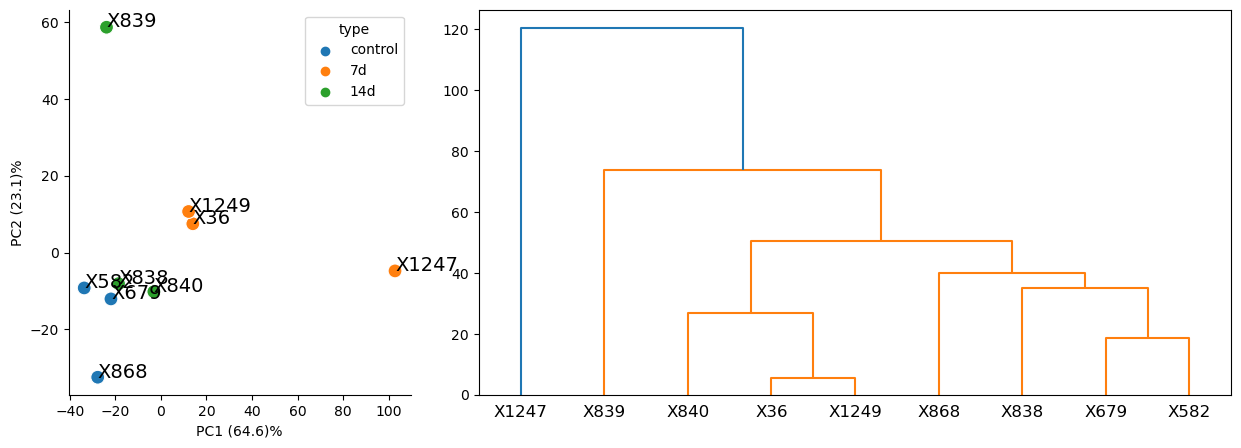

In [1681]:
pca = PCA(n_components=2)
X_r = pca.fit_transform(df.iloc[:,:-1].fillna(0).values)

X_r = pd.DataFrame(X_r).set_index(df.index)

X_r['type'] = df['type']
X_r.columns = ['comp1', 'comp2', 'type']
X_r.index = [i.split('-')[0] for i in X_r.index]

var = pca.explained_variance_ratio_

fig = plt.figure(figsize=(15, 5))
ax_pca = fig.add_subplot(1,3,1)
ax_dn = fig.add_subplot(1,3,(2,3))

sns.scatterplot(x='comp1', y='comp2', hue='type', s=100, data=X_r, ax=ax_pca)
ax_pca.spines[['right', 'top']].set_visible(False)
texts = []
for l, x, y, _ in X_r.reset_index().values:
    texts.append(ax_pca.text(x, y, l, fontsize=14))

ax_pca.set_xlabel('PC1 ('+str(round(var[0]*100, 2))+')%' )
ax_pca.set_ylabel('PC2 ('+str(round(var[1]*100, 2))+')%' )

Z = linkage(df.iloc[:,:-1].fillna(0).values, metric='euclidean', method='average')
dn = dendrogram(Z, labels =[i.split('-')[0] for i in X_r.index], ax=ax_dn)

In [1662]:

# Z_no = linkage(df.values, metric='euclidean', method='average')

In [1634]:
df

35380049   35380091  35380094   35380131  35380132  \
X868-ready.bam   86.615277  58.854167  0.773196  14.560440  3.926702   
X36-ready.bam    63.065226  23.823976  2.208353   4.754829  1.054217   
X679-ready.bam   78.957346  45.739348  1.326900   7.829670  1.988636   
X582-ready.bam   84.031496  41.261062  0.428266  10.362047  2.012579   
X1247-ready.bam  54.953413  23.879599  4.231007   0.376176       NaN   
X1249-ready.bam  61.418925  20.828426  2.006997   6.958073  0.638919   
X838-ready.bam   82.608696  47.152620  0.222717   5.309735       NaN   
X839-ready.bam   31.942215   2.771363  0.643777  17.892977  3.642384   
X840-ready.bam   76.231691  33.965517  0.498339   7.578558  0.782779   

                  35380149   35380188  35380430   35380509    35380546  \
X868-ready.bam   10.447761   4.347826  1.764706  88.376655   85.344828   
X36-ready.bam     0.988040  10.752688  0.260571  69.688249   65.709156   
X679-ready.bam    6.568144  32.653061  0.921187  83.710608   80.049261   
X582-ready.bam    3.464567  29.629630  1.218962  86.636225   96.013865   
X1247-ready.bam        NaN   9.677419  0.111707   3.540305    0.887097   
X1249-ready.bam   3.316683   9.459459  0.254916  71.066092   67.972350   
X838-ready.bam    2.422145  32.142857  0.337695  90.132670   79.781421   
X839-ready.bam    9.074733  44.897959  0.596491  89.803279  100.000000   
X840-ready.bam    5.031447        NaN  0.660170  83.182333   72.079772   

                  35382866   35382944  35379990     type  
X868-ready.bam   28.063241  23.318386       NaN  control  
X36-ready.bam     3.100159   1.443464  0.148066       7d  
X679-ready.bam   35.400517  11.387900  0.435888  control  
X582-ready.bam   31.656184  11.936340  0.099206  control  
X1247-ready.bam   0.705467   0.114877  0.011456       7d  
X1249-ready.bam   3.202196   1.303242  0.203173       7d  
X838-ready.bam    3.349282   1.554404  0.243309      14d  
X839-ready.bam   12.609971   7.766990  0.431965      14d  
X840-ready.bam   12.030075   1.694915  0.105263      14d

In [1625]:
t = np.array([df_a.loc[df_a.type=='7d', 35380094].dropna().values,
              df_g.loc[df_g.type=='7d', 35380094].dropna().values])
t

array([[2037., 3101., 5322.],
       [  46.,  137.,  109.]])

Chi2ContingencyResult(statistic=40.4951171960737, pvalue=1.6091518499419904e-09, dof=2, expected_freq=array([[2026.43043155, 3150.06324405, 5283.5063244 ],
       [  56.56956845,   87.93675595,  147.4936756 ]]))

In [1632]:
t[:,[0,2]]

array([[2037., 5322.],
       [  46.,  109.]])

In [1633]:
chi2_contingency(t[:,[0,2]])

Chi2ContingencyResult(statistic=0.2106997263533219, pvalue=0.646219517680585, dof=1, expected_freq=array([[2040.03154112, 5318.96845888],
       [  42.96845888,  112.03154112]]))

In [1439]:
list(itertools.product(df_g.loc[df_teste.type==cond, array_filter].columns,
                       df_g.loc[df_teste.type==cond, array_filter].index
                       ))

[(35380049, 'X838-ready.bam'),
 (35380049, 'X839-ready.bam'),
 (35380049, 'X840-ready.bam'),
 (35380091, 'X838-ready.bam'),
 (35380091, 'X839-ready.bam'),
 (35380091, 'X840-ready.bam'),
 (35380094, 'X838-ready.bam'),
 (35380094, 'X839-ready.bam'),
 (35380094, 'X840-ready.bam'),
 (35380131, 'X838-ready.bam'),
 (35380131, 'X839-ready.bam'),
 (35380131, 'X840-ready.bam'),
 (35380132, 'X838-ready.bam'),
 (35380132, 'X839-ready.bam'),
 (35380132, 'X840-ready.bam'),
 (35380149, 'X838-ready.bam'),
 (35380149, 'X839-ready.bam'),
 (35380149, 'X840-ready.bam'),
 (35380188, 'X838-ready.bam'),
 (35380188, 'X839-ready.bam'),
 (35380188, 'X840-ready.bam'),
 (35380430, 'X838-ready.bam'),
 (35380430, 'X839-ready.bam'),
 (35380430, 'X840-ready.bam'),
 (35380509, 'X838-ready.bam'),
 (35380509, 'X839-ready.bam'),
 (35380509, 'X840-ready.bam'),
 (35380546, 'X838-ready.bam'),
 (35380546, 'X839-ready.bam'),
 (35380546, 'X840-ready.bam'),
 (35382866, 'X838-ready.bam'),
 (35382866, 'X839-ready.bam'),
 (353828

In [1122]:
list(itertools.product(range(df_g.iloc[idx, array_filter].shape[1]),
                       range(df_g.iloc[idx, array_filter].shape[0])
                       ))#[:df_g.iloc[idx, array_filter].shape[1]]

[(0, 0),
 (0, 1),
 (0, 2),
 (1, 0),
 (1, 1),
 (1, 2),
 (2, 0),
 (2, 1),
 (2, 2),
 (3, 0),
 (3, 1),
 (3, 2),
 (4, 0),
 (4, 1),
 (4, 2),
 (5, 0),
 (5, 1),
 (5, 2),
 (6, 0),
 (6, 1),
 (6, 2),
 (7, 0),
 (7, 1),
 (7, 2),
 (8, 0),
 (8, 1),
 (8, 2),
 (9, 0),
 (9, 1),
 (9, 2),
 (10, 0),
 (10, 1),
 (10, 2),
 (11, 0),
 (11, 1),
 (11, 2),
 (12, 0),
 (12, 1),
 (12, 2),
 (13, 0),
 (13, 1),
 (13, 2)]

In [1104]:
list(range(df_g.iloc[idx, array_filter].shape[0]))

[0, 1, 2]

In [1093]:
df_g.iloc[idx, array_filter].shape

(3, 14)

In [1079]:
df_g.iloc[idx, 0]

X838-ready.bam   NaN
X839-ready.bam   NaN
X840-ready.bam   NaN
Name: 35379655, dtype: float64

In [1059]:
df_a.T#.iloc[:, array_filter].sort_values('type')

Position         35379655  35380034  35380036  35380049  35380091  35380094  \
X868-ready.bam      194.0    1938.0    1858.0     191.0     158.0     385.0   
X36-ready.bam         NaN    5957.0    5937.0    1846.0    1506.0    2037.0   
X679-ready.bam        NaN       NaN    2694.0     444.0     433.0     818.0   
X582-ready.bam        NaN       NaN       NaN     507.0     531.0     930.0   
X1247-ready.bam       NaN    8193.0       NaN    2369.0    2276.0    3101.0   
X1249-ready.bam       NaN   13387.0       NaN    4171.0    4033.0    5322.0   
X838-ready.bam        NaN       NaN       NaN     232.0     232.0     448.0   
X839-ready.bam        NaN       NaN       NaN     424.0     421.0     463.0   
X840-ready.bam        NaN       NaN       NaN     357.0     383.0     599.0   

Position         35380131  35380132  35380149  35380156  ...  35383358  \
X868-ready.bam      311.0     367.0     240.0     437.0  ...       NaN   
X36-ready.bam      1923.0    1971.0    1904.0       NaN  ...       NaN   
X679-ready.bam      671.0     690.0     569.0       NaN  ...       NaN   
X582-ready.bam      718.0     779.0     613.0       NaN  ...       NaN   
X1247-ready.bam    3178.0       NaN       NaN       NaN  ...       NaN   
X1249-ready.bam    5215.0    5443.0    4839.0       NaN  ...       NaN   
X838-ready.bam      321.0       NaN     282.0       NaN  ...      97.0   
X839-ready.bam      491.0     582.0     511.0       NaN  ...       NaN   
X840-ready.bam      500.0     507.0     453.0       NaN  ...       NaN   

Position         35379851  35380586  35381048  35384066  35384664  35380481  \
X868-ready.bam        NaN       NaN       NaN       NaN       NaN       NaN   
X36-ready.bam         NaN       NaN       NaN       NaN       NaN       NaN   
X679-ready.bam        NaN       NaN       NaN       NaN       NaN       NaN   
X582-ready.bam        NaN       NaN       NaN       NaN       NaN       NaN   
X1247-ready.bam       NaN       NaN       NaN       NaN       NaN       NaN   
X1249-ready.bam       NaN       NaN       NaN       NaN       NaN       NaN   
X838-ready.bam        NaN       NaN       NaN       NaN       NaN       NaN   
X839-ready.bam      444.0     276.0      17.0     313.0      12.0       NaN   
X840-ready.bam        NaN       NaN       NaN       NaN       NaN    2943.0   

Position         35382873  35384043  35384697  
X868-ready.bam        NaN       NaN       NaN  
X36-ready.bam         NaN       NaN       NaN  
X679-ready.bam        NaN       NaN       NaN  
X582-ready.bam        NaN       NaN       NaN  
X1247-ready.bam       NaN       NaN       NaN  
X1249-ready.bam       NaN       NaN       NaN  
X838-ready.bam        NaN       NaN       NaN  
X839-ready.bam        NaN       NaN       NaN  
X840-ready.bam      281.0     244.0       9.0  

[9 rows x 191 columns]

In [1064]:
df_a 
# df_a.T.merge(meta, left_index=True, right_index=True)

35379655  35380034  35380036  35380049  35380091  35380094  \
X868-ready.bam      194.0    1938.0    1858.0     191.0     158.0     385.0   
X36-ready.bam         NaN    5957.0    5937.0    1846.0    1506.0    2037.0   
X679-ready.bam        NaN       NaN    2694.0     444.0     433.0     818.0   
X582-ready.bam        NaN       NaN       NaN     507.0     531.0     930.0   
X1247-ready.bam       NaN    8193.0       NaN    2369.0    2276.0    3101.0   
X1249-ready.bam       NaN   13387.0       NaN    4171.0    4033.0    5322.0   
X838-ready.bam        NaN       NaN       NaN     232.0     232.0     448.0   
X839-ready.bam        NaN       NaN       NaN     424.0     421.0     463.0   
X840-ready.bam        NaN       NaN       NaN     357.0     383.0     599.0   

                 35380131  35380132  35380149  35380156  ...  35379851  \
X868-ready.bam      311.0     367.0     240.0     437.0  ...       NaN   
X36-ready.bam      1923.0    1971.0    1904.0       NaN  ...       NaN   
X679-ready.bam      671.0     690.0     569.0       NaN  ...       NaN   
X582-ready.bam      718.0     779.0     613.0       NaN  ...       NaN   
X1247-ready.bam    3178.0       NaN       NaN       NaN  ...       NaN   
X1249-ready.bam    5215.0    5443.0    4839.0       NaN  ...       NaN   
X838-ready.bam      321.0       NaN     282.0       NaN  ...       NaN   
X839-ready.bam      491.0     582.0     511.0       NaN  ...     444.0   
X840-ready.bam      500.0     507.0     453.0       NaN  ...       NaN   

                 35380586  35381048  35384066  35384664  35380481  35382873  \
X868-ready.bam        NaN       NaN       NaN       NaN       NaN       NaN   
X36-ready.bam         NaN       NaN       NaN       NaN       NaN       NaN   
X679-ready.bam        NaN       NaN       NaN       NaN       NaN       NaN   
X582-ready.bam        NaN       NaN       NaN       NaN       NaN       NaN   
X1247-ready.bam       NaN       NaN       NaN       NaN       NaN       NaN   
X1249-ready.bam       NaN       NaN       NaN       NaN       NaN       NaN   
X838-ready.bam        NaN       NaN       NaN       NaN       NaN       NaN   
X839-ready.bam      276.0      17.0     313.0      12.0       NaN       NaN   
X840-ready.bam        NaN       NaN       NaN       NaN    2943.0     281.0   

                 35384043  35384697     type  
X868-ready.bam        NaN       NaN  control  
X36-ready.bam         NaN       NaN       7d  
X679-ready.bam        NaN       NaN  control  
X582-ready.bam        NaN       NaN  control  
X1247-ready.bam       NaN       NaN       7d  
X1249-ready.bam       NaN       NaN       7d  
X838-ready.bam        NaN       NaN      14d  
X839-ready.bam        NaN       NaN      14d  
X840-ready.bam      244.0       9.0      14d  

[9 rows x 192 columns]

In [893]:
from scipy.stats import fisher_exact
from scipy.stats import hypergeom

In [951]:
table = np.array([[6, 2],[1, 4]])
# table = np.array([[60, 22],[11, 45]])
table

array([[6, 2],
       [1, 4]])

In [952]:
M = table.sum()
n = table[0].sum()
N = table[:, 0].sum()

M,n,N

(13, 8, 7)

In [953]:
fisher_exact(table, alternative='two-sided')

SignificanceResult(statistic=12.0, pvalue=0.10256410256410256)

In [954]:


stat_obs, pv_obs = fisher_exact(table, alternative='two-sided')
start, end = hypergeom.support(M, n, N)

# 
for 
hypergeom.pmf(np.arange(start, end+1), M, n, N)

SyntaxError: invalid syntax (4076051961.py, line 5)

In [956]:
np.sum(table, axis=1), np.sum(table, axis=0)

(array([8, 5]), array([7, 6]))

In [1022]:
np.random.hypergeometric(3, 10, 12)

3

In [961]:
np.cumsum(np.sum(table, axis=0)[::-1])[::-1]

array([13,  6])

In [960]:
np.sum(table, axis=0)[::-1]

array([6, 7])

In [908]:
np.sum(table, axis=1)

array([82, 56])

In [909]:
np.sum(table, axis=0)

array([71, 67])

In [898]:
np.arange(start, end+1)

array([2, 3, 4, 5, 6, 7])

In [855]:
ct = np.array([df_g.groupby('type').sum().loc[list(cols_tukey[0]),c].values, df_a.groupby('type').sum().loc[list(cols_tukey[0]),c].values])

In [856]:
ct

array([[1.6000e+01, 3.5000e+01],
       [6.7690e+03, 2.6894e+04]])

In [839]:
df_g.groupby('type').sum().loc[cols_tukey[0],:]

35380049  35380091  35380094  35380131  35380132  35380149  35380188  \
type                                                                            
control    5570.0     964.0      18.0     193.0      45.0      90.0      58.0   
7d        12682.0    2246.0     292.0     498.0      56.0     185.0      33.0   

         35380430  35380509  35380546  35382866  35382944  35379990  
type                                                                 
control     195.0    6534.0    1176.0     359.0     129.0      16.0  
7d           76.0   10057.0    2808.0     156.0      61.0      35.0

In [829]:
df_a.groupby('type').sum().loc[df.type.unique(),:]

35380049  35380091  35380094  35380131  35380132  35380149  35380188  \
type                                                                            
control    1142.0    1122.0    2133.0    1700.0    1836.0    1422.0     167.0   
7d         8386.0    7815.0   10460.0   10316.0    7414.0    6743.0     301.0   
14d        1013.0    1036.0    1510.0    1312.0    1089.0    1246.0      46.0   

         35380430  35380509  35380546  35382866  35382944  35379990  
type                                                                 
control   15245.0    1043.0     155.0     758.0     752.0    6769.0  
7d        32065.0    5920.0    2584.0    6082.0    6073.0   26894.0  
14d       11187.0     727.0     135.0     734.0     707.0    3999.0

In [771]:
t = []
t2 = []
cols_tukey = list(itertools.combinations(df.type.unique(), 2))
for c in df.columns[:-1]:
    t.append(pg.anova(dv=c, between='type', data=df, detailed=False))
    t[-1]['Position'] = c
    
    aux_tukey = sp.posthoc_tukey(df, val_col=c, group_col='type')
    aux_tukey = aux_tukey.loc[df.type.unique(), df.type.unique()] # just to confirm that the order will be always the same
    np.fill_diagonal(aux_tukey.values, 0) # to transform to squareform, the diagonal must be zero
    t[-1].loc[:,cols_tukey] = squareform(aux_tukey)

In [772]:
pd.concat(t)

Source  ddof1  ddof2          F     p-unc       np2  Position  \
0   type      2      6   1.784231  0.246563  0.372940  35380049   
0   type      2      6   2.764809  0.140932  0.479601  35380091   
0   type      2      6   8.173934  0.019353  0.731518  35380094   
0   type      2      6   1.919122  0.226830  0.390135  35380131   
0   type      2      4   1.200237  0.390567  0.375046  35380132   
0   type      2      5   1.348671  0.340074  0.350425  35380149   
0   type      2      5   4.332192  0.080993  0.634085  35380188   
0   type      2      6  12.933193  0.006675  0.811714  35380430   
0   type      2      6   3.004849  0.124697  0.500404  35380509   
0   type      2      6   2.891942  0.132004  0.490830  35380546   
0   type      2      6  50.002653  0.000181  0.943399  35382866   
0   type      2      6   9.269819  0.014617  0.755498  35382944   
0   type      2      5   0.730906  0.526671  0.226223  35379990   

   (control, 7d)  (control, 14d)  (7d, 14d)  
0       0.260074        0.366159   0.900000  
0       0.145342        0.253650   0.895883  
0       0.044989        0.801910   0.021601  
0       0.255162        0.900000   0.313605  
0       0.372393        0.900000   0.585628  
0       0.318726        0.860274   0.520867  
0       0.404732        0.299357   0.069988  
0       0.006144        0.029944   0.372468  
0       0.173573        0.900000   0.156740  
0       0.157269        0.900000   0.193313  
0       0.001000        0.001000   0.134846  
0       0.015799        0.037772   0.730962  
0       0.609173        0.900000   0.577225

98

In [573]:
res = []
stat_res = []
cols_tukey = list(itertools.combinations(df.type.unique(), 2))
for c in df.columns[:-1]:
    aux_aov = pg.anova(dv=c, between='type', data=df, detailed=False)
    
    if not aux_aov[aux_aov['p-unc']<=0.1].empty:
        aux_tukey = sp.posthoc_tukey(df, val_col=c, group_col='type')
        
        if (aux_tukey<0.1).values.sum() > 0 :
            res.append(pg.anova(dv=c, between='type', data=df, detailed=False))#.to_csv('A2I_anova.csv')
            res[-1]['Position'] = c
            
            aux_tukey = aux_tukey.loc[df.type.unique(), df.type.unique()] # just to confirm that the order will be always the same
            np.fill_diagonal(aux_tukey.values, 0) # to transform to squareform, the diagonal must be zero
            res[-1].loc[:,cols_tukey] = squareform(aux_tukey)
res = pd.concat(res).set_index('Position')
stat_res.append(res.merge(df[res.index].T, left_index=True, right_index=True))

Source  ddof1  ddof2          F     p-unc       np2  (control, 7d)  \
33228199   type      2      5   4.562602  0.074548  0.646023       0.095512   
33228846   type      2      3   9.118312  0.053095  0.858735       0.553582   
33228662   type      2      3  45.317167  0.005735  0.967960       0.111649   

          (control, 14d)  (7d, 14d)  X868-ready.bam  X36-ready.bam  \
33228199        0.900000   0.088124       99.858989            NaN   
33228846        0.114070   0.051136             NaN      99.977548   
33228662        0.016256   0.005337             NaN            NaN   

          X679-ready.bam  X582-ready.bam  X1247-ready.bam  X1249-ready.bam  \
33228199       99.929720       99.981258        99.828708        99.803333   
33228846       99.952035       99.975907              NaN        99.991150   
33228662       99.844539       99.836868        99.790466        99.801193   

          X838-ready.bam  X839-ready.bam  X840-ready.bam  
33228199       99.935712       99.950800       99.892009  
33228846             NaN       99.894811       99.928083  
33228662       99.951923       99.917864             NaN

In [887]:
import numpy as np
from scipy.stats import hypergeom
table = np.array([[6, 2], [1, 4]])
M = table.sum()
n = table[0].sum()
N = table[:, 0].sum()

start, end = hypergeom.support(M, n, N)
hypergeom.pmf(np.arange(start, end+1), M, n, N)

array([0.01631702, 0.16317016, 0.40792541, 0.32634033, 0.08158508,
       0.004662  ])

In [891]:
np.arange(start, end+1)

array([2, 3, 4, 5, 6, 7])

In [879]:
from scipy import stats # goodness_of_fit

In [892]:
# stats.goodness_of_fit(stats.nbinom, [19,20])

In [873]:
table[:,0]

array([6, 1])

In [865]:
start, end

(2, 7)

In [869]:
n

8

In [870]:
N

7

In [876]:
np.arange(start, end+1)

array([2, 3, 4, 5, 6, 7])

In [563]:
cols_tukey = list(itertools.combinations(df.type.unique(), 2))
cols_tukey

[('control', '7d'), ('control', '14d'), ('7d', '14d')]

In [564]:
res[-1].loc[:,cols_tukey] = squareform(aux_tukey)

In [565]:
res[-1]

Source  ddof1  ddof2          F     p-unc      np2  Position  (control, 7d)  \
0   type      2      3  45.317167  0.005735  0.96796  33228662       0.111649   

   (control, 14d)  (7d, 14d)  
0        0.016256   0.005337

In [561]:
list(itertools.combinations(df.type.unique(), 2))

[('control', '7d'), ('control', '14d'), ('7d', '14d')]

In [547]:
df.type.unique()

array(['control', '7d', '14d'], dtype=object)

In [550]:
aux_tukey = aux_tukey.loc[df.type.unique(), df.type.unique()]
np.fill_diagonal(aux_tukey.values,0)

In [558]:
aux_tukey

control        7d       14d
control  0.000000  0.111649  0.016256
7d       0.111649  0.000000  0.005337
14d      0.016256  0.005337  0.000000

In [559]:
squareform(aux_tukey)

array([0.11164863, 0.01625554, 0.00533722])

In [549]:
aux_tukey.loc[['7d','14d','control'],['7d','14d','control']]

7d       14d   control
7d       1.000000  0.005337  0.111649
14d      0.005337  1.000000  0.016256
control  0.111649  0.016256  1.000000

In [568]:
res = pd.concat(res).set_index('Position')
# res

In [530]:
df

33216154   33216262   33216268   33216450   33216452  \
X868-ready.bam   99.966636  99.991243  99.780660  99.944130  99.946291   
X36-ready.bam          NaN  99.708794  99.933665  99.904434        NaN   
X679-ready.bam   99.893695  99.927733  99.919646        NaN  99.849329   
X582-ready.bam         NaN  99.966279  99.993702  99.926531  99.910170   
X1247-ready.bam  99.924214  99.727414        NaN  99.941725  99.971751   
X1249-ready.bam  99.988812  99.977480  99.838349  99.846014  99.877204   
X838-ready.bam   99.902629  99.932180  99.702048  99.913245  99.944675   
X839-ready.bam   99.798133  99.891245  99.879373  99.711560  99.788539   
X840-ready.bam         NaN        NaN  99.688150  99.960707  99.925262   

                  33228199   33228209   33228210   33228298   33228305  ...  \
X868-ready.bam   99.858989  99.863967  99.816616  99.968593  99.981767  ...   
X36-ready.bam          NaN        NaN  99.953402  99.744542  99.971330  ...   
X679-ready.bam   99.929720  99.931087  99.893146  99.641791  99.897260  ...   
X582-ready.bam   99.981258  99.849376  99.887740  99.579341  99.944460  ...   
X1247-ready.bam  99.828708  99.965059  99.859993  99.767442  99.961759  ...   
X1249-ready.bam  99.803333  99.957447  99.894135  99.905601        NaN  ...   
X838-ready.bam   99.935712  99.968061  99.873056  99.646435  99.869409  ...   
X839-ready.bam   99.950800  99.901526  99.879576  99.688175  99.972737  ...   
X840-ready.bam   99.892009        NaN  99.773909  99.826389        NaN  ...   

                  33247212   33247227   33247334   33228846   33247452  \
X868-ready.bam   99.908341  99.688740  99.524578        NaN        NaN   
X36-ready.bam          NaN  99.636694  99.703044  99.977548  99.981185   
X679-ready.bam   99.992052  99.874655  99.735053  99.952035  99.900710   
X582-ready.bam   99.957684  99.903740  99.834059  99.975907  99.959529   
X1247-ready.bam  99.962378  99.846685  99.621053        NaN  99.966079   
X1249-ready.bam  99.922481  99.652817  99.771298  99.991150  99.826351   
X838-ready.bam   99.800863  99.865275  99.931624        NaN  99.854142   
X839-ready.bam   99.846052  99.933614  99.433865  99.894811  99.824677   
X840-ready.bam   99.953413        NaN  99.730590  99.928083  99.977852   

                  33228323   33228594   33228662   33247618     type  
X868-ready.bam         NaN        NaN        NaN        NaN  control  
X36-ready.bam          NaN        NaN        NaN        NaN       7d  
X679-ready.bam   99.957128  99.920792  99.844539  99.990429  control  
X582-ready.bam   99.971739  99.857646  99.836868  99.994530  control  
X1247-ready.bam  99.908299  99.785753  99.790466  99.905482       7d  
X1249-ready.bam  99.971707  99.901364  99.801193  99.883738       7d  
X838-ready.bam         NaN  99.904077  99.951923        NaN      14d  
X839-ready.bam   99.932295  99.663866  99.917864  99.876619      14d  
X840-ready.bam   99.885584        NaN        NaN  99.971526      14d  

[9 rows x 40 columns]

In [569]:
res

Source  ddof1  ddof2          F     p-unc       np2  (control, 7d)  \
Position                                                                      
33228199   type      2      5   4.562602  0.074548  0.646023       0.095512   
33228846   type      2      3   9.118312  0.053095  0.858735       0.553582   
33228662   type      2      3  45.317167  0.005735  0.967960       0.111649   

          (control, 14d)  (7d, 14d)  
Position                             
33228199        0.900000   0.088124  
33228846        0.114070   0.051136  
33228662        0.016256   0.005337

In [532]:
df[res.index].T.merge(res, left_index=True, right_index=True )

X868-ready.bam  X36-ready.bam  X679-ready.bam  X582-ready.bam  \
33228662             NaN            NaN       99.844539       99.836868   

          X1247-ready.bam  X1249-ready.bam  X838-ready.bam  X839-ready.bam  \
33228662        99.790466        99.801193       99.951923       99.917864   

          X840-ready.bam Source  ddof1  ddof2          F     p-unc      np2  
33228662             NaN   type      2      3  45.317167  0.005735  0.96796

In [531]:
res

Source  ddof1  ddof2          F     p-unc      np2
Position                                                   
33228662   type      2      3  45.317167  0.005735  0.96796

In [465]:
res[res['p-unc']<=0.1]#.Position.values

Source  ddof1  ddof2          F     p-unc       np2
Position                                                    
33228199   type      2      5   4.562602  0.074548  0.646023
33228846   type      2      3   9.118312  0.053095  0.858735
33228662   type      2      3  45.317167  0.005735  0.967960

In [458]:
df[[33228199, 33228846, 33228662]].T

X868-ready.bam  X36-ready.bam  X679-ready.bam  X582-ready.bam  \
33228199       99.858989            NaN       99.929720       99.981258   
33228846             NaN      99.977548       99.952035       99.975907   
33228662             NaN            NaN       99.844539       99.836868   

          X1247-ready.bam  X1249-ready.bam  X838-ready.bam  X839-ready.bam  \
33228199        99.828708        99.803333       99.935712       99.950800   
33228846              NaN        99.991150             NaN       99.894811   
33228662        99.790466        99.801193       99.951923       99.917864   

          X840-ready.bam  
33228199       99.892009  
33228846       99.928083  
33228662             NaN

In [513]:
a = sp.posthoc_tukey(df, val_col=33228846, group_col='type')#.to_csv('A2I_posthoc_tukey.csv')
np.fill_diagonal(a.values, 0)

In [514]:
import itertools

In [515]:
list(itertools.combinations(a.columns, 2))

[('control', '7d'), ('control', '14d'), ('7d', '14d')]

In [523]:
pd.DataFrame([list(itertools.combinations(a.columns, 2)),squareform(a.values)])

0               1          2
0  (control, 7d)  (control, 14d)  (7d, 14d)
1       0.553582         0.11407   0.051136

In [511]:
np.fill_diagonal(a.values, 0)

In [526]:
df.type.unique()

array(['control', '7d', '14d'], dtype=object)

In [527]:
a.loc[df.type.unique(), df.type.unique()]

control        7d       14d
control  0.000000  0.553582  0.114070
7d       0.553582  0.000000  0.051136
14d      0.114070  0.051136  0.000000

In [528]:
a

control        7d       14d
control  0.000000  0.553582  0.114070
7d       0.553582  0.000000  0.051136
14d      0.114070  0.051136  0.000000

In [157]:
aux = dict()#{g:[] for g in genes}
var = ['freq', 'Coverage-q30', 'MeanQ', 'ng', 'na_ng']
samples = []
filter_snp = False
filter_100 = True
filter_AG_CT = True
filter_n_reads = True

meta = pd.read_csv('/mnt/d/rna_editing/metadata.txt', dtype='str')
for g in ['1700034I23Rik']:#genes:
    aux[g] = []
    aux_df = {c:[] for c in ['freq', 'Coverage-q30', 'MeanQ', 'ng', 'na_ng']}
    for b in bams:        
        df = pd.read_csv( os.path.join(pathREDI,b+'_'+g+'_RES.txt'), sep='\t' )
        if df.empty:
            df['freq'] = np.nan
            df['ng'] = np.nan
            df['na_ng'] = np.nan
            for k in aux_df.keys():
                aux_df[k].append(df[['Position', k]].set_index('Position'))
                aux_df[k][-1].columns = [b.split('-')[0].replace('X', '')]
            # aux[g].append(np.nan)#( 'empty' )  
            # continue
        else:
            if filter_snp:                
                dbsnp_list = df_redi[(df_redi.Region==df.Region.unique()[0]) & (df_redi.dbsnp!='-')].Position.values
                df = df[~df.Position.isin(dbsnp_list)]                
            df = df[df.Reference.isin(['A','T'])]
            
            if filter_AG_CT:
                df = df[(df.AllSubs.str.contains('AG')) | (df.AllSubs.str.contains('CT'))]
                
            if filter_n_reads:
                df = df[df['Coverage-q30']>=10]
                
            if df.empty:
                df['freq'] = np.nan
                df['ng'] = np.nan
                df['na_ng'] = np.nan
                for k in aux_df.keys():
                    aux_df[k].append(df[['Position', k]].set_index('Position'))
                    aux_df[k][-1].columns = [b.split('-')[0].replace('X', '')]
                # aux[g].append(np.nan)#( 'empty' )
            else:
                # aux[g].append('m')
                df[['count_A','count_C','count_G','count_T']] = df['BaseCount[A,C,G,T]'].str.replace('[','',regex=True).str.replace(']','', regex=True).str.split(',',expand=True).apply(pd.to_numeric)
                df['freq'] = np.where((df['Reference']=='A'), df.count_G/(df.count_G+df.count_A), df.count_C/(df.count_C+df.count_T))
                df['freq'] = df['freq']*100
                #exclude 100 and 0???
                # df = df[(df['freq']<100) & (df['freq']>0)]
                df['ng'] = np.where((df['Reference']=='A'), df.count_G, df.count_C)
                df['na_ng'] = np.where((df['Reference']=='A'), (df.count_G+df.count_A), (df.count_C+df.count_T))
                # df['bam'] = b.split('-')[0].replace('X', '')
                df['gene'] = g

                for k in aux_df.keys():
                    aux_df[k].append(df[['Position', k]].set_index('Position'))
                    aux_df[k][-1].columns = [b.split('-')[0].replace('X', '')]
    
    # Create anndata for a gene AND all bams
    # for b in bams:
        
    for k in aux_df.keys():
        if not pd.concat(aux_df[k], axis=1).T.empty:
            if k == 'freq':            
                adata = ad.AnnData( pd.concat(aux_df[k], axis=1).T )
                adata.obs = adata.obs.merge( meta.set_index('sample'), left_index=True, right_index=True)
            else:
                adata.layers[k] = pd.concat(aux_df[k], axis=1).T.values

            # Get the nan ocurrences in sample and store the sample with major value
            adata.var['n_nan_max'] = np.array([np.isnan(adata[adata.obs.type=='control',:].X).sum(axis=0),
                                           np.isnan(adata[adata.obs.type=='7d',:].X).sum(axis=0),
                                           np.isnan(adata[adata.obs.type=='14d',:].X).sum(axis=0)]).max(axis=0)
            # Get the zero ocurrences in sample and store the sample with major value
            adata.var['n_zero_max'] = np.array([((adata[adata.obs.type=='control',:].X)<=0.).sum(axis=0),
                                            ((adata[adata.obs.type=='7d',:].X)<=0.).sum(axis=0),
                                            ((adata[adata.obs.type=='14d',:].X)<=0.).sum(axis=0)]).max(axis=0)
            # Get the 100% ocurrences in sample and store the sum of accurencies
            adata.var['n_hundred_sum'] = np.array([((adata[adata.obs.type=='control',:].X)>=100).sum(axis=0),
                                               ((adata[adata.obs.type=='7d',:].X)>=100).sum(axis=0),
                                               ((adata[adata.obs.type=='14d',:].X)>=100).sum(axis=0)]).sum(axis=0)
    try:
        adata = adata[:,(adata.var.n_nan_max < 3) & (adata.var.n_zero_max < 3)]
        aux[g].extend(list( 100*np.nan_to_num(adata.layers['ng']).sum(axis=1) / np.nan_to_num(adata.layers['na_ng']).sum(axis=1) ))
        
        # del(adata)
        # del(df)
    except:
        aux[g].extend([np.nan])
    
    
    # aux[b].append( 100*df[['ng','na_ng']].sum().ng/df[['ng','na_ng']].sum().na_ng )
    # if g == 'Kdm6b':

In [183]:
aux_df

{'freq': [Empty DataFrame
  Columns: [838]
  Index: [],
  Empty DataFrame
  Columns: [36]
  Index: [],
  Empty DataFrame
  Columns: [868]
  Index: [],
  Empty DataFrame
  Columns: [840]
  Index: [],
  Empty DataFrame
  Columns: [679]
  Index: [],
  Empty DataFrame
  Columns: [839]
  Index: [],
  Empty DataFrame
  Columns: [582]
  Index: [],
  Empty DataFrame
  Columns: [1249]
  Index: [],
  Empty DataFrame
  Columns: [1247]
  Index: []],
 'Coverage-q30': [Empty DataFrame
  Columns: [838]
  Index: [],
  Empty DataFrame
  Columns: [36]
  Index: [],
  Empty DataFrame
  Columns: [868]
  Index: [],
  Empty DataFrame
  Columns: [840]
  Index: [],
  Empty DataFrame
  Columns: [679]
  Index: [],
  Empty DataFrame
  Columns: [839]
  Index: [],
  Empty DataFrame
  Columns: [582]
  Index: [],
  Empty DataFrame
  Columns: [1249]
  Index: [],
  Empty DataFrame
  Columns: [1247]
  Index: []],
 'MeanQ': [Empty DataFrame
  Columns: [838]
  Index: [],
  Empty DataFrame
  Columns: [36]
  Index: [],
  Em

In [166]:
x = pd.concat(aux_df[k], axis=1).T

In [172]:
x['-1'] = np.nan

In [174]:
adata = ad.AnnData( x )

In [176]:
adata.obs = adata.obs.merge( meta.set_index('sample'), left_index=True, right_index=True)

In [179]:
adata.obs

type
838       14d
36         7d
868   control
840       14d
679   control
839       14d
582   control
1249       7d
1247       7d

In [79]:
df

Empty DataFrame
Columns: [Region, Position, Reference, Strand, Coverage-q30, MeanQ, BaseCount[A,C,G,T], AllSubs, Frequency, gCoverage-q30, gMeanQ, gBaseCount[A,C,G,T], gAllSubs, gFrequency]
Index: []

In [21]:
# aux_df[k]
df_ed = pd.DataFrame(aux)
df_ed['samples'] = [b.split('-')[0].replace('X', '') for b in bams]
df_ed.set_index('samples', inplace=True)
df_ed = df_ed.iloc[:,(np.where(df_ed.isna().sum()<8)[0])]

ValueError: All arrays must be of the same length

In [8]:
values = {c: df_ed[c].dropna().astype(int).mode()[0] for c in df_ed.iloc[:, (np.where( (df_ed.isna().sum()<8) & (df_ed.isna().sum()>0) )[0])]}
df_ed = df_ed.fillna(value=values)

In [9]:
df_ed.iloc[:,np.where(df_ed.var()>0)[0]]

Prkab2      H2-K1        Tgm2        Msra      Rnf14      Ube2l6  \
samples                                                                        
838      99.984205  87.561438  100.000000   99.984874  99.247793  100.000000   
36       99.991621  82.759311  100.000000   99.974093  99.921342   99.953219   
868      99.979121  87.579488   99.988609   99.991819  99.992636  100.000000   
840      99.970372  87.763072   99.886072   98.896410  99.978053  100.000000   
679      99.984678  88.805791   99.996747   99.986562  99.968414  100.000000   
839      99.913548  84.653556   99.946184  100.000000  99.992306   99.966073   
582      99.960824  86.980851   99.976702   98.811293  99.311989  100.000000   
1249     99.978598  80.567987   99.989017   98.794323  99.299713   99.987261   
1247     99.978282  81.344925   99.992231  100.000000  99.995265   99.986295   

              Usp38        B2m    Hist1h4d       Atf3  ...    Ralgps1  \
samples                                                ...              
838       99.673749  99.474511   99.992329  95.142251  ...  87.754857   
36       100.000000  92.337355  100.000000  90.305228  ...  87.420686   
868       99.998344  95.425262   99.992369  88.748753  ...  84.140768   
840       99.548780  91.967266   99.939905  92.767355  ...  85.343845   
679       99.584371  98.872789   99.966998  87.377531  ...  83.109423   
839      100.000000  99.958538   99.986897  95.829716  ...  84.411500   
582       99.964243  96.789593   99.969459  87.377662  ...  77.017624   
1249      99.669362  91.349213   99.961888  86.056684  ...  81.295383   
1247      99.982699  91.904164   99.956332  90.034453  ...  87.922079   

             Stat5a       Sipa1    Tnfaip3       Tle3      Plgrkt      Efcab2  \
samples                                                                         
838      100.000000   99.991763  99.226405  99.967506  100.000000  100.000000   
36       100.000000  100.000000  98.258095  99.910611  100.000000  100.000000   
868      100.000000   99.982593  98.914683  99.966806  100.000000   99.981491   
840      100.000000  100.000000  99.648212  99.975867  100.000000  100.000000   
679      100.000000   99.952810  98.439555  99.981290   99.957338   99.975175   
839      100.000000   99.952035  99.707181  99.919582  100.000000   99.987305   
582       99.967414   99.973123  98.534392  99.960377  100.000000   99.992649   
1249      99.950806   99.946676  98.277216  99.958618  100.000000   99.982488   
1247     100.000000  100.000000  98.911352  99.967378  100.000000   99.965529   

             Tspyl5     Gm15821      Tarbp2  
samples                                      
838       99.936427   99.991165  100.000000  
36        99.980012   99.943490  100.000000  
868      100.000000   99.836417   99.945397  
840       99.980048  100.000000   99.986508  
679       99.987321   99.982064   99.976738  
839      100.000000   99.951281   99.931271  
582      100.000000   99.986271  100.000000  
1249      99.978673   99.958292   99.968237  
1247      99.924338  100.000000  100.000000  

[9 rows x 128 columns]

In [10]:
th = df_ed.var(axis=0).quantile(q=.9)
df_ed = df_ed.iloc[:,np.where((df_ed.var(axis=0)>th).values)[0]]#.melt(ignore_index=False)

In [11]:
th

3.1442055732677274

In [12]:
meta['color'] = ['r','r','r','b','b','b','g','g','g']
meta

sample     type color
0    582  control     r
1    679  control     r
2    868  control     r
3   1247       7d     b
4   1249       7d     b
5     36       7d     b
6    838      14d     g
7    839      14d     g
8    840      14d     g

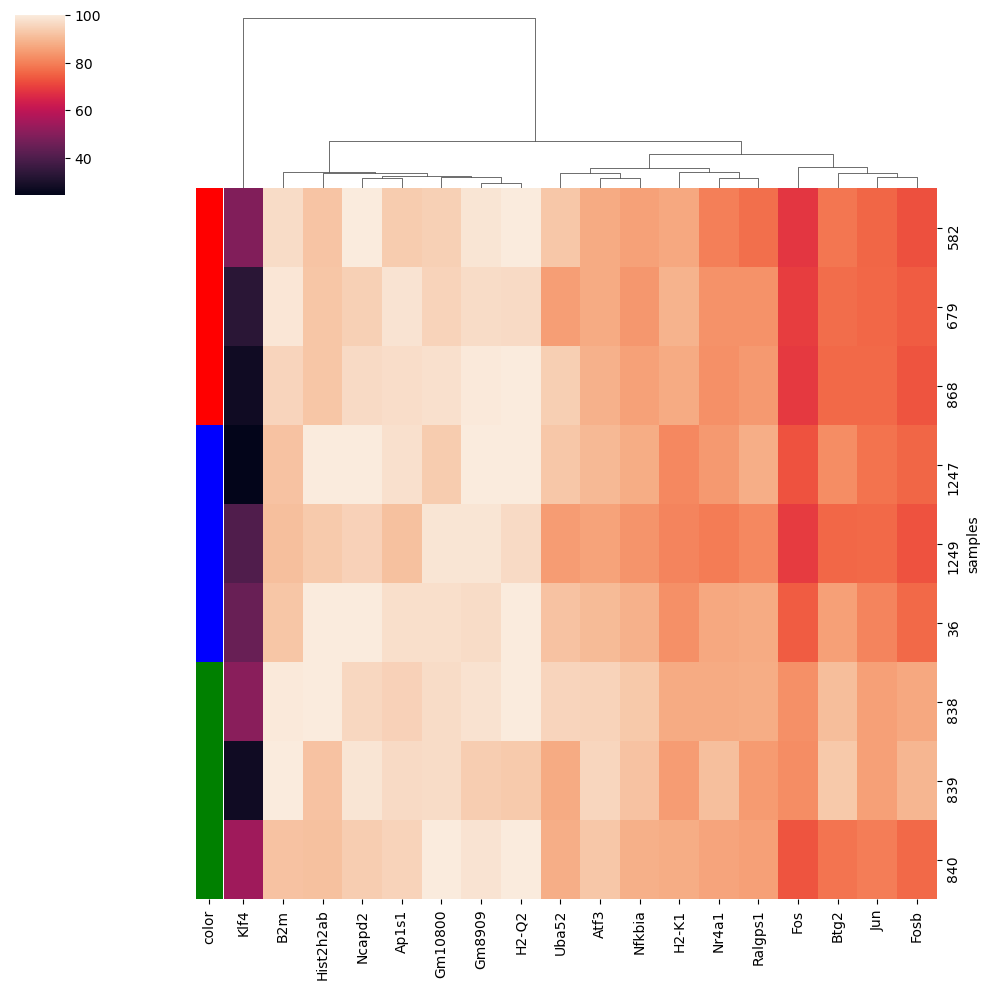

In [13]:
sns.clustermap(df_ed.loc[meta['sample'],:], row_cluster=False, row_colors=meta[['sample','color']].set_index('sample'))
plt.savefig('/mnt/d/rna_editing/cluster_map.png', format='png', dpi=300)

In [349]:
df = df_ed.melt(ignore_index=False).merge(meta, left_index=True, right_on='sample')

In [350]:
df

variable       value sample type color
5       H2-Q2   99.975306     36   7d     b
5        Btg2   85.312795     36   7d     b
5     Gm10800   97.000000     36   7d     b
5         Fos   74.231957     36   7d     b
5        Fosb   76.294120     36   7d     b
..        ...         ...    ...  ...   ...
3   Hist2h2ab  100.000000   1247   7d     b
3         Jun   77.576219   1247   7d     b
3       Ap1s1   97.893764   1247   7d     b
3        Atf3   90.034453   1247   7d     b
3        Klf4   24.333770   1247   7d     b

[162 rows x 5 columns]

In [ ]:
for g in df.variable.unique()

In [353]:
df_aux = []
for g in df.variable.unique():
    df_aux.append(pg.anova(dv='value', between='type', data=df[df.variable==g], detailed=False))
    df_aux[-1]['gene'] = g

In [358]:
aov = pd.concat(df_aux)
aov['adj_pv'] = pg.multicomp(aov['p-unc'], method='fdr_bh')[1]

In [359]:
aov.set_index('gene').sort_values('p-unc').to_csv('/mnt/d/rna_editing/reditools_gene_aov.csv')

In [361]:
aov.sort_values('adj_pv')

Source  ddof1  ddof2          F     p-unc       np2       gene    adj_pv
0   type      2      6  19.347531  0.002419  0.865757      H2-K1  0.043546
0   type      2      6  13.508551  0.006001  0.818276       Atf3  0.054011
0   type      2      6   7.870988  0.021016  0.724036        Jun  0.126098
0   type      2      6   6.753173  0.029102  0.692408        Fos  0.130226
0   type      2      6   5.823902  0.039299  0.660014       Fosb  0.130226
0   type      2      6   5.536155  0.043409  0.648554     Nfkbia  0.130226
0   type      2      6   3.882150  0.082831  0.564090      Nr4a1  0.212993
0   type      2      6   3.501092  0.098266  0.538539        B2m  0.221099
0   type      2      6   2.634626  0.150928  0.467578       Btg2  0.301855
0   type      2      6   1.814717  0.241909  0.376910  Hist2h2ab  0.413156
0   type      2      6   1.746534  0.252484  0.367960    Ralgps1  0.413156
0   type      2      6   0.777842  0.500763  0.205896     Gm8909  0.751145
0   type      2      6   0.398856  0.687647  0.117350       Klf4  0.884118
0   type      2      6   0.418688  0.675749  0.122470     Ncapd2  0.884118
0   type      2      6   0.027839  0.972669  0.009194      Uba52  0.972669
0   type      2      6   0.072236  0.931108  0.023513    Gm10800  0.972669
0   type      2      6   0.082424  0.921906  0.026740      Ap1s1  0.972669
0   type      2      6   0.156576  0.858450  0.049603      H2-Q2  0.972669

In [356]:
pg.multicomp(aov['p-unc'], method='fdr_bh')[1]

array([0.97266944, 0.30185504, 0.97266944, 0.13022612, 0.13022612,
       0.97266944, 0.88411775, 0.41315581, 0.22109928, 0.04354594,
       0.13022612, 0.75114491, 0.21299329, 0.41315581, 0.12609795,
       0.97266944, 0.05401065, 0.88411775])

In [273]:
df_ed.iloc[:,(np.where(df_ed.isna().sum()<9)[0])]

Rnf14  Gm10065  2410004P03Rik         Gls  Ccdc183   Gale  \
samples                                                                  
36       99.921342      NaN     100.000000  100.000000      NaN  100.0   
839      99.992306      NaN      99.910992   99.944233      NaN  100.0   
582      99.311989      NaN     100.000000   99.513665      NaN  100.0   
1249     99.299713      NaN      99.965517   99.550828      NaN  100.0   
868      99.992636    100.0      99.910175   99.968312    100.0  100.0   
838      99.247793    100.0     100.000000   99.975697    100.0  100.0   
840      99.978053    100.0     100.000000   99.552992    100.0  100.0   
679      99.968414    100.0      99.946417   99.975527    100.0  100.0   
1247     99.995265    100.0     100.000000   99.963610    100.0  100.0   

               Ecm1  Slit1      Zbtb48       Nagk  ...      Ap1s1  Lama1  \
samples                                            ...                     
36       100.000000    NaN  100.000000  99.975954  ...  97.559230    NaN   
839      100.000000    NaN  100.000000  99.978445  ...  96.613044    NaN   
582      100.000000    NaN  100.000000  99.972829  ...  93.682944    NaN   
1249      99.944843    NaN  100.000000  99.973677  ...  91.682897    NaN   
868      100.000000  100.0  100.000000  99.988912  ...  97.117224  100.0   
838      100.000000  100.0  100.000000  99.974176  ...  94.929999  100.0   
840       99.590583    NaN  100.000000  99.977760  ...  95.264624  100.0   
679      100.000000  100.0   99.985033  99.976607  ...  98.306644  100.0   
1247     100.000000  100.0  100.000000  99.971818  ...  97.893764  100.0   

              Atf3       Klf4     Pik3c2a  Setd4  Tusc1        Gbp2  Ypel4  \
samples                                                                      
36       90.305228  44.684914  100.000000    NaN    NaN   99.974737    NaN   
839      95.829716  27.559055  100.000000    NaN  100.0   99.954212  100.0   
582      87.377662  48.880779   99.995188  100.0  100.0  100.000000  100.0   
1249     86.056684  40.004084   99.584328  100.0  100.0   99.966214  100.0   
868      88.748753  27.540631   99.703113  100.0  100.0  100.000000  100.0   
838      95.142251  50.374532   99.763099  100.0  100.0  100.000000    NaN   
840      92.767355  54.222222   99.988496  100.0  100.0   99.991382    NaN   
679      87.377531  32.702370   99.958144  100.0  100.0   99.993058  100.0   
1247     90.034453  24.333770   99.950290  100.0  100.0   99.979762    NaN   

               Eml6  
samples              
36       100.000000  
839       99.971575  
582       99.986968  
1249      99.984236  
868       99.993731  
838       99.973545  
840      100.000000  
679       99.978848  
1247      99.983300  

[9 rows x 180 columns]

In [271]:
df_ed.iloc[:,69]

samples
36     NaN
839    NaN
582    NaN
1249   NaN
868    NaN
838    NaN
840    NaN
679    NaN
1247   NaN
Name: Dnajb5, dtype: float64

In [205]:
df_ed.Ap1s1.astype(int).mode()

0    97
Name: Ap1s1, dtype: int64

In [184]:
df_ed['Gm10065'].mode()#.fillna()

0    100.0
Name: Gm10065, dtype: float64

In [153]:
np.where((df_ed.mean(axis=0)<99))[0].shape

Rnf14            0.119179
Gm10065          0.000000
2410004P03Rik    0.001517
Gls              0.047001
Ccdc183          0.000000
                   ...   
Setd4            0.000000
Tusc1            0.000000
Gbp2             0.000276
Ypel4            0.000000
Eml6             0.000110
Length: 181, dtype: float64

In [165]:
df_ed.iloc[:,np.where((df_ed.mean(axis=0)<99).values)[0]].melt(ignore_index=False)

variable      value
samples                    
36        Tubb4b  98.306848
839       Tubb4b  98.077455
582       Tubb4b  97.843212
1249      Tubb4b  95.761948
868       Tubb4b  98.519891
...          ...        ...
868         Klf4  27.540631
838         Klf4  50.374532
840         Klf4  54.222222
679         Klf4  32.702370
1247        Klf4  24.333770

[252 rows x 2 columns]

In [166]:
np.where((df_ed.var(axis=0)>0.05))[0]

array([  0,  13,  16,  22,  23,  29,  33,  39,  41,  42,  44,  47,  56,
        60,  66,  71,  73,  76,  85,  86,  88,  89,  90,  93, 100, 102,
       103, 105, 111, 115, 118, 121, 122, 123, 125, 141, 143, 144, 151,
       156, 160, 169, 171, 173, 174])

In [174]:
th = df_ed.var(axis=0).quantile(q=.75)

df_ed = df_ed.iloc[:,np.where((df_ed.var(axis=0)>th).values)[0]]#.melt(ignore_index=False)

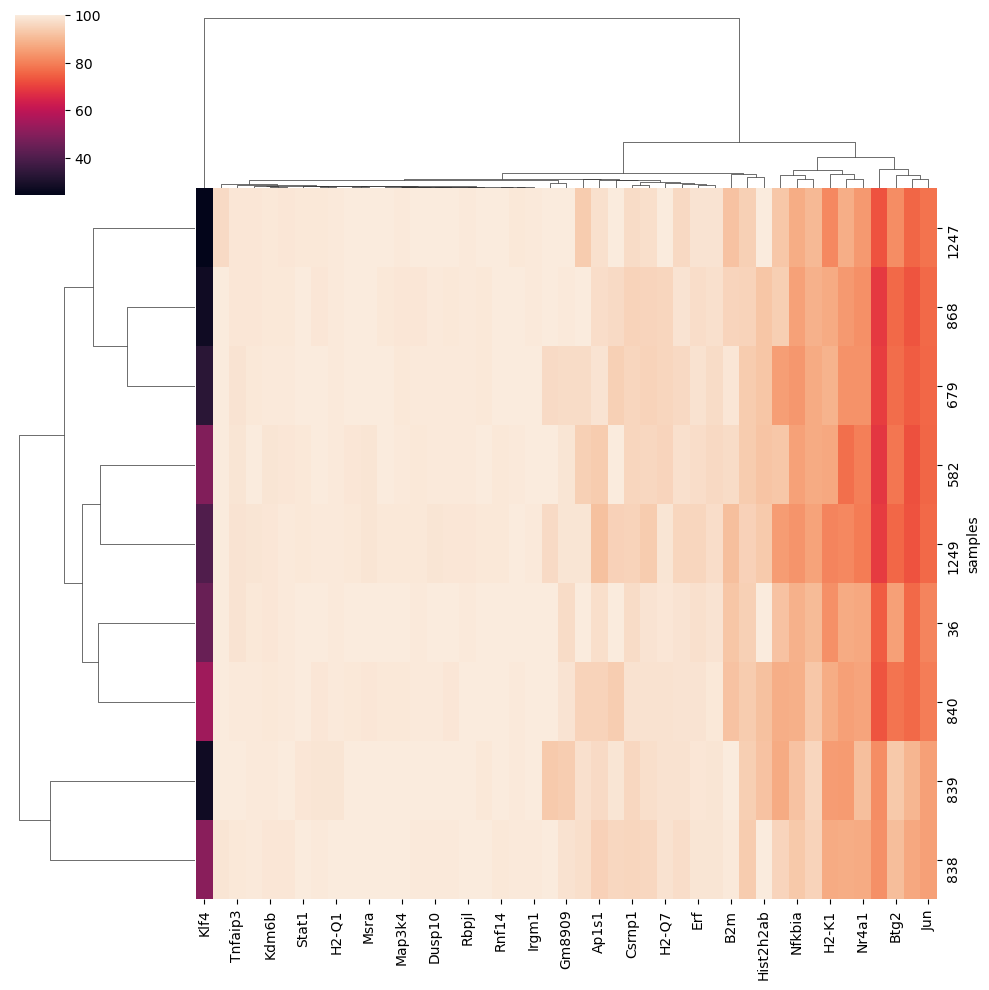

In [180]:
sns.clustermap(df_ed.fillna(100))

In [327]:
np.array([a,b]).max(axis=0)

array([5, 2, 3])

In [382]:
adata[:,(adata.var.n_nan_max < 3) & (adata.var.n_zero_max < 3)]

View of AnnData object with n_obs × n_vars = 9 × 1650
    obs: 'type'
    var: 'n_nan_max', 'n_zero_max', 'n_hundred_sum'
    layers: 'Coverage-q30', 'MeanQ', 'ng', 'na_ng'

In [388]:
df[['ng','na_ng']].sum()

ng       390208
na_ng    414851
dtype: int64

In [397]:
np.nan_to_num(adata.layers['ng']).sum(axis=1)

ArrayView([312773.,  44890., 101513., 256380.,  34167., 145832., 272403.,
            31304., 349832.])

In [398]:
np.nan_to_num(adata.layers['na_ng']).sum(axis=1)

ArrayView([314238.,  45094., 101549., 259493.,  34167., 145855., 273581.,
            31412., 351398.])

In [399]:
np.nan_to_num(adata.layers['ng']).sum(axis=1) / np.nan_to_num(adata.layers['na_ng']).sum(axis=1)

ArrayView([0.99533793, 0.99547612, 0.99964549, 0.98800353, 1.        ,
           0.99984231, 0.99569415, 0.99656182, 0.99554351])

In [234]:
df_ex = pd.concat(aux_df['freq'], axis=1).dropna().sort_values('36').T
df_ex

Position  184073893   184046781   184037151   184037443   184037629  \
582           100.0  100.000000  100.000000  100.000000  100.000000   
840           100.0  100.000000  100.000000  100.000000  100.000000   
1247          100.0   88.888889  100.000000  100.000000  100.000000   
1249          100.0  100.000000   99.701136  100.000000  100.000000   
839           100.0  100.000000  100.000000  100.000000  100.000000   
36             50.0   96.000000   98.958333   99.085923   99.566631   
679           100.0  100.000000  100.000000  100.000000  100.000000   
838           100.0  100.000000  100.000000  100.000000  100.000000   
868           100.0  100.000000  100.000000  100.000000  100.000000   

Position   184074282   184036869   184036915   184037012  184053680  ...  \
582       100.000000  100.000000  100.000000  100.000000      100.0  ...   
840       100.000000  100.000000  100.000000  100.000000      100.0  ...   
1247      100.000000  100.000000  100.000000  100.000000      100.0  ...   
1249      100.000000  100.000000  100.000000   99.953896      100.0  ...   
839       100.000000  100.000000  100.000000  100.000000      100.0  ...   
36         99.877225   99.882767   99.922541   99.922899      100.0  ...   
679       100.000000  100.000000  100.000000  100.000000      100.0  ...   
838       100.000000  100.000000  100.000000  100.000000      100.0  ...   
868        99.909666  100.000000  100.000000  100.000000      100.0  ...   

Position  184042602  184042599  184042546  184042545  184042544  184042538  \
582           100.0      100.0      100.0      100.0      100.0      100.0   
840           100.0      100.0      100.0      100.0      100.0      100.0   
1247          100.0      100.0      100.0      100.0      100.0      100.0   
1249          100.0      100.0      100.0      100.0      100.0      100.0   
839           100.0      100.0      100.0      100.0      100.0      100.0   
36            100.0      100.0      100.0      100.0      100.0      100.0   
679           100.0      100.0      100.0      100.0      100.0      100.0   
838           100.0      100.0      100.0      100.0      100.0      100.0   
868           100.0      100.0      100.0      100.0      100.0      100.0   

Position  184042532  184042442  184042668  184075461  
582           100.0      100.0      100.0      100.0  
840           100.0      100.0      100.0      100.0  
1247          100.0      100.0      100.0      100.0  
1249          100.0      100.0      100.0      100.0  
839           100.0      100.0      100.0      100.0  
36            100.0      100.0      100.0      100.0  
679           100.0      100.0      100.0      100.0  
838           100.0      100.0      100.0      100.0  
868           100.0      100.0      100.0      100.0  

[9 rows x 1642 columns]

In [235]:
adata = ad.AnnData( df_ex )
# adata.var.index = adata.var.index.map(str)
# adata.obs.index = adata.obs.index.map(str) df_ex

/mnt/d/DS_wsl_env/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [237]:
adata.obs

Empty DataFrame
Columns: []
Index: [582, 840, 1247, 1249, 839, 36, 679, 838, 868]

In [268]:
meta

sample     type
0     582  control
1     679  control
2     868  control
3    1247       7d
4    1249       7d
5      36       7d
6     838      14d
7     839      14d
8     840      14d

In [180]:
g = 'Acyp2'
pd.read_csv( os.path.join(pathREDI,b+'_'+g+'_RES.txt'), sep='\t' )

Region  Position Reference  Strand  Coverage-q30  MeanQ  \
0      chr11  30506015         C       2             7   37.0   
1      chr11  30506016         T       2             7   37.0   
2      chr11  30506017         C       2             7   37.0   
3      chr11  30506018         C       2             7   37.0   
4      chr11  30506019         T       2             7   37.0   
...      ...       ...       ...     ...           ...    ...   
24862  chr11  30649583         T       2             8   37.0   
24863  chr11  30649584         C       2             8   37.0   
24864  chr11  30649585         T       2             8   37.0   
24865  chr11  30649586         A       2             8   37.0   
24866  chr11  30649587         T       2             8   37.0   

      BaseCount[A,C,G,T] AllSubs  Frequency gCoverage-q30 gMeanQ  \
0           [0, 0, 7, 0]      CG        1.0             -      -   
1           [0, 0, 0, 7]       -        0.0             -      -   
2           [0, 7, 0, 0]       -        0.0             -      -   
3           [0, 0, 0, 7]      CT        1.0             -      -   
4           [7, 0, 0, 0]      TA        1.0             -      -   
...                  ...     ...        ...           ...    ...   
24862       [0, 0, 8, 0]      TG        1.0             -      -   
24863       [8, 0, 0, 0]      CA        1.0             -      -   
24864       [0, 8, 0, 0]      TC        1.0             -      -   
24865       [0, 8, 0, 0]      AC        1.0             -      -   
24866       [0, 8, 0, 0]      TC        1.0             -      -   

      gBaseCount[A,C,G,T] gAllSubs gFrequency  
0                       -        -          -  
1                       -        -          -  
2                       -        -          -  
3                       -        -          -  
4                       -        -          -  
...                   ...      ...        ...  
24862                   -        -          -  
24863                   -        -          -  
24864                   -        -          -  
24865                   -        -          -  
24866                   -        -          -  

[24867 rows x 14 columns]

In [138]:
df = pd.DataFrame(aux)
df['genes'] = genes
df.set_index('genes', inplace=True)
df = df.T
df['sample'] = df.index.str.split('-').str[0].str.replace('X', '').astype(int)
# meta = pd.read_csv('/mnt/d/rna_editing/metadata.txt')
# df.merge(meta, on='sample')
# df.set_index('sample', inplace=True)
# df.to_csv('/mnt/d/rna_editing/res_table_181_genes_noSNP.csv')

In [139]:
df = df.melt(id_vars='sample').merge(meta, on='sample')
df = df[~(df.value=='empty')]
df['value'] = df.value.astype(float)

In [153]:
df

sample     genes      value     type
0        582    Dusp10  51.553931  control
1        582     Ssc4d  55.670736  control
2        582     Wars2  46.567208  control
3        582     Ypel4  54.882470  control
4        582     Cd274  45.507021  control
...      ...       ...        ...      ...
1624     868    Dnajb5   0.237742  control
1625     868  Ppp1r15a  59.043226  control
1626     868  AI413582  55.818784  control
1627     868     Usp38  51.271596  control
1628     868     Grip2  52.013497  control

[1608 rows x 4 columns]

In [172]:
df_aux = []
for g in df.genes.unique():
    df_aux.append(pg.anova(dv='value', between='type', data=df[df.genes==g], detailed=False))
    df_aux[-1]['gene'] = g

In [173]:
aov = pd.concat(df_aux)
aov['aduj_pv'] = pg.multicomp(aov['p-unc'], method='fdr_bh')[1]

In [178]:
aov.set_index('gene').sort_values('p-unc').to_csv('/mnt/d/rna_editing/reditools_gene_aov.csv')

In [171]:
pg.multicomp(aov['p-unc'], method='fdr_bh')[1]

array([0.09695357, 0.37212816, 0.37212816, 0.37212816, 0.37212816,
       0.37212816, 0.38045673, 0.39933876, 0.39933876, 0.39933876,
       0.39933876, 0.39933876, 0.39933876, 0.39933876, 0.44610663,
       0.46749932, 0.56050132, 0.56050132, 0.56050132, 0.56050132,
       0.66066509, 0.71392083, 0.71392083, 0.71392083, 0.78378789,
       0.78378789, 0.78378789, 0.78378789, 0.78378789, 0.80093517,
       0.80093517, 0.80093517, 0.85016478, 0.85016478, 0.85016478,
       0.85016478, 0.86342032, 0.86342032, 0.86342032, 0.86342032,
       0.86342032, 0.86342032, 0.86342032, 0.86342032, 0.86342032,
       0.86342032, 0.86342032, 0.86342032, 0.86342032, 0.86342032,
       0.86342032, 0.86342032, 0.86342032, 0.86342032, 0.86342032,
       0.86342032, 0.86342032, 0.86342032, 0.86342032, 0.86342032,
       0.86342032, 0.86342032, 0.86342032, 0.86342032, 0.86342032,
       0.86342032, 0.86342032, 0.86342032, 0.86342032, 0.86342032,
       0.86342032, 0.86342032, 0.86342032, 0.86342032, 0.86342

In [152]:
sp.posthoc_tukey(df, val_col='value', group_col='genes')

Dusp10     Ssc4d     Wars2     Ypel4    Cd274  2410004P03Rik  \
Dusp10    1.000000  0.173052  0.095673  0.900000  0.00100       0.900000   
Ssc4d     0.173052  1.000000  0.001000  0.900000  0.00100       0.900000   
Wars2     0.095673  0.001000  1.000000  0.001000  0.90000       0.001000   
Ypel4     0.900000  0.900000  0.001000  1.000000  0.00100       0.900000   
Cd274     0.001000  0.001000  0.900000  0.001000  1.00000       0.001000   
...            ...       ...       ...       ...      ...            ...   
Ppp1r15a  0.001000  0.900000  0.001000  0.181708  0.00100       0.425781   
AI413582  0.708373  0.900000  0.001000  0.900000  0.00100       0.900000   
Usp38     0.900000  0.001000  0.900000  0.900000  0.04464       0.900000   
Grip2     0.900000  0.053471  0.277381  0.900000  0.00100       0.900000   
Gm21738   0.001000  0.001000  0.001000  0.001000  0.00100       0.001000   

              Gbp7  Slc39a11     Tgtp2  Nup188  ...    Mical1   Rabgef1  \
Dusp10    0.004640  0.523888  0.594312  0.9000  ...  0.900000  0.900000   
Ssc4d     0.001000  0.900000  0.001000  0.9000  ...  0.900000  0.900000   
Wars2     0.900000  0.001000  0.900000  0.0010  ...  0.001000  0.001000   
Ypel4     0.001000  0.900000  0.001765  0.9000  ...  0.900000  0.900000   
Cd274     0.900000  0.001000  0.900000  0.0010  ...  0.001000  0.001000   
...            ...       ...       ...     ...  ...       ...       ...   
Ppp1r15a  0.001000  0.900000  0.001000  0.9000  ...  0.900000  0.137828   
AI413582  0.001000  0.900000  0.001000  0.9000  ...  0.900000  0.900000   
Usp38     0.650185  0.002530  0.900000  0.4871  ...  0.059494  0.900000   
Grip2     0.021287  0.230068  0.900000  0.9000  ...  0.900000  0.900000   
Gm21738   0.001000  0.001000  0.001000  0.0010  ...  0.001000  0.001000   

             Irgm2     Sipa1  Dnajb5  Ppp1r15a  AI413582     Usp38     Grip2  \
Dusp10    0.900000  0.001000   0.001  0.001000  0.708373  0.900000  0.900000   
Ssc4d     0.048850  0.476750   0.001  0.900000  0.900000  0.001000  0.053471   
Wars2     0.295241  0.001000   0.001  0.001000  0.001000  0.900000  0.277381   
Ypel4     0.900000  0.001000   0.001  0.181708  0.900000  0.900000  0.900000   
Cd274     0.001000  0.001000   0.001  0.001000  0.001000  0.044640  0.001000   
...            ...       ...     ...       ...       ...       ...       ...   
Ppp1r15a  0.001000  0.900000   0.001  1.000000  0.900000  0.001000  0.001000   
AI413582  0.357040  0.079008   0.001  0.900000  1.000000  0.006096  0.380549   
Usp38     0.900000  0.001000   0.001  0.001000  0.006096  1.000000  0.900000   
Grip2     0.900000  0.001000   0.001  0.001000  0.380549  0.900000  1.000000   
Gm21738   0.001000  0.001000   0.001  0.001000  0.001000  0.001000  0.001000   

          Gm21738  
Dusp10      0.001  
Ssc4d       0.001  
Wars2       0.001  
Ypel4       0.001  
Cd274       0.001  
...           ...  
Ppp1r15a    0.001  
AI413582    0.001  
Usp38       0.001  
Grip2       0.001  
Gm21738     1.000  

[181 rows x 181 columns]

In [146]:
df

sample     genes      value     type
0        582    Dusp10  51.553931  control
1        582     Ssc4d  55.670736  control
2        582     Wars2  46.567208  control
3        582     Ypel4  54.882470  control
4        582     Cd274  45.507021  control
...      ...       ...        ...      ...
1624     868    Dnajb5   0.237742  control
1625     868  Ppp1r15a  59.043226  control
1626     868  AI413582  55.818784  control
1627     868     Usp38  51.271596  control
1628     868     Grip2  52.013497  control

[1608 rows x 4 columns]

In [143]:
import pingouin as pg
# df = pg.read_dataset('anova')
data = pg.read_dataset('anova2')

In [144]:
data

Ss    Blend   Crop  Yield
0    1  Blend X  Wheat    123
1    2  Blend X  Wheat    156
2    3  Blend X  Wheat    112
3    4  Blend X  Wheat    100
4    5  Blend X   Corn    128
5    6  Blend X   Corn    150
6    7  Blend X   Corn    174
7    8  Blend X   Corn    116
8    9  Blend X    Soy    166
9   10  Blend X    Soy    178
10  11  Blend X    Soy    187
11  12  Blend X    Soy    153
12  13  Blend Y  Wheat    135
13  14  Blend Y  Wheat    130
14  15  Blend Y  Wheat    176
15  16  Blend Y  Wheat    120
16  17  Blend Y   Corn    175
17  18  Blend Y   Corn    132
18  19  Blend Y   Corn    120
19  20  Blend Y   Corn    187
20  21  Blend Y    Soy    140
21  22  Blend Y    Soy    145
22  23  Blend Y    Soy    159
23  24  Blend Y    Soy    131

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, X582-ready.bam to X868-ready.bam
Columns: 182 entries, Dusp10 to sample
dtypes: object(182)
memory usage: 12.9+ KB


In [58]:
df

genes               Dusp10      Ssc4d      Wars2      Ypel4      Cd274  \
X582-ready.bam   51.553931  55.670736  46.567208   54.88247  45.507021   
X840-ready.bam   51.563491  55.961778  46.794929  51.371115  43.171627   
X1247-ready.bam  51.586386  58.313817  46.053521  54.867698  45.616556   
X1249-ready.bam  52.421248  52.548498  47.113171  46.398952  45.240062   
X839-ready.bam   53.740296  59.042033  47.365708  54.237288  43.459327   
X36-ready.bam    52.274948  56.623681  46.779103  63.533611    45.5107   
X679-ready.bam   52.225259  60.388201  46.475079  55.362404  45.970926   
X838-ready.bam   52.080272  56.162325  46.867922  50.515464  45.299145   
X868-ready.bam   51.711885  60.164051  47.557911  55.049003  44.040243   

genes           2410004P03Rik       Gbp7   Slc39a11      Tgtp2     Nup188  \
X582-ready.bam      56.144615  46.596107  56.125267  46.551724  55.245955   
X840-ready.bam      53.550496  46.622526  58.348603  48.567416  54.598585   
X1247-ready.bam     54.611727   46.68446   54.87865  48.769987  55.212822   
X1249-ready.bam     55.469642  46.153485  57.892443  48.312924  54.835636   
X839-ready.bam      53.678139  46.062699  55.748452  48.397877  55.260999   
X36-ready.bam        54.43871  44.984139  58.979076  47.611111    55.2887   
X679-ready.bam      54.801956  45.414895  55.148461  48.963317  55.179261   
X838-ready.bam      53.066119  45.702006  55.480813  47.599675  54.280109   
X868-ready.bam      53.693301   45.62164  57.666272  44.016649  55.261465   

genes            ...     Mical1    Rabgef1      Irgm2      Sipa1    Dnajb5  \
X582-ready.bam   ...  57.161259  53.692601  51.930305  62.367607  0.417609   
X840-ready.bam   ...  58.556548  53.739226  52.167946  61.820334  0.245834   
X1247-ready.bam  ...  54.285714  53.066577  51.602527  61.217171  0.267281   
X1249-ready.bam  ...  55.945771  54.887677  51.475619  62.667519  0.304641   
X839-ready.bam   ...  55.809927  54.403783  51.567574  61.077959  0.370413   
X36-ready.bam    ...  56.900986  55.279609  52.045335  60.542831  0.265813   
X679-ready.bam   ...  54.677361  53.756824  52.335017  62.231312  0.302212   
X838-ready.bam   ...  54.517663  52.822235  50.530741  62.799839  0.405922   
X868-ready.bam   ...  54.788644  53.660416  51.670726  61.832536  0.237742   

genes             Ppp1r15a   AI413582      Usp38      Grip2 Sample  
X582-ready.bam   59.170916  57.396828  50.670258  53.680383    582  
X840-ready.bam   59.232648  56.531641  51.155423   53.07571    840  
X1247-ready.bam  59.179955  56.443372  50.156257  51.359067   1247  
X1249-ready.bam  58.880709  57.040952  50.984766  52.352623   1249  
X839-ready.bam   59.445753  58.542821  50.266027  50.545455    839  
X36-ready.bam    59.027245  56.162465   49.94009  51.877875     36  
X679-ready.bam   59.085568  55.630993  50.427046  50.080539    679  
X838-ready.bam   58.669807  54.753146  48.747829  50.583658    838  
X868-ready.bam   59.043226  55.818784  51.271596  52.013497    868  

[9 rows x 182 columns]

In [46]:
df_ws = pd.read_csv('/mnt/d/rna_editing/res_table_181_genes.csv')

In [80]:
100*df[['ng','na_ng']].sum().ng/df[['ng','na_ng']].sum().na_ng


51.567574176097075

In [63]:
# df[(df['freq']<100) & (df['freq']>0)]#
df[['ng','na_ng']].sum()

ng        67487
na_ng    130871
dtype: int64

In [73]:
100*df[['ng','na_ng']].sum().ng/df[['ng','na_ng']].sum().na_ng

48.862602365787076

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
pca = PCA()
X = pca.fit_transform(vst.values)
y = vst.index.astype(str).map(dict(zip(meta.index.astype(str), meta.iloc[:,0].values)))

df_pca = pd.DataFrame(X)
df_pca['Type'] = y
type_list = df_pca['Type'].unique()

In [9]:
df_pca

0          1          2          3          4          5  \
0 -26.450487   1.016474 -24.274597 -18.624334  25.292462  -8.405848   
1  -3.045287  -8.677675 -11.987053  -5.121479  -8.191274  35.516908   
2 -37.535970  27.488144  17.462606  22.019071   3.924199   5.551313   
3 -10.132930  -2.593224   8.378521  -7.334813 -14.905845 -12.146561   
4   1.632619  -2.939796   7.988285  -7.209136 -13.002181 -11.197375   
5  47.146294  31.090770 -16.840682   5.103375  -0.935665  -2.864352   
6  26.148884  -7.954738  33.215649 -14.734179  18.159639   5.532089   
7  10.198911 -30.012132  -7.534565  33.403572   8.174701  -6.368257   
8  -7.962034  -7.417822  -6.408163  -7.502077 -18.516036  -5.617918   

           6          7             8     Type  
0  -1.601231   1.030346  5.643504e-14       7d  
1  -6.681229   1.053780  5.643504e-14       7d  
2   3.578162   1.088055  5.643504e-14       7d  
3 -18.520207 -17.027371  5.643504e-14  control  
4  -8.046003  23.120356  5.643504e-14  control  
5  -0.535630  -2.060150  5.643504e-14      14d  
6   5.838419  -2.645080  5.643504e-14      14d  
7  -1.298226  -0.495156  5.643504e-14      14d  
8  27.265945  -4.064780  5.643504e-14  control

<Axes: xlabel='0', ylabel='1'>

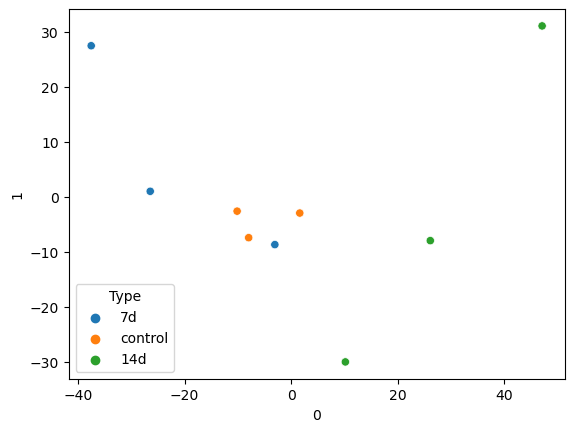

In [8]:
hue='Type'
sns.scatterplot(x=0, y=1, hue=hue, data=df_pca)

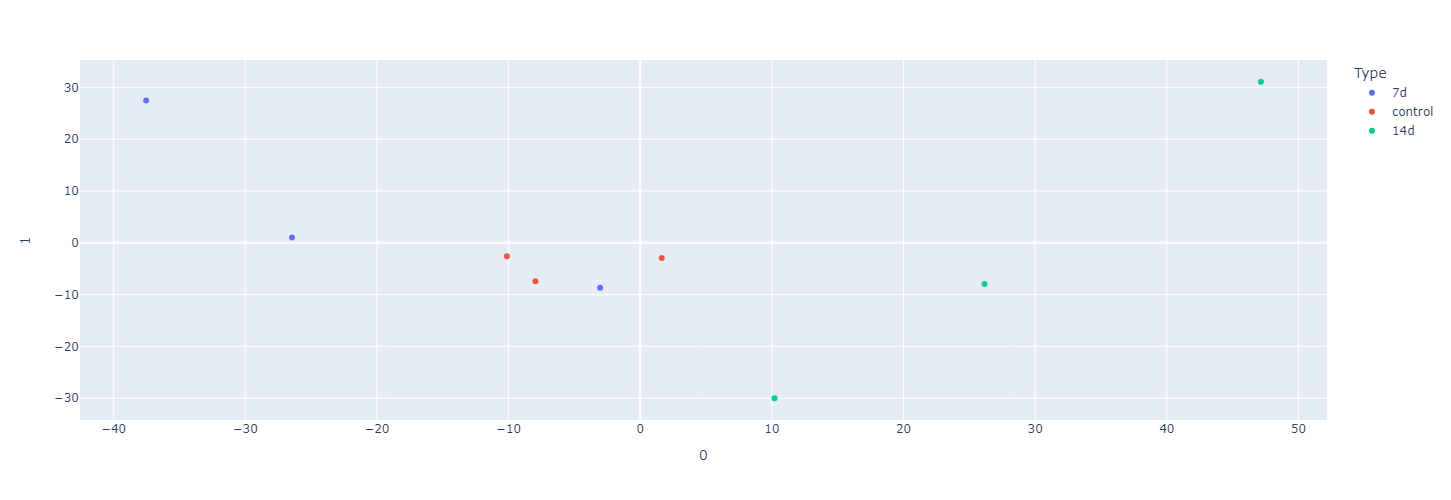

In [9]:
import plotly.express as px
fig = px.scatter(df_pca, x=0, y=1, color="Type",
                 hover_name='Type', width=650, height=500,
                 # color_discrete_map={'Upregulated': 'red','Downregulated': 'royalblue', 'Not-significant': 'gray'}
                )
fig.show()

In [15]:
meta

type
sample         
582     control
679     control
868     control
1247         7d
1249         7d
36           7d
838         14d
839         14d
840         14d

In [4]:
df = pd.read_csv(path+'res_c14_pc.csv', index_col=0)
df.index = df.index.map(ens2sym)
df['-log10(padj)'] = -np.log10(df['padj'])

In [5]:
# df.sort_values(['-log10(padj)','log2FoldChange'], ascending=False)#[[pv_col,logFC_col, gene_col]].values[:10]

In [6]:
# df

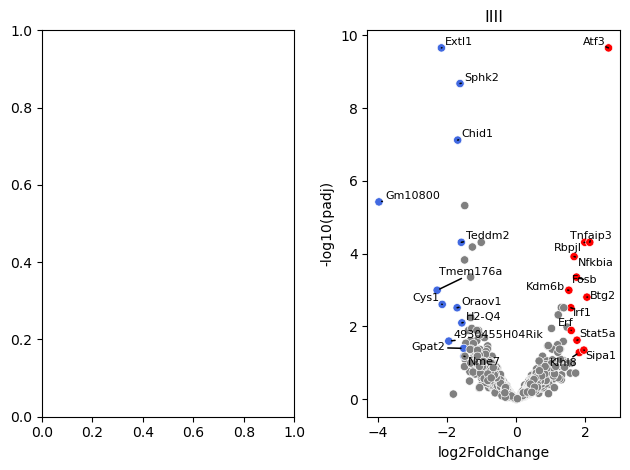

In [7]:
f, ax = plt.subplots(ncols=2)

plot.volcanoplot(df, ax=ax[1], use_adjusttext=True)
ax[1].set_title('llll')
ax[1].get_legend().remove()
f.tight_layout()

In [ ]:
plot.volcanoplot(df)

['7d' 'control' '14d']


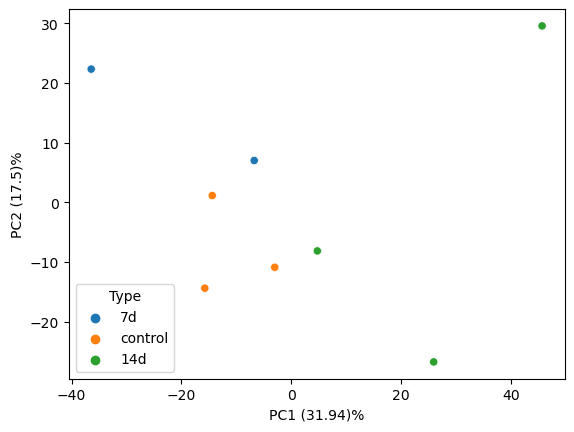

In [6]:
plot.pca(vst, meta)

In [9]:
dict(zip(meta.index.astype(str),meta.iloc[:,0]))

{582: 'control',
 679: 'control',
 868: 'control',
 1247: '7d',
 1249: '7d',
 36: '7d',
 838: '14d',
 839: '14d',
 840: '14d'}

In [10]:
l[:20]

[1, 2, 7, 4]

In [12]:
vst.index

Index(['1247', '1249', '582', '679', '838', '839', '840', '868'], dtype='object')

In [11]:
vst.index.map(dict(zip(meta.index,meta.iloc[:,0])))

Float64Index([nan, nan, nan, nan, nan, nan, nan, nan], dtype='float64')

## DFT

In [98]:
import seaborn as sns
import scipy.fft
from scipy import signal
import numpy as np

In [364]:
uA = np.array([int(i) for i in list('00000000000000000000000000000000001111')])
prop1 = len(uA[uA==0])/(len(uA))
prop2 = len(uA[uA==0])/(len(uA[uA==0])*(len(uA) - len(uA[uA==0]))*len(uA))
print('uA:',prop1, prop2)
uA2 = np.array([int(i) for i in list('00000000000000000000000000000000000001')])
# uA2 = np.array([int(i) for i in list('1111111000000')])
prop1 = len(uA2[uA2==0])/(len(uA2))
prop2 = len(uA2[uA2==0])/ (len(uA2[uA2==0])*len(uA2)*(len(uA2) - len(uA2[uA2==0])))
print('u2:',prop1, prop2)

FuA = scipy.fft.fft(uA)
FuA2 = scipy.fft.fft(uA2)

PS = np.absolute(FuA)**2
AS = np.angle(FuA)
AS[AS<0] = AS[AS<0]+2*np.pi

CPS = PS[1:].cumsum()
CAS = AS[1:].cumsum()

CPS_mu = CPS.mean()
CAS_mu = CAS.mean()

j = 1
N = len(uA)
Na = len(uA[uA==1])
CM_CPS_a = [(np.abs((CPS - CPS_mu))**j).sum()/( ((Na*(N-Na))**(j-1))*(N**j) ) for j in range(1,N)]
CM_CAS_a = [(np.abs((CAS - CAS_mu))**j).sum()/( ((Na*(N-Na))**(j-1))*(N**j) ) for j in range(1,N)]
print('uA cps:',CPS_mu, CM_CPS_a[:3])
# print('uA cas:',CAS_mu, CM_CAS_a[:3])

PS2 = np.absolute(FuA2)**2
AS2 = np.angle(FuA2)
AS2[AS2<0] = AS2[AS2<0]+2*np.pi

CPS2 = PS2[1:].cumsum()
CAS2 = AS2[1:].cumsum()

CPS_mu2 = CPS2.mean()
CAS_mu2 = CAS2.mean()

j = 1
N2 = len(uA2)
Na2 = len(uA2[uA2==1])
CM_CPS_a2 = [(np.abs((CPS2 - CPS_mu2))**j).sum()/( ((Na2*(N2-Na2))**(j-1))*(N2**j) ) for j in range(1,N2)]
CM_CAS_a2 = [(np.abs((CAS2 - CAS_mu2))**j).sum()/( ((Na2*(N2-Na2))**(j-1))*(N2**j) ) for j in range(1,N2)]
print('uA2 cps:',CPS_mu2, CM_CPS_a2[:3])
# print('uA2 cas:',CAS_mu, CM_CAS_a[:3])

uA: 0.8947368421052632 0.006578947368421052
u2: 0.9736842105263158 0.02631578947368421
uA cps: 69.83783783783784 [12.424948622781445, 0.08120431208469575, 0.0007456083514626148]
uA2 cps: 19.0 [9.0, 0.07894736842105263, 0.0007785167813617315]


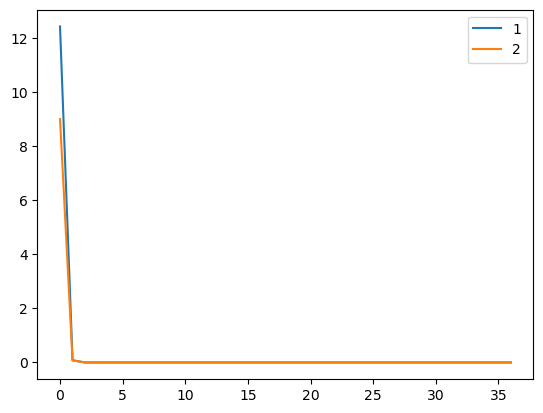

In [365]:
plt.plot(CM_CPS_a, label='1')
plt.plot(CM_CPS_a2, label='2')
plt.legend()

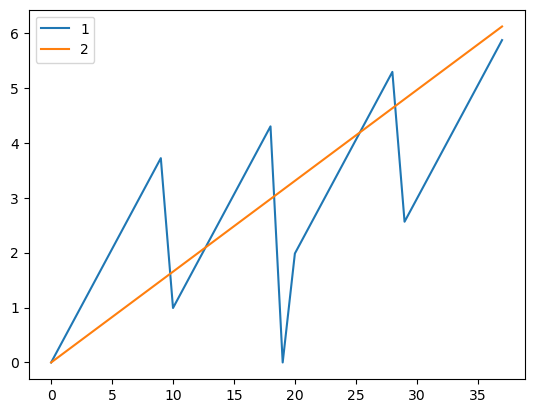

In [366]:
plt.plot(AS, label='1')
plt.plot(AS2, label='2')
plt.legend()

In [336]:
PS

array([1.00000000e+02, 9.03670262e+01, 6.57850117e+01, 3.66603947e+01,
       1.35767071e+01, 1.91259020e+00, 2.56961440e-01, 3.04587987e+00,
       5.00108861e+00, 4.14847392e+00, 1.77302608e+00, 1.47287297e-01,
       2.79463797e-01, 1.38145893e+00, 2.01786906e+00, 1.54933823e+00,
       5.44899431e-01, 4.67404964e-03, 3.23217037e-01, 1.00000000e+00,
       1.25514211e+00, 8.35694763e-01, 2.07670531e-01, 1.32857131e-02,
       4.01449881e-01, 9.10517525e-01, 9.81769089e-01, 5.45006260e-01,
       7.40965528e-02, 7.40965528e-02, 5.45006260e-01, 9.81769089e-01,
       9.10517525e-01, 4.01449881e-01, 1.32857131e-02, 2.07670531e-01,
       8.35694763e-01, 1.25514211e+00, 1.00000000e+00, 3.23217037e-01,
       4.67404964e-03, 5.44899431e-01, 1.54933823e+00, 2.01786906e+00,
       1.38145893e+00, 2.79463797e-01, 1.47287297e-01, 1.77302608e+00,
       4.14847392e+00, 5.00108861e+00, 3.04587987e+00, 2.56961440e-01,
       1.91259020e+00, 1.35767071e+01, 3.66603947e+01, 6.57850117e+01,
      

In [337]:
PS2

array([4.00000000e+02, 2.95876039e+02, 1.03772081e+02, 5.28649417e+00,
       9.42742422e+00, 1.85200783e+01, 4.83211508e+00, 7.41771437e-01,
       6.56570174e+00, 4.13703081e+00, 1.07583718e-02, 2.48587073e+00,
       3.28551618e+00, 4.09542469e-01, 7.63985140e-01, 2.37875767e+00,
       8.99861473e-01, 1.05459320e-01, 1.52089291e+00, 1.21766122e+00,
       1.34894734e-02, 8.04669604e-01, 1.29848882e+00, 2.16033608e-01,
       2.98717973e-01, 1.16121875e+00, 5.27447455e-01, 3.82080136e-02,
       8.71013057e-01, 8.12192587e-01, 2.01964943e-02, 5.18817963e-01,
       9.78138613e-01, 2.04326182e-01, 2.04326182e-01, 9.78138613e-01,
       5.18817963e-01, 2.01964943e-02, 8.12192587e-01, 8.71013057e-01,
       3.82080136e-02, 5.27447455e-01, 1.16121875e+00, 2.98717973e-01,
       2.16033608e-01, 1.29848882e+00, 8.04669604e-01, 1.34894734e-02,
       1.21766122e+00, 1.52089291e+00, 1.05459320e-01, 8.99861473e-01,
       2.37875767e+00, 7.63985140e-01, 4.09542469e-01, 3.28551618e+00,
      

In [279]:
FuA = scipy.fft.fft(uA)
FuA2 = scipy.fft.fft(uA2)

In [280]:
PS = np.absolute(FuA)**2
AS = np.angle(FuA)
AS[AS<0] = AS[AS<0]+2*np.pi

CPS = PS[1:].cumsum()
CAS = AS[1:].cumsum()

CPS_mu = CPS.mean()
CAS_mu = CAS.mean()

j = 1
N = len(uA)
Na = len(uA[uA==1])
CM_CPS_a = [(np.abs((CPS - CPS_mu))**j).sum()/( ((Na*(N-Na))**(j-1))*(N**j) ) for j in range(1,N)]
CM_CAS_a = [(np.abs((CAS - CAS_mu))**j).sum()/( ((Na*(N-Na))**(j-1))*(N**j) ) for j in range(1,N)]
print(CPS_mu, CM_CPS_a[:3])
print(CAS_mu, CM_CAS_a[:3])

16.25 [3.2816990146169456, 0.06623594516498468, 0.0018012385502220694]
24.085543677521752 [8.489116243428041, 0.26275020263659743, 0.009492038121149878]


In [281]:
PS = np.absolute(FuA2)**2
AS = np.angle(FuA2)
AS[AS<0] = AS[AS<0]+2*np.pi

CPS = PS[1:].cumsum()
CAS = AS[1:].cumsum()

CPS_mu = CPS.mean()
CAS_mu = CAS.mean()

j = 1
N = len(uA2)
Na = len(uA2[uA2==1])
CM_CPS_a = [(np.abs((CPS - CPS_mu))**j).sum()/( ((Na*(N-Na))**(j-1))*(N**j) ) for j in range(1,N)]
CM_CAS_a = [(np.abs((CAS - CAS_mu))**j).sum()/( ((Na*(N-Na))**(j-1))*(N**j) ) for j in range(1,N)]
print(CPS_mu, CM_CPS_a[:3])
print(CAS_mu, CM_CAS_a[:3])

6.5 [2.769230769230769, 0.07051282051282051, 0.0020197997269003187]
24.085543677521745 [8.675009299853473, 0.6845780830472895, 0.06383460086906166]


In [245]:
CPS = PS[1:].cumsum()
CAS = AS[1:].cumsum()
CPS, CAS

(array([17.20685727, 17.4720451 , 19.46020164, 19.77906602, 20.55378525,
        21.        , 21.44621475, 22.22093398, 22.53979836, 24.5279549 ,
        24.79314273, 42.        ]),
 array([ 4.83321947,  5.07488044, 10.14976088, 10.63308283, 15.94962424,
        16.67460716, 22.23280955, 23.19945344, 28.9993168 , 30.20762167,
        36.249146  , 37.69911184]))

In [237]:
CPS_mu = CPS.mean()
CAS_mu = CAS.mean()
CPS_mu, CAS_mu

(19.5, 23.03834612632515)

In [167]:
(CPS - CPS_mu)

array([-148.11428571, -148.11428571, -148.11428571, -140.62770789,
       -140.62770789, -140.62770789, -140.62770789, -114.18444958,
       -114.18444958, -114.18444958, -114.18444958,  -66.18444958,
        -66.18444958,  -66.18444958,  -66.18444958,   -4.11428571,
         -4.11428571,   -4.11428571,   -4.11428571,   57.95587815,
         57.95587815,   57.95587815,   57.95587815,  105.95587815,
        105.95587815,  105.95587815,  105.95587815,  132.39913647,
        132.39913647,  132.39913647,  132.39913647,  139.88571429,
        139.88571429,  139.88571429,  139.88571429])

In [186]:
j = 1
N = len(uA)
Na = len(uA[uA==1])
CM_CPS_a = [(np.abs((CPS - CPS_mu))**j).sum()/( ((Na*(N-Na))**(j-1))*(N**j) ) for j in range(1,N)]
CM_CAS_a = [(np.abs((CAS - CAS_mu))**j).sum()/( ((Na*(N-Na))**(j-1))*(N**j) ) for j in range(1,N)]
CM_CPS_a[:3]#, CM_CAS_a

[96.93257934510277, 1.1289867007015684, 0.013891198256811087]

In [187]:
j = 1
N = len(uG)
Na = len(uG[uG==1])
CM_CPS_a = [(np.abs((CPS - CPS_mu))**j).sum()/( ((Na*(N-Na))**(j-1))*(N**j) ) for j in range(1,N)]
CM_CAS_a = [(np.abs((CAS - CAS_mu))**j).sum()/( ((Na*(N-Na))**(j-1))*(N**j) ) for j in range(1,N)]
CM_CPS_a[:3]#, CM_CAS_a

[96.93257934510277, 1.451554329473445, 0.022963001200034652]

In [124]:
range(len(uA))

range(0, 9)

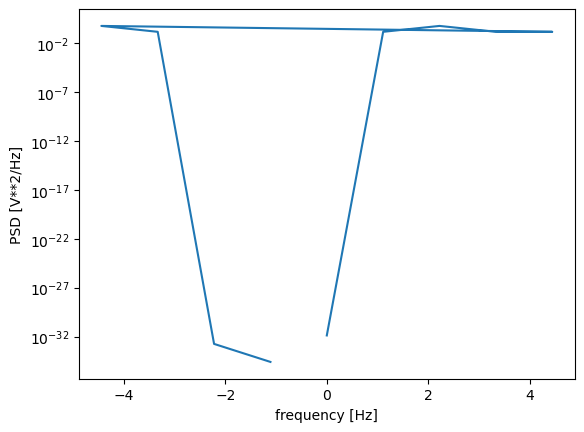

In [57]:
import matplotlib.pyplot as plt

plt.semilogy(f, S)
# plt.ylim([1e-7, 1e2])
# plt.xlim([0,100])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

# Microarrays

In [6]:
import os
import time
import numpy as np
import pandas as pd
import anndata as ad
from gotx import *#as gt
import pingouin as pg

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression, mutual_info_regression
from umap import UMAP
import hdbscan

import matplotlib.pyplot as plt
import seaborn as sns

/mnt/d/DS_wsl_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'hdbscan'

In [ ]:
path='/mnt/d/postransplant_cristian_colab/microarrays/'

## Import microarrays expressions

GSE14346
GSE15296
GSE46474


/tmp/ipykernel_1385064/4153571887.py:29: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  adata.obs['ar'] = np.where(adata.obs['source_name_ch1'].str.contains('(AR)'), 1, 0)#'GSE46474'


GSE129166
GSE120397


/mnt/d/postransplant_cristian_colab/gotx_env/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


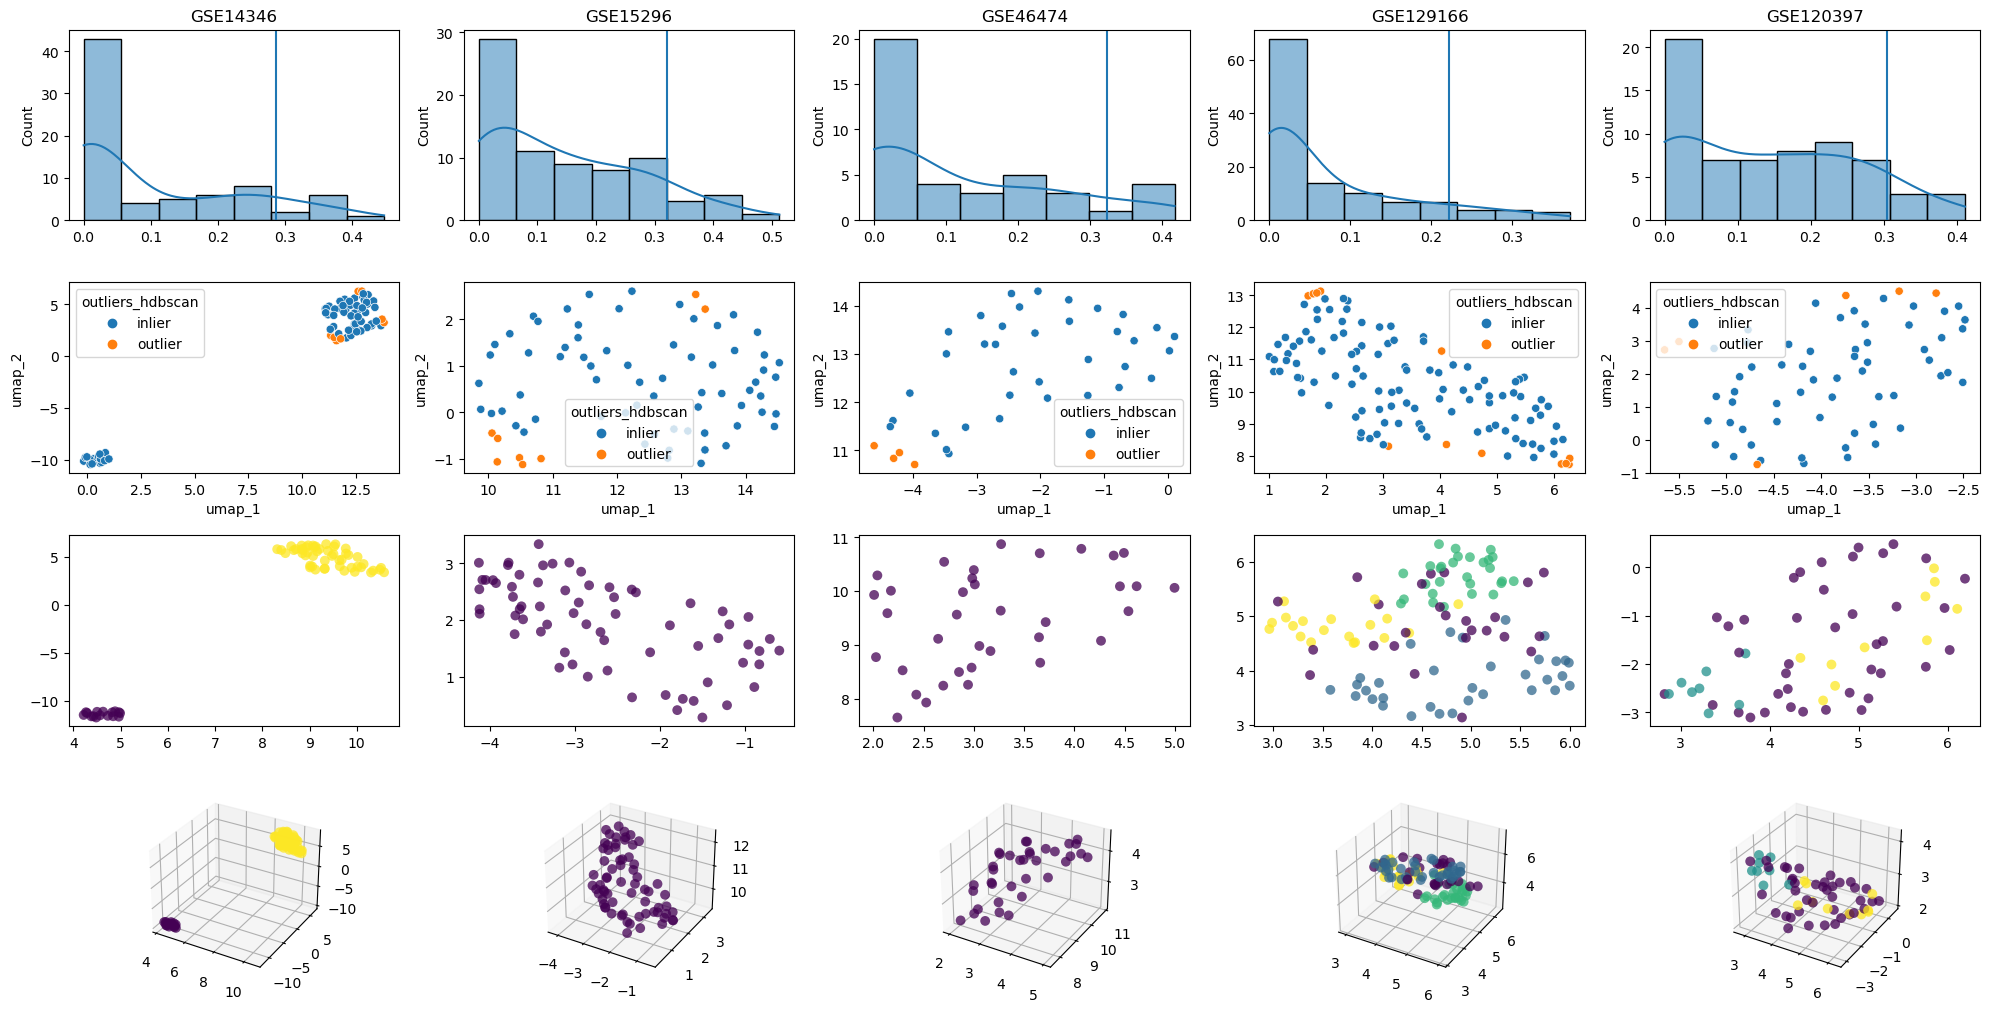

In [14]:
fig = plt.figure(figsize=(20,10))
rows = 4
cols = 5

gse_list = ['GSE14346', 'GSE15296', 'GSE46474', 'GSE129166', 'GSE120397'] 
size_list = [25,18,15,30,10]

times = dict()
biomarkers = []
aux_adata = dict()
i = 1

exclude_outliers = True

for gse,sample_size in zip(gse_list,size_list):
    print(gse)
    
# gse = gse_list[3]
    counts = os.path.join(path,gse+'_norm_exprs.tsv')
    obs = os.path.join(path,gse+'_meta.tsv')
    var = os.path.join(path,gse+'_mygene_translation.tsv')

    adata = read.from_oligo(counts, obs=obs, var=var)
    if gse == 'GSE14346':
        adata.obs['ar'] = np.where(adata.obs['disease state:ch1'].str.startswith('AR'), 1, 0)#'GSE14346'
    elif gse == 'GSE15296':
        adata.obs['ar'] = np.where(adata.obs['phenotype:ch1'].str.contains('Acute Kidney Rejection'), 1, 0)#'GSE15296'
    elif gse == 'GSE46474':
        adata.obs['ar'] = np.where(adata.obs['source_name_ch1'].str.contains('(AR)'), 1, 0)#'GSE46474'
    elif gse == 'GSE129166':
        adata.obs['ar'] = np.where(( adata.obs['characteristics_ch1.1'].str.endswith('1') | adata.obs['characteristics_ch1.2'].str.endswith('1')), 1, 0)#'GSE129166'
    elif gse == 'GSE120397':
        adata.obs['ar'] = np.where(adata.obs['characteristics_ch1.1'].str.endswith('Yes'), 1, 0)#'GSE46474'
        
    X = adata.X
    y = adata.obs.ar.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
    
    reducer = UMAP(init='spectral', n_components=2, random_state=42)
    embedding = reducer.fit_transform(X)
    adata.obs[['umap_1', 'umap_2']] = embedding
    
    clusterer = hdbscan.HDBSCAN(min_cluster_size=15).fit(embedding)
    
    threshold = np.quantile(clusterer.outlier_scores_, q=.9)
    outliers = np.where(clusterer.outlier_scores_ > threshold)
    adata.obs['outliers_hdbscan'] = np.where(clusterer.outlier_scores_ > threshold, 'outlier', 'inlier') 
    
    ax = fig.add_subplot(rows,cols,(i))
    ax.set_title(gse)
    sns.histplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], kde=True, ax=ax)
    ax.axvline(threshold)       
    
    ax = fig.add_subplot(rows,cols,(i+5))
    hue_order = ['inlier', 'outlier']
    sns.scatterplot(x='umap_1', y='umap_2', hue='outliers_hdbscan', hue_order=hue_order, data=adata.obs, ax=ax)
    
    # exclude outliers
    if exclude_outliers:
        X = adata[adata.obs.outliers_hdbscan=='inlier',:].X
        y = adata[adata.obs.outliers_hdbscan=='inlier',:].obs.ar.values
    
    reducer = UMAP(n_components=3, random_state=42)
    embedding = reducer.fit_transform(X)
    # adata.obs[['umap_1', 'umap_2']] = embedding

    clusterer = hdbscan.HDBSCAN(min_cluster_size=8)
    clusterer.fit(embedding)
    # adata.obs['labels_hdbscan'] = adata.obs['outliers_hdbscan']
    # exclude outliers
    if exclude_outliers:
        adata.obs.loc[adata.obs.outliers_hdbscan=='inlier','labels_hdbscan'] = clusterer.labels_
    else:
        adata.obs.loc[:,'labels_hdbscan'] = clusterer.labels_
    # adata[adata.obs.outliers_hdbscan=='inlier',:].obs['labels_hdbscan'] = 
    
    ax = fig.add_subplot(rows,cols,(i+10))#, projection='3d')
    ax.scatter(embedding[:, 0], embedding[:, 1], s=50, linewidth=0, c=clusterer.labels_, alpha=0.75)
    
    ax = fig.add_subplot(rows,cols,(i+15), projection='3d')
    ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], s=50, linewidth=0, c=clusterer.labels_, alpha=0.75)
    # ax.scatter(embedding[:, 0], embedding[:, 1], s=50, linewidth=0, c=clusterer.labels_, alpha=0.75)
    # ax.scatter(*data[outliers].T, s=50, linewidth=0, c='red', alpha=0.5)
    
    # if i > 1:
    #     ax.legend().remove()
    # ax.scatter(*data.T, s=50, linewidth=0, c='gray', alpha=0.25)
    # ax.scatter(*data[outliers].T, s=50, linewidth=0, c='red', alpha=0.5)
    
#     clf = IsolationForest(max_samples='auto', random_state=0, bootstrap=False)
#     clf.fit(X_train)
#     adata.obs['raw_inlier'] = clf.predict(X)
    
#     # X = adata[adata.obs.raw_inlier==1,:].X
#     # y = adata[adata.obs.raw_inlier==1,:].obs.ar.values
#     reducer = UMAP(init='spectral', n_components=2)
#     embedding = reducer.fit_transform(X)
#     # adata.obs[['umap_1', 'umap_2']] = embedding
#     X_train, X_test, y_train, y_test = train_test_split(embedding, y, stratify=y, random_state=42)
    
#     clf = IsolationForest(max_samples='auto', random_state=0, bootstrap=False)
#     clf.fit(X_train)
#     # adata.obs['umap_inlier'] = clf.predict(embedding)
    
    adata.obs.loc[:,'feat_group'] = gse + '_' + adata.obs['labels_hdbscan'].astype(str)
    adata.var.columns = ['symbol', 'status']
    # adata.var = adata.var.reset_index().set_index('symbol')    
    aux_adata[gse] = adata
    
#     ax = fig.add_subplot(rows,cols,(i+5))
#     disp = DecisionBoundaryDisplay.from_estimator(
#     clf,
#     embedding,
#     response_method="decision_function",#"predict",#
#     alpha=0.5,
#         # bootstrap=True,
#         ax=ax
#     )
    
#     disp.ax_.scatter(embedding[:, 0], embedding[:, 1], c=clf.predict(embedding),  s=20, edgecolor="k")
#     disp.ax_.set_title(gse)
# #     
#     ax = fig.add_subplot(rows,cols,(i+5))
#     disp = DecisionBoundaryDisplay.from_estimator(
#     clf,
#     embedding,
#     response_method="predict",#"decision_function",#
#     alpha=0.5,
#         ax=ax,
#         # bootstrap=True
#     )
    
#     disp.ax_.scatter(embedding[:, 0], embedding[:, 1], c=clf.predict(embedding), s=20, edgecolor="k")
#     # sns.scatterplot(x='umap_1', y='umap_2', hue='umap_inlier', style='ar', data=aux_adata[gse].obs, ax=ax)
#     disp.ax_.set_title(gse)
    
#     plt.axis("square")
    
    i+=1
        
    # adata.obs.to_csv( os.path.join(path,gse+'_meta_ar_col.tsv'), sep='\t' )

#     adata.var.columns = ['symbol', 'status']
#     adata.var = adata.var.reset_index().set_index('symbol')
    
#     rf = RandomForestClassifier(n_jobs=-1, n_estimators=500, class_weight='balanced', max_depth=20, criterion="gini")
    
#     t1 = time.time()
#     genes = gene_selection.set_boruta_selection(adata[:,adata.var['status']=='ok'], rf, class_col='ar', random_state=42, sample_size=sample_size)
#     t2 = time.time()
#     times[gse] = t2-t1
#     aux = []
#     for g in genes:
#         aux.extend(g['genes'])
#         # print(len(g['genes']))
        
#     biomarkers.append(pd.DataFrame(np.unique(np.array(aux), return_counts=True)).T.set_index(0))
#     biomarkers[-1].columns = [gse]

# adata[:,adata.var['status']=='ok']
fig.tight_layout()

In [15]:
data = pd.DataFrame(aux_adata['GSE14346'].X,
                    columns=aux_adata['GSE14346'].var.index)

In [23]:
import itertools
from scipy.stats import pearsonr

In [34]:
aux_adata['GSE14346'].var.loc['1007_s_at',:]

symbol    MIR4640
status         ok
Name: 1007_s_at, dtype: object

In [49]:
aux_adata['GSE14346'][:,(aux_adata['GSE14346'].var['status']=='ok') & (aux_adata['GSE14346'].var.index=='1007_s_at')].X.reshape(1,-1)[0]

ArrayView([5.3311434, 4.0439644, 5.7545476, 5.8219805, 3.9726505,
           5.966675 , 3.6340349, 6.017574 , 5.689102 , 5.7966537,
           5.647722 , 5.7934885, 5.661862 , 5.6054025, 5.7970004,
           4.1731596, 5.4044065, 5.814816 , 5.6525087, 5.728086 ,
           5.355925 , 4.575788 , 5.0019164, 5.5209966, 5.2879357,
           5.449096 , 4.423071 , 5.87218  , 6.2046423, 5.6355853,
           6.195477 , 5.744545 , 5.5334773, 6.071653 , 5.6852107,
           4.909623 , 6.1590157, 5.9023976, 5.8679276, 5.3412313,
           5.6779585, 5.7431183, 5.9615684, 3.5815413, 5.7110033,
           6.055724 , 5.5744257, 5.8316684, 5.775972 , 5.731891 ,
           5.845538 , 5.9255233, 5.375097 , 5.8431344, 5.361789 ,
           4.4967284, 5.3245025, 5.8881874, 4.4149632, 4.349524 ,
           4.382371 , 5.615727 , 4.986798 , 5.638248 , 5.525135 ,
           5.818199 , 5.611425 , 6.152231 , 5.7195783, 5.7554865,
           5.9257936, 5.4590697, 5.512342 , 3.6218402, 4.5271206],
         

In [76]:
gse_list = ['GSE14346', 'GSE15296', 'GSE46474', 'GSE129166', 'GSE120397'] 
for gse in gse_list:
    # j = 0
    with open('/mnt/d/GoTx_Folder/tests/'+gse+'_r_pv_high_corr.csv', 'w') as file:
        file.write('gene_1,gene_2,statistic,pvalue\n')

    gene_comb = itertools.combinations(aux_adata[gse].var[aux_adata[gse].var['status']=='ok'].index, 2)
    r_09_list = []
    for xy in gene_comb:
        x = aux_adata[gse][:,(aux_adata[gse].var['status']=='ok') & (aux_adata[gse].var.index==xy[0])].X.reshape(1,-1)[0]
        y = aux_adata[gse][:,(aux_adata[gse].var['status']=='ok') & (aux_adata[gse].var.index==xy[1])].X.reshape(1,-1)[0]

        statistic, pvalue = pearsonr(x,y)

        if (pvalue <= .05) and (statistic >= .9):
            with open('/mnt/d/GoTx_Folder/tests/'+gse+'_r_pv_high_corr.csv', 'a') as file:
                file.write(str(xy[0])+','+str(xy[1])+','+str(statistic)+','+str(pvalue)+'\n')

        # if j >5:
        #     break
        # j+=1

KeyboardInterrupt: 

# Feature Selection 
## exclude_outliers = False

In [13]:
aux = []
for gse in aux_adata.keys():
    for l in aux_adata[gse].obs.feat_group.unique():#[ ~np.isnan(aux_adata[gse].obs.labels_hdbscan.unique()) ]:
        aux.append(aux_adata[gse].obs.loc[aux_adata[gse].obs.feat_group==l,:].groupby('ar').count()[['feat_group']])
        aux[-1].columns=[l]

In [8]:
pd.concat(aux, axis=1)

GSE14346_1.0  GSE14346_0.0  GSE14346_nan  GSE15296_-1.0  GSE15296_nan  \
ar                                                                          
0             24             9             4             23             1   
1             27             7             4             44             7   

    GSE46474_-1.0  GSE46474_nan  GSE129166_2.0  GSE129166_-1.0  GSE129166_0.0  \
ar                                                                              
0              16           4.0             14              18             17   
1              20           NaN              5               7             16   

    GSE129166_nan  GSE129166_1.0  GSE120397_1.0  GSE120397_-1.0  \
ar                                                                
0               5             20           10.0              36   
1               7              8            NaN               4   

    GSE120397_0.0  GSE120397_nan  
ar                                
0               6              1  
1               2              6

## exclude_outliers = True

In [14]:
pd.concat(aux, axis=1)[[c for c in pd.concat(aux, axis=1) if 'nan' not in c]].dropna(axis=1) #dropna to take off the group with only one class

GSE14346_1.0  GSE14346_0.0  GSE15296_-1.0  GSE46474_-1.0  GSE129166_2.0  \
ar                                                                            
0             24             9             23             16             14   
1             27             7             44             20              5   

    GSE129166_-1.0  GSE129166_0.0  GSE129166_1.0  GSE120397_-1.0  \
ar                                                                 
0               18             17             20              36   
1                7             16              8               4   

    GSE120397_0.0  
ar                 
0               6  
1               2

In [15]:
df = pd.concat(aux, axis=1)[[c for c in pd.concat(aux, axis=1) if 'nan' not in c]].dropna(axis=1)
df.div(df.max()).min()

GSE14346_1.0      0.888889
GSE14346_0.0      0.777778
GSE15296_-1.0     0.522727
GSE46474_-1.0     0.800000
GSE129166_2.0     0.357143
GSE129166_-1.0    0.388889
GSE129166_0.0     0.941176
GSE129166_1.0     0.400000
GSE120397_-1.0    0.111111
GSE120397_0.0     0.333333
dtype: float64

In [16]:
balanced_dict = dict(zip(df.columns, np.where(df.div(df.max()).min()>=.75, 'balanced', 'unbalanced')))
balanced_dict

{'GSE14346_1.0': 'balanced',
 'GSE14346_0.0': 'balanced',
 'GSE15296_-1.0': 'unbalanced',
 'GSE46474_-1.0': 'balanced',
 'GSE129166_2.0': 'unbalanced',
 'GSE129166_-1.0': 'unbalanced',
 'GSE129166_0.0': 'balanced',
 'GSE129166_1.0': 'unbalanced',
 'GSE120397_-1.0': 'unbalanced',
 'GSE120397_0.0': 'unbalanced'}

# Boruta selection

In [117]:
biomarkers = []
times = dict()

t1_ = time.time()
gse_list = ['GSE14346', 'GSE15296', 'GSE46474', 'GSE129166', 'GSE120397'] 
size_list = [25,18,15,30,10]

for gse,sample_size in zip(gse_list,size_list):
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=500, class_weight='balanced', max_depth=20, criterion="gini")
    
    t1 = time.time()
    genes = gene_selection.set_boruta_selection(aux_adata[gse][:,aux_adata[gse].var['status']=='ok'], rf, class_col='ar', random_state=42, sample_size=sample_size)
    t2 = time.time()
    times[gse] = t2-t1
    aux = []
    for g in genes:
        aux.extend(g['genes'])
        # print(len(g['genes']))
        
    biomarkers.append(pd.DataFrame(np.unique(np.array(aux), return_counts=True)).T.set_index(0))
    biomarkers[-1].columns = [gse]
    del(genes)
    
for gse in aux_adata.keys():       
    for fg in [c for c in aux_adata[gse].obs.feat_group.unique() if 'nan' not in c and c in balanced_dict.keys()]:
        if balanced_dict[fg] == 'unbalanced':
            t1 = time.time()
            rf = RandomForestClassifier(n_jobs=-1, n_estimators=500, class_weight='balanced_subsample', max_depth=20, criterion="gini")
            genes = gene_selection.set_boruta_selection(aux_adata[gse][aux_adata[gse].obs['feat_group']==fg,
                                                                       aux_adata[gse].var['status']=='ok'], 
                                                        rf, class_col='ar', random_state=42, sample_size=False, n_set=5)
            t2 = time.time()
            times[fg] = t2-t1
        else:
            t1 = time.time()
            rf = RandomForestClassifier(n_jobs=-1, n_estimators=500, class_weight='balanced', max_depth=20, criterion="gini")
            genes = [gene_selection.boruta_selection(aux_adata[gse][aux_adata[gse].obs['feat_group']==fg,
                                                                    aux_adata[gse].var['status']=='ok'],
                                                     rf, class_col='ar', random_state=42)]
            t2 = time.time()
            times[fg] = t2-t1
        aux = []
        for g in genes:
            aux.extend(g['genes'])
            # print(len(g['genes']))

        biomarkers.append(pd.DataFrame(np.unique(np.array(aux), return_counts=True)).T.set_index(0))
        biomarkers[-1].columns = [fg]
        
        del(genes)
print(time.time()-t1_, '(s) -', (time.time()-t1_)/60, '(min)')

1574.0487487316132 (s) - 26.234145816167196 (min)


In [120]:
hm = pd.concat(biomarkers, axis=1).fillna(0)
hm_f = (hm > 0).astype(int)
hm_f[hm_f.sum(axis=1)>0]

GSE14346  GSE15296  GSE46474  GSE129166  GSE120397  \
0                                                                  
1553220_at           1         0         0          0          0   
1555058_a_at         1         0         0          0          0   
1556896_at           1         0         0          0          0   
1557444_at           1         0         0          0          0   
1561615_s_at         1         0         0          0          0   
...                ...       ...       ...        ...        ...   
3094611              0         0         0          0          0   
3693214              0         0         0          0          0   
3748449              0         0         0          0          0   
3833183              0         0         0          0          0   
4000155              0         0         0          0          0   

              GSE14346_1.0  GSE14346_0.0  GSE15296_-1.0  GSE46474_-1.0  \
0                                                                        
1553220_at               0             0              0              0   
1555058_a_at             0             0              0              0   
1556896_at               0             0              0              0   
1557444_at               0             0              0              0   
1561615_s_at             1             0              0              0   
...                    ...           ...            ...            ...   
3094611                  0             0              0              0   
3693214                  0             0              0              0   
3748449                  0             0              0              0   
3833183                  0             0              0              0   
4000155                  0             0              0              0   

              GSE129166_2.0  GSE129166_-1.0  GSE129166_0.0  GSE129166_1.0  \
0                                                                           
1553220_at                0               0              0              0   
1555058_a_at              0               0              0              0   
1556896_at                0               0              0              0   
1557444_at                0               0              0              0   
1561615_s_at              0               0              0              0   
...                     ...             ...            ...            ...   
3094611                   0               0              0              0   
3693214                   0               0              0              0   
3748449                   0               0              0              0   
3833183                   0               0              0              0   
4000155                   0               0              0              0   

              GSE120397_-1.0  GSE120397_0.0  
0                                            
1553220_at                 0              0  
1555058_a_at               0              0  
1556896_at                 0              0  
1557444_at                 0              0  
1561615_s_at               0              0  
...                      ...            ...  
3094611                    1              0  
3693214                    1              0  
3748449                    1              0  
3833183                    1              0  
4000155                    1              0  

[232 rows x 15 columns]

<AxesSubplot:xlabel='0'>

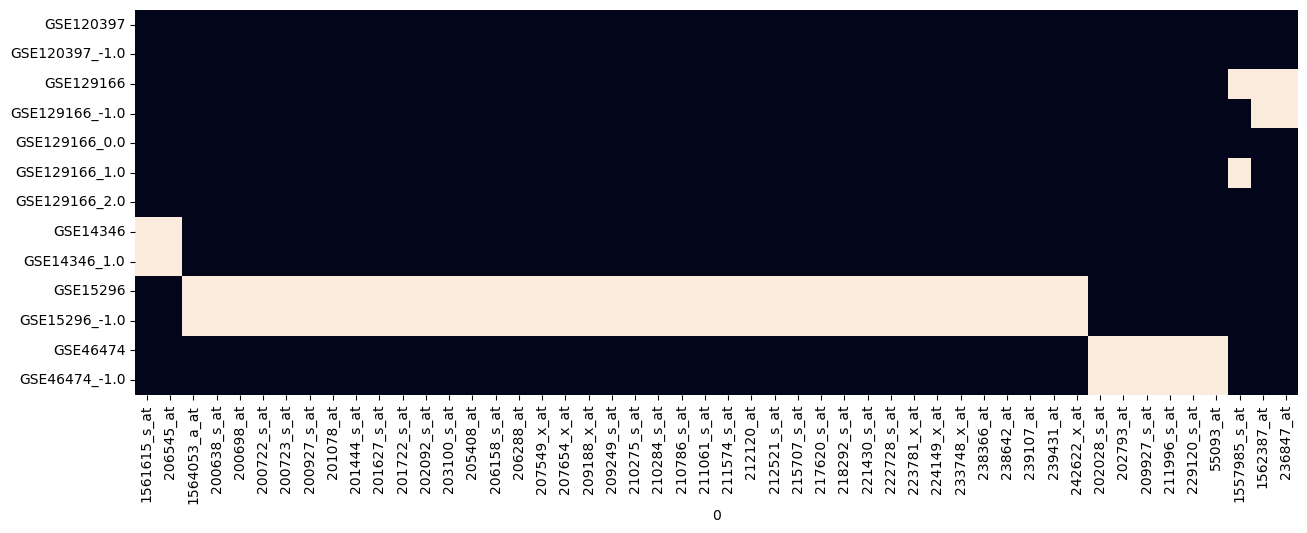

In [121]:
fig = plt.figure(figsize=(15,5))
# cols = hm_f[hm_f.sum(axis=1)>0].T[hm_f.sum(axis=0)>0].sum().sort_values(ascending=False).index
cols = (hm_f[hm_f.sum(axis=1)>0].T[hm_f.sum(axis=0)>0].sum()>1).values
sns.heatmap(hm_f[hm_f.sum(axis=1)>0].T[hm_f.sum(axis=0)>0].sort_index().loc[:,cols], cbar=False)

232


<AxesSubplot:xlabel='0'>

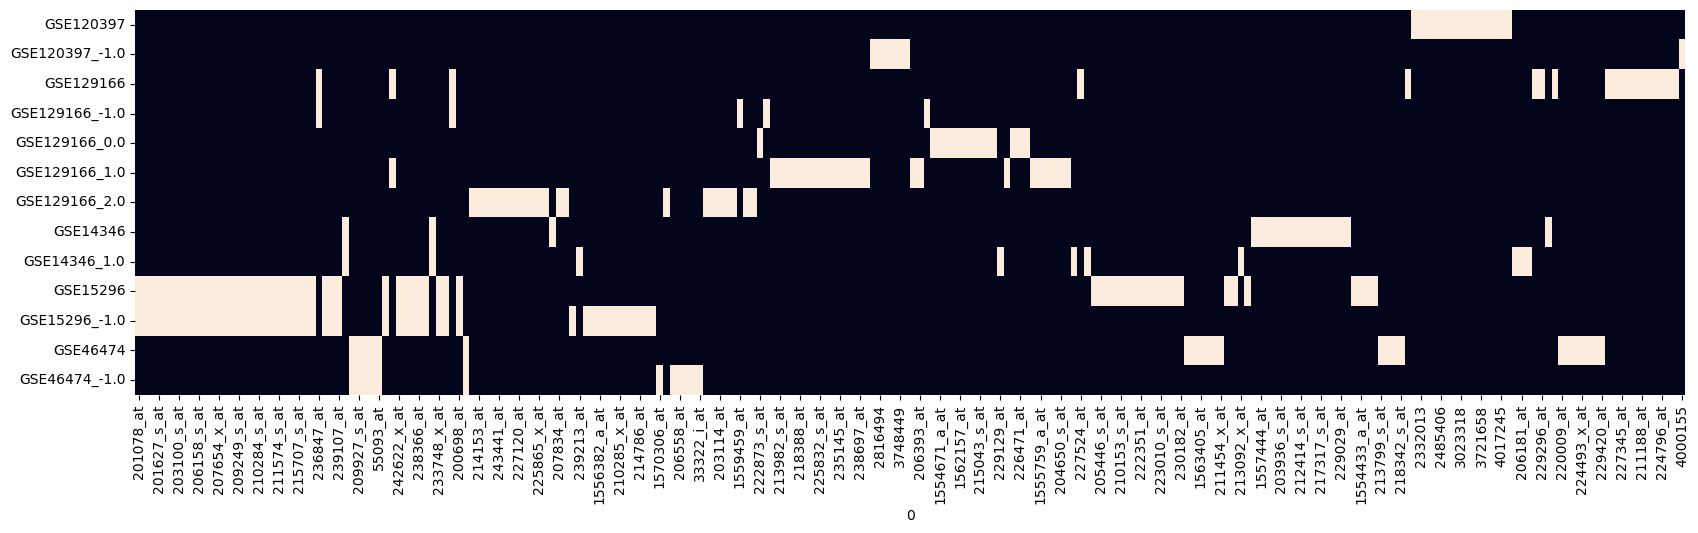

In [122]:
fig = plt.figure(figsize=(20,5))
cols = hm_f[hm_f.sum(axis=1)>0].T[hm_f.sum(axis=0)>0].sum().sort_values(ascending=False).index
print(len(cols))
sns.heatmap(hm_f[hm_f.sum(axis=1)>0].T[hm_f.sum(axis=0)>0].sort_index().loc[:,cols], cbar=False)

In [105]:
print(aux_adata.keys())
aux_adata['GSE14346'][:,aux_adata['GSE14346'].var.index.isin(cols)]

dict_keys(['GSE14346', 'GSE15296', 'GSE46474', 'GSE129166', 'GSE120397'])


View of AnnData object with n_obs × n_vars = 75 × 682
    obs: 'title', 'geo_accession', 'status', 'submission_date', 'last_update_date', 'type', 'channel_count', 'source_name_ch1', 'organism_ch1', 'characteristics_ch1', 'characteristics_ch1.1', 'molecule_ch1', 'extract_protocol_ch1', 'label_ch1', 'label_protocol_ch1', 'taxid_ch1', 'hyb_protocol', 'scan_protocol', 'description', 'data_processing', 'platform_id', 'contact_name', 'contact_email', 'contact_phone', 'contact_fax', 'contact_laboratory', 'contact_department', 'contact_institute', 'contact_address', 'contact_city', 'contact_state', 'contact_zip/postal_code', 'contact_country', 'supplementary_file', 'data_row_count', 'disease state:ch1', 'ar', 'umap_1', 'umap_2', 'outliers_hdbscan', 'labels_hdbscan', 'feat_group'
    var: 'index', 'status'

In [129]:
cols

Index(['201078_at', '200927_s_at', '201444_s_at', '201627_s_at', '201722_s_at',
       '202092_s_at', '203100_s_at', '205408_at', '224149_x_at', '206158_s_at',
       ...
       '227345_at', '208511_at', '210313_at', '211188_at', '211961_s_at',
       '220753_s_at', '224796_at', '225632_s_at', '225962_at', '4000155'],
      dtype='object', name=0, length=232)

In [150]:
data = pd.DataFrame(aux_adata['GSE14346'][:,aux_adata['GSE14346'].var.index.isin(cols)].X,
                    columns=aux_adata['GSE14346'][:,aux_adata['GSE14346'].var.index.isin(cols)].var.index)

In [238]:
data = pd.DataFrame(aux_adata['GSE14346'].X,
                    columns=aux_adata['GSE14346'].var.index)

In [11]:
data

NameError: name 'data' is not defined

In [1]:
# list(itertools.combinations(aux_adata['GSE14346'].var.index, 2))

In [7]:
mi = mutual_info_regression(aux_adata['GSE14346'].X, aux_adata['GSE14346'].obs.ar)

In [10]:
mi.shape

(54675,)

In [ ]:
t1 = time.time()
data_p = pg.pairwise_corr(data, method='pearson', padjust='bonf')
print((time.time()-t1)/60)

In [160]:
data_p.X.unique().shape

(209,)

In [226]:
data_p[(data_p['p-corr']<=0.05) & (data_p['r']>=.85)].sort_values('r', ascending=False)

X            Y   method alternative   n         r  \
14599   209813_x_at  215806_x_at  pearson   two-sided  75  0.987702   
8386    202028_s_at    229420_at  pearson   two-sided  75  0.987670   
12791   207549_x_at  211574_s_at  pearson   two-sided  75  0.961091   
2231   1554565_x_at    238642_at  pearson   two-sided  75  0.960766   
17654     214153_at    238642_at  pearson   two-sided  75  0.959979   
...             ...          ...      ...         ...  ..       ...   
9189      203038_at  228661_s_at  pearson   two-sided  75  0.850806   
18931   218122_s_at    239107_at  pearson   two-sided  75  0.850770   
21242     227540_at    228560_at  pearson   two-sided  75  0.850241   
5731      200064_at  212414_s_at  pearson   two-sided  75  0.850236   
21304     228560_at    239107_at  pearson   two-sided  75  0.850215   

              CI95%         p-unc        p-corr p-adjust       BF10  power  
14599  [0.98, 0.99]  1.389546e-60  3.049358e-56     bonf  2.538e+56    1.0  
8386   [0.98, 0.99]  1.526749e-60  3.350452e-56     bonf  2.316e+56    1.0  
12791  [0.94, 0.98]  1.580258e-42  3.467877e-38     bonf   7.13e+38    1.0  
2231   [0.94, 0.98]  2.127694e-42  4.669226e-38     bonf   5.34e+38    1.0  
17654  [0.94, 0.97]  4.333660e-42  9.510216e-38     bonf  2.675e+38    1.0  
...             ...           ...           ...      ...        ...    ...  
9189    [0.77, 0.9]  4.339143e-22  9.522249e-18     bonf  1.044e+19    1.0  
18931   [0.77, 0.9]  4.374330e-22  9.599466e-18     bonf  1.036e+19    1.0  
21242   [0.77, 0.9]  4.928695e-22  1.081602e-17     bonf  9.228e+18    1.0  
5731    [0.77, 0.9]  4.934515e-22  1.082879e-17     bonf  9.217e+18    1.0  
21304   [0.77, 0.9]  4.957403e-22  1.087902e-17     bonf  9.176e+18    1.0  

[189 rows x 12 columns]

In [227]:
data_p[(data_p['p-corr']<=0.05) & (data_p['r']>=.85)].sort_values('r', ascending=False).Y.unique()#values

array(['215806_x_at', '229420_at', '211574_s_at', '238642_at',
       '1555759_a_at', '204655_at', '202028_s_at', '209188_x_at',
       '239107_at', '214153_at', '238366_at', '227540_at', '229129_at',
       '1554036_at', '203100_s_at', '229120_s_at', '232342_at',
       '208853_s_at', '202164_s_at', '216322_at', '214876_s_at',
       '207654_x_at', '214055_x_at', '227345_at', '238058_at',
       '201722_s_at', '212871_at', '208610_s_at', '228661_s_at',
       '206158_s_at', '209348_s_at', '240513_at', '203014_x_at',
       '239213_at', '211454_x_at', '210275_s_at', '222873_s_at',
       '210284_s_at', '213088_s_at', '214449_s_at', '239237_at',
       '201444_s_at', '207549_x_at', '215043_s_at', '203076_s_at',
       '213982_s_at', '216503_s_at', '228774_at', '213092_x_at',
       '217317_s_at', '228707_at', '228560_at', '212414_s_at'],
      dtype=object)

In [230]:
# data_p[(data_p.Y=='209813_x_at') & (data_p.X=='215806_x_at')]
data_p[(data_p['p-corr']<=0.05) & (data_p['r']>=.85)].sort_values('r', ascending=False)[data_p.X=='209813_x_at']

/tmp/ipykernel_30932/4174276741.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_p[(data_p['p-corr']<=0.05) & (data_p['r']>=.85)].sort_values('r', ascending=False)[data_p.X=='209813_x_at']


X            Y   method alternative   n         r  \
14599  209813_x_at  215806_x_at  pearson   two-sided  75  0.987702   
14676  209813_x_at    239237_at  pearson   two-sided  75  0.872683   

              CI95%         p-unc        p-corr p-adjust       BF10  power  
14599  [0.98, 0.99]  1.389546e-60  3.049358e-56     bonf  2.538e+56    1.0  
14676  [0.81, 0.92]  1.992767e-24  4.373127e-20     bonf   1.92e+21    1.0

In [207]:
set(data_p[(data_p['p-corr']<=0.05) & (data_p['r']>=.9)].X.values).union(set(data_p[(data_p['p-corr']<=0.05) & (data_p['r']>=.9)].Y.values))

{'1405_i_at',
 '1552481_s_at',
 '1554036_at',
 '1554565_x_at',
 '1555759_a_at',
 '200698_at',
 '200927_s_at',
 '201722_s_at',
 '202028_s_at',
 '202164_s_at',
 '203014_x_at',
 '203100_s_at',
 '204655_at',
 '206158_s_at',
 '207549_x_at',
 '207654_x_at',
 '208610_s_at',
 '208853_s_at',
 '209188_x_at',
 '209813_x_at',
 '211574_s_at',
 '211996_s_at',
 '212871_at',
 '214055_x_at',
 '214153_at',
 '214876_s_at',
 '215806_x_at',
 '216322_at',
 '227345_at',
 '227540_at',
 '229120_s_at',
 '229129_at',
 '229420_at',
 '232342_at',
 '238058_at',
 '238366_at',
 '238642_at',
 '239107_at'}

'X'

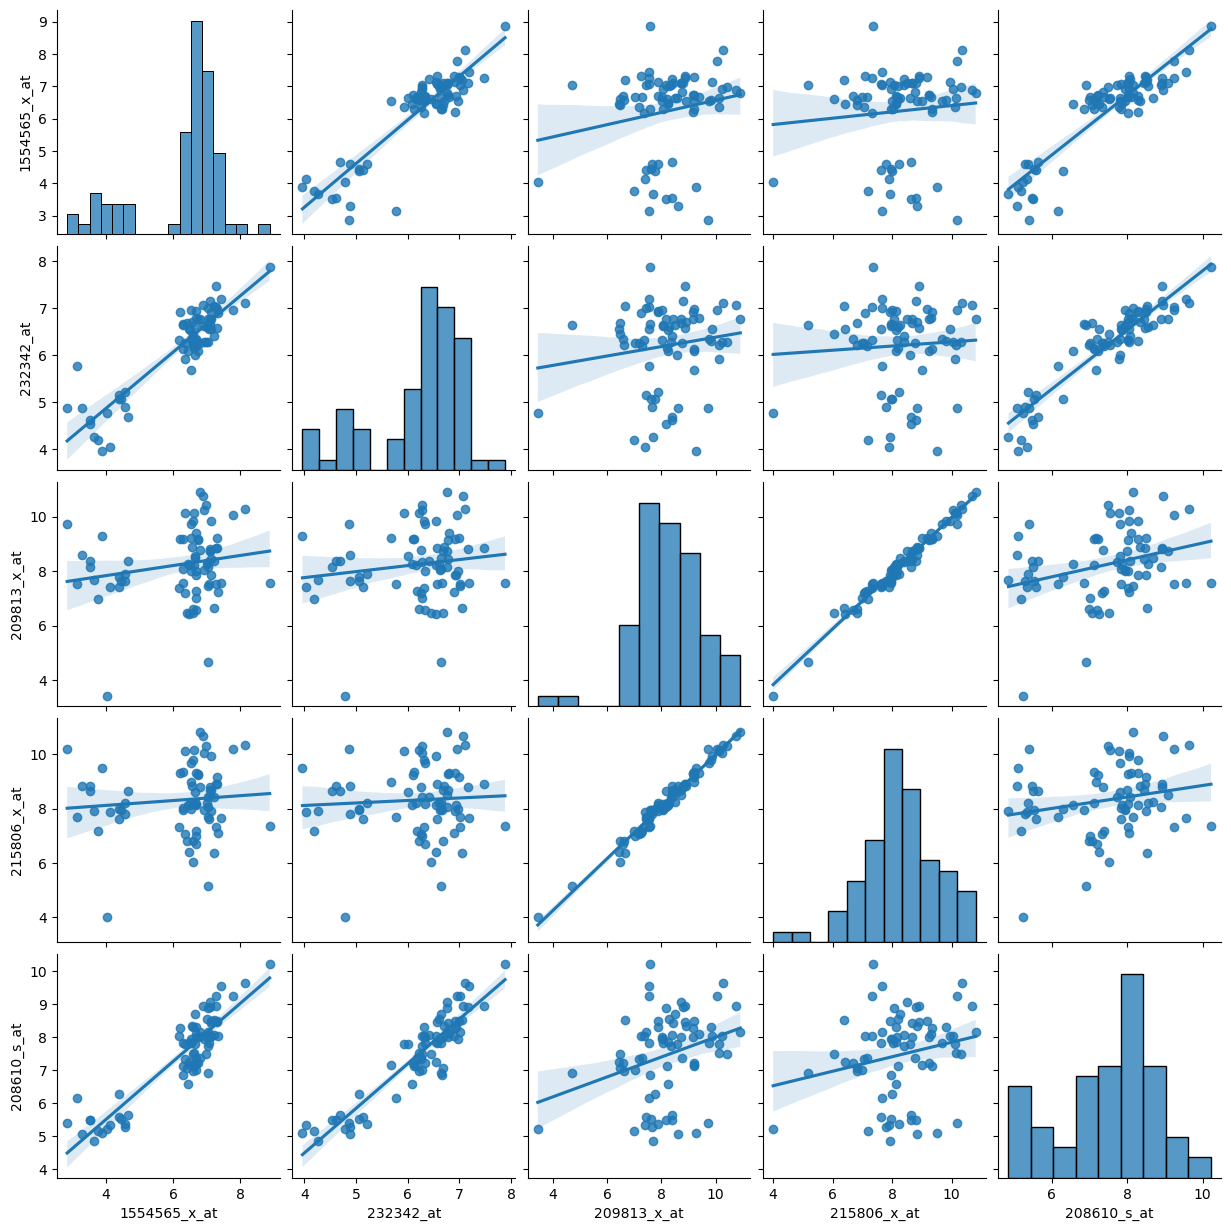

In [193]:
# sns.regplot(x='209813_x_at', y='215806_x_at', data=data[['209813_x_at','215806_x_at']])
# sns.regplot(x='1554565_x_at', y='232342_at', data=data[['1554565_x_at','232342_at']])
# sns.regplot(x='1554565_x_at', y='208610_s_at', data=data[['1554565_x_at','208610_s_at']])
sns.pairplot(data=data[['1554565_x_at','232342_at','209813_x_at','215806_x_at','208610_s_at']], kind='reg', corner=False)

In [188]:
aux_adata['GSE14346'].var.loc[['1554565_x_at','232342_at','209813_x_at','215806_x_at','208610_s_at'],:]

symbol status
1554565_x_at   SPPL3     ok
232342_at     MTMR14     ok
209813_x_at    TRGV9     ok
215806_x_at    TRGV9     ok
208610_s_at    SRRM2     ok

In [35]:
aux = [] 
for bio in biomarkers:
    aux.extend(bio.index.values.tolist())
    

In [82]:
hm = pd.concat(biomarkers, axis=1)

In [118]:
hm.fillna(0).to_csv(path+'genes_boruta.csv')

In [6]:
hm = pd.read_csv(path+'genes_boruta.csv')

In [7]:
hm

0  GSE14346  GSE15296  GSE46474  GSE129166  GSE120397
0      BEST1         1         0         0          0          0
1      CAMK4         5         0         0          0          0
2       CD28         5         0         0          0          0
3     DNAJC9         4         0         0          0          0
4    FAM117B         4         0         0          0          0
..       ...       ...       ...       ...        ...        ...
126     SPEN         0         0         0          0          4
127   STAT5A         0         0         0          0          3
128   TAGLN2         0         0         0          0          2
129    TBL1Y         0         0         0          0          5
130  TSPAN33         0         0         0          0          3

[131 rows x 6 columns]

In [86]:
hm_2 = (hm>3).astype(int)

In [98]:
hm_2.sum(axis=1)>0
hm_2[hm_2.sum(axis=1)>0].shape

(68, 5)

<Axes: xlabel='0'>

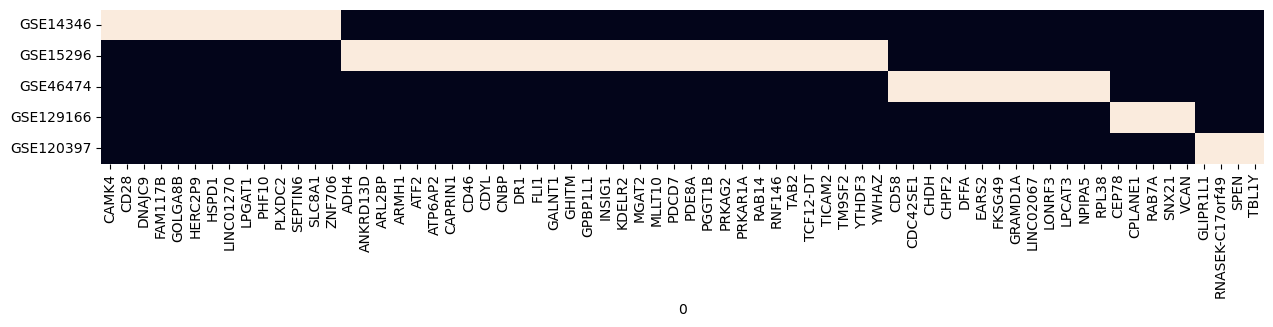

In [101]:
fig = plt.figure(figsize=(15,2))
sns.heatmap(hm_2[hm_2.sum(axis=1)>0].T, cbar=False)

In [113]:
hm_2[hm_2.sum(axis=1)>0].T

0          CAMK4  CD28  DNAJC9  FAM117B  GOLGA8B  HERC2P9  HSPD1  LINC01270  \
GSE14346       1     1       1        1        1        1      1          1   
GSE15296       0     0       0        0        0        0      0          0   
GSE46474       0     0       0        0        0        0      0          0   
GSE129166      0     0       0        0        0        0      0          0   
GSE120397      0     0       0        0        0        0      0          0   

0          LPGAT1  PHF10  ...  RPL38  CEP78  CPLANE1  RAB7A  SNX21  VCAN  \
GSE14346        1      1  ...      0      0        0      0      0     0   
GSE15296        0      0  ...      0      0        0      0      0     0   
GSE46474        0      0  ...      1      0        0      0      0     0   
GSE129166       0      0  ...      0      1        1      1      1     1   
GSE120397       0      0  ...      0      0        0      0      0     0   

0          GLIPR1L1  RNASEK-C17orf49  SPEN  TBL1Y  
GSE14346          0                0     0      0  
GSE15296          0                0     0      0  
GSE46474          0                0     0      0  
GSE129166         0                0     0      0  
GSE120397         1                1     1      1  

[5 rows x 68 columns]

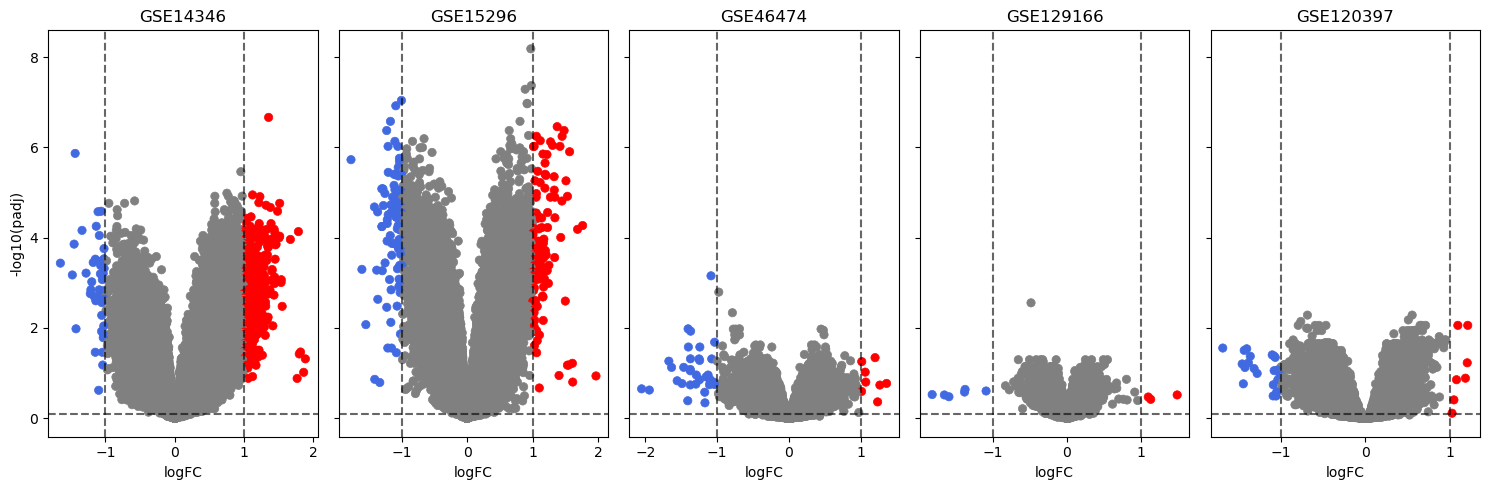

In [22]:
fig, ax = plt.subplots(ncols=5, figsize=(15,5), sharey=True)

files = ['GSE14346_deg.tsv','GSE15296_deg.tsv', 'GSE46474_deg.tsv', 'GSE129166_deg.tsv', 'GSE120397_deg.tsv']
titles = [f.split('_')[0] for f in files]
i=0
aux = []
for t,f in zip(titles,files):
    df = pd.read_csv(path+f, index_col=0, sep='\t')
    # df.index = df.index.map(ens2sym)
    pv_col='adj.P.Val'
    pv_lim=0.1
    logFC_lim=1.
    logFC_col='logFC'
    

    plot.volcanoplot(df, ax=ax[i], pv_col='adj.P.Val', pv_lim=0.1, logFC_lim=1., logFC_col='logFC', use_adjusttext=False)
    ax[i].set_title(t)
    ax[i].get_legend().remove()
    
    df.dropna(inplace=True)
    df['-log10(padj)'] = -np.log10(df[pv_col])
    df['log2FoldChange_abs'] = df[logFC_col].abs()
    condlist = [(df[logFC_col] >= logFC_lim) & (df['-log10(padj)'] >= pv_lim), (df[logFC_col] <= -logFC_lim) & (df['-log10(padj)'] >= pv_lim)]
    choicelist = ['Upregulated','Downregulated']

    df['regulation'] = np.select(condlist, choicelist, default='Not-significant')
    aux.append(df[df['regulation']!='Not-significant'].index.tolist())

    i+=1



fig.tight_layout()
# fig.savefig('volcanos.png')

In [37]:
import upsetplot
from upsetplot import query

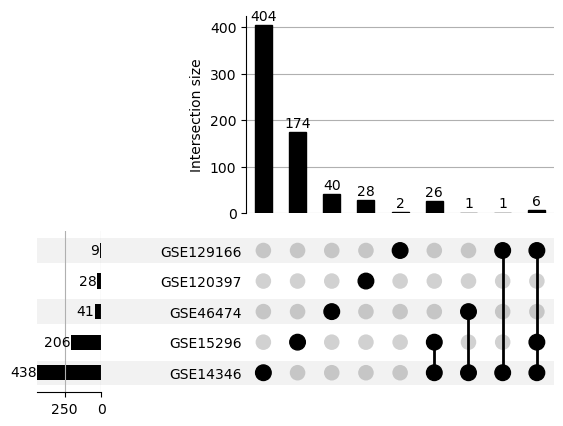

In [40]:
from upsetplot import from_contents
animals = from_contents({'GSE14346': aux[0], 'GSE15296': aux[1], 'GSE46474': aux[2], 'GSE129166':aux[3], 'GSE120397':aux[4]})
animals

from upsetplot import UpSet
ax_dict = UpSet(animals, subset_size='count', show_counts=True).plot()

In [41]:
animals

id
GSE14346 GSE15296 GSE46474 GSE129166 GSE120397              
True     False    False    False     False       210425_x_at
         True     False    False     False      1561615_s_at
         False    False    False     False         218696_at
                                     False         222108_at
                                     False         226039_at
...                                                      ...
False    False    False    False     True            3667858
                                     True            2343473
                                     True            2956563
                                     True            3206317
                                     True            4031136

[682 rows x 1 columns]

In [69]:
animals.reset_index().loc[:,:'GSE120397']

GSE14346  GSE15296  GSE46474  GSE129166  GSE120397
0        True     False     False      False      False
1        True      True     False      False      False
2        True     False     False      False      False
3        True     False     False      False      False
4        True     False     False      False      False
..        ...       ...       ...        ...        ...
677     False     False     False      False       True
678     False     False     False      False       True
679     False     False     False      False       True
680     False     False     False      False       True
681     False     False     False      False       True

[682 rows x 5 columns]

In [78]:
result = query(animals, present=['GSE14346','GSE15296',  'GSE129166'], absent=['GSE46474', 'GSE120397'])
# result.subsets[animals({"GSE14346", "GSE129166"})]

In [84]:
result

QueryResult(data=                                                         id
GSE14346 GSE15296 GSE46474 GSE120397 GSE129166             
True     True     False    False     True       214218_s_at
                                     True       221728_x_at
                                     True         224590_at
                                     True         224588_at
                                     True         227671_at
                                     True         201909_at, subset_sizes=GSE14346  GSE15296  GSE46474  GSE120397  GSE129166
True      True      False     False      True         6
Name: size, dtype: int64, category_totals=GSE14346     438
GSE15296     206
GSE46474      41
GSE120397     28
GSE129166      9
dtype: int64

In [57]:
result.subsets#[frozenset({'GSE14346','GSE129166'})]

{frozenset({'GSE14346',
            'GSE15296'}):                                                      id
 GSE14346 GSE15296 GSE46474 GSE120397 GSE129166         
 False    False    False    True      False      2940202
                                      False      2485406
                                      False      3628469
                                      False      3982410
                                      False      3386217
                                      False      2866543
                                      False      3603408
                                      False      3253445
                                      False      3109191
                                      False      3886765
                                      False      2738919
                                      False      3253444
                                      False      2738923
                                      False      3253443
                                      F

In [26]:
d = {'GSE14346': aux[0], 'GSE15296': aux[1], 'GSE46474': aux[2], 'GSE129166':aux[3], 'GSE120397':aux[4]}

In [32]:
# set(d['GSE14346']).intersection(set(d['GSE15296']))

In [31]:
set(d['GSE14346']).intersection(set(d['GSE46474']))

{'236495_at'}

In [35]:
# set(d['GSE14346']).intersection(set(d['GSE129166']))
set(d['GSE129166']).intersection(set(d['GSE14346']))

{'201909_at',
 '214218_s_at',
 '221728_x_at',
 '224588_at',
 '224589_at',
 '224590_at',
 '227671_at'}

In [34]:
set(d['GSE14346']).intersection(set(d['GSE15296'])).intersection(set(d['GSE129166']))

{'201909_at',
 '214218_s_at',
 '221728_x_at',
 '224588_at',
 '224590_at',
 '227671_at'}

# RNASeq

In [2]:
path='/data/input/postransplant_cristian_colab/PRJNA733336_data/countFiles/'

In [3]:
read.from_HTseq_counts(path)

NameError: name 'df_counts' is not defined

In [89]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5), sharey=True)

files = ['res_c7_pc.csv','res_c14_pc.csv', 'res_714_pc.csv']
titles = ['control vs 7d', 'control vs 14d', '7d vs 14d']
i=0
for t,f in zip(titles,files):
    df = pd.read_csv(path+f, index_col=0)
    df.index = df.index.map(ens2sym)

    plot.volcanoplot(df, ax=ax[i], use_adjusttext=True, pv_lim=0.05)
    ax[i].set_title(t)
    ax[i].get_legend().remove()

    i+=1



fig.tight_layout()

(68, 5)

In [5]:
adata = ad.AnnData( pd.read_csv(counts, sep='\t', index_col=0).T.apply(np.float32) )

/data/input/BioInfoEnv/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [13]:
adata.var.index# = adata.var.merge( pd.read_csv(var, sep='\t', index_col=0, header=None), right_index=True, left_index=True )

Index(['2315554', '2315633', '2315674', '2315739', '2315894', '2315918',
       '2315951', '2316218', '2316245', '2316379',
       ...
       '4133728', '4134740', '7385511', '7385515', '7385547', '7385552',
       '7385611', '7385641', '7385683', '7385696'],
      dtype='object', name='Genes', length=22011)

In [83]:
a = pd.read_csv(obs, sep='\t')#,index_col=0, header=None)
# a.columns = a.columns.str.split('_').str[0]
# a.to_csv(counts, sep='\t')

In [84]:
a

title geo_accession                 status  \
GSM3399847    P1 [validation]    GSM3399847  Public on Sep 11 2019   
GSM3399848   P12 [validation]    GSM3399848  Public on Sep 11 2019   
GSM3399849   P20 [validation]    GSM3399849  Public on Sep 11 2019   
GSM3399850   P22 [validation]    GSM3399850  Public on Sep 11 2019   
GSM3399851   P23 [validation]    GSM3399851  Public on Sep 11 2019   
...                       ...           ...                    ...   
GSM3399907  P182 [validation]    GSM3399907  Public on Sep 11 2019   
GSM3399908  P183 [validation]    GSM3399908  Public on Sep 11 2019   
GSM3399909  P184 [validation]    GSM3399909  Public on Sep 11 2019   
GSM3399910  P185 [validation]    GSM3399910  Public on Sep 11 2019   
GSM3399911  P186 [validation]    GSM3399911  Public on Sep 11 2019   

           submission_date last_update_date type  channel_count  \
GSM3399847     Sep 24 2018      Sep 11 2019  RNA              1   
GSM3399848     Sep 24 2018      Sep 11 2019  RNA              1   
GSM3399849     Sep 24 2018      Sep 11 2019  RNA              1   
GSM3399850     Sep 24 2018      Sep 11 2019  RNA              1   
GSM3399851     Sep 24 2018      Sep 11 2019  RNA              1   
...                    ...              ...  ...            ...   
GSM3399907     Sep 24 2018      Sep 11 2019  RNA              1   
GSM3399908     Sep 24 2018      Sep 11 2019  RNA              1   
GSM3399909     Sep 24 2018      Sep 11 2019  RNA              1   
GSM3399910     Sep 24 2018      Sep 11 2019  RNA              1   
GSM3399911     Sep 24 2018      Sep 11 2019  RNA              1   

           source_name_ch1  organism_ch1  characteristics_ch1  ...  \
GSM3399847     whole blood  Homo sapiens  tissue: Whole blood  ...   
GSM3399848     whole blood  Homo sapiens  tissue: Whole blood  ...   
GSM3399849     whole blood  Homo sapiens  tissue: Whole blood  ...   
GSM3399850     whole blood  Homo sapiens  tissue: Whole blood  ...   
GSM3399851     whole blood  Homo sapiens  tissue: Whole blood  ...   
...                    ...           ...                  ...  ...   
GSM3399907     whole blood  Homo sapiens  tissue: Whole blood  ...   
GSM3399908     whole blood  Homo sapiens  tissue: Whole blood  ...   
GSM3399909     whole blood  Homo sapiens  tissue: Whole blood  ...   
GSM3399910     whole blood  Homo sapiens  tissue: Whole blood  ...   
GSM3399911     whole blood  Homo sapiens  tissue: Whole blood  ...   

                                  contact_institute       contact_address  \
GSM3399847  Icahn School of Medicine at Mount Sinai  1 Gustave L. Levy Pl   
GSM3399848  Icahn School of Medicine at Mount Sinai  1 Gustave L. Levy Pl   
GSM3399849  Icahn School of Medicine at Mount Sinai  1 Gustave L. Levy Pl   
GSM3399850  Icahn School of Medicine at Mount Sinai  1 Gustave L. Levy Pl   
GSM3399851  Icahn School of Medicine at Mount Sinai  1 Gustave L. Levy Pl   
...                                             ...                   ...   
GSM3399907  Icahn School of Medicine at Mount Sinai  1 Gustave L. Levy Pl   
GSM3399908  Icahn School of Medicine at Mount Sinai  1 Gustave L. Levy Pl   
GSM3399909  Icahn School of Medicine at Mount Sinai  1 Gustave L. Levy Pl   
GSM3399910  Icahn School of Medicine at Mount Sinai  1 Gustave L. Levy Pl   
GSM3399911  Icahn School of Medicine at Mount Sinai  1 Gustave L. Levy Pl   

           contact_city contact_state contact_zip/postal_code contact_country  \
GSM3399847     New York            NY                   10029             USA   
GSM3399848     New York            NY                   10029             USA   
GSM3399849     New York            NY                   10029             USA   
GSM3399850     New York            NY                   10029             USA   
GSM3399851     New York            NY                   10029             USA   
...                 ...           ...                     ...             ...   
GSM3399907     New York            NY        

In [81]:
a

1   2
0                     
2315554     TTLL10  ok
2315633    B3GALT6  ok
2315674  LINC01786  ok
2315739      PUSL1  ok
2315894       VWA1  ok
...            ...  ..
7385552       SHPK  ok
7385611     HPCAL1  ok
7385641     CLSTN2  ok
7385683      VPS41  ok
7385696       SEM1  ok

[22011 rows x 2 columns]

In [76]:
a

GSM3399847  GSM3399848  GSM3399849  GSM3399850  GSM3399851  \
Genes                                                                 
2315554    6.259506    6.306225    6.677108    6.373559    6.716029   
2315633    6.480756    6.549678    6.728587    6.625910    6.809694   
2315674    6.126091    6.187958    6.837038    6.209914    6.525656   
2315739    6.090189    6.074688    6.493151    6.249575    6.486124   
2315894    7.970310    8.044867    8.344918    8.015976    8.102380   
...             ...         ...         ...         ...         ...   
7385552    5.746004    6.222020    5.808732    5.944420    5.647373   
7385611    6.632256    6.652439    7.203729    6.416174    6.830198   
7385641    5.117439    5.153778    5.595623    5.173394    5.519959   
7385683    7.443064    7.430486    7.208959    7.658259    7.059127   
7385696    9.777913   10.194365    8.664026   10.407223    9.634860   

         GSM3399852  GSM3399853  GSM3399854  GSM3399855  GSM3399856  ...  \
Genes                                                                ...   
2315554    6.263129    6.279948    5.954925    6.844437    6.194500  ...   
2315633    6.517469    6.677517    6.308607    6.659990    6.595970  ...   
2315674    6.123535    6.421003    6.084998    6.714451    6.128960  ...   
2315739    6.123262    6.007985    5.943313    6.435330    6.200282  ...   
2315894    7.804890    8.159920    8.394689    8.269981    7.852147  ...   
...             ...         ...         ...         ...         ...  ...   
7385552    5.560225    5.358159    6.401013    5.783241    5.140527  ...   
7385611    6.653676    6.470060    6.495146    7.203485    6.446615  ...   
7385641    5.052837    5.209975    5.047053    5.695247    4.918710  ...   
7385683    7.592207    7.504028    7.376842    6.623829    7.407611  ...   
7385696   10.204442   10.631367   10.416794    9.419224   10.094493  ...   

         GSM3399902  GSM3399903  GSM3399904  GSM3399905  GSM3399906  \
Genes                                                                 
2315554    6.310251    6.003178    6.057073    6.118321    7.205511   
2315633    6.240721    6.551866    6.341898    6.220923    7.154597   
2315674    6.169348    5.997777    6.039961    6.070670    7.405922   
2315739    6.084385    6.034297    6.030243    5.781631    6.915077   
2315894    7.863739    8.007476    8.005257    7.737665    8.768492   
...             ...         ...         ...         ...         ...   
7385552    5.219930    4.790188    5.795180    6.417016    6.563974   
7385611    6.305492    6.327339    6.172332    6.224885    7.872260   
7385641    5.023216    4.816077    4.846434    4.872728    6.321744   
7385683    7.683985    7.247435    7.769634    7.592421    5.562484   
7385696   11.004938   11.554465   11.737473   11.090084    8.879749   

         GSM3399907  GSM3399908  GSM3399909  GSM3399910  GSM3399911  
Genes                                                                
2315554    6.201769    6.201655    6.462864    6.367792    6.180843  
2315633    6.378257    6.422028    6.445017    6.584148    6.292057  
2315674    6.355639    6.120117    6.372151    6.225634    6.265612  
2315739    6.170274    6.144350    6.526154    6.236483    6.178054  
2315894    7.850335    7.643271    8.217500    8.146555    7.989528  
...             ...         ...         ...         ...         ...  
7385552    6.265159    5.082846    5.914981    5.646722    5.617404  
7385611    6.529467    6.415042    6.826910    6.517337    6.637374  
7385641    5.197899    5.348949    5.170954    5.054225    5.232416  
7385683    7.026824    7.460077    7.029651    7.423853    7.837653  
7385696    9.716305   11.404970   10.621320    9.907921    9.651577  

[22011 rows x 65 columns]

In [50]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=500, class_weight='balanced', max_depth=20, criterion="gini")

In [51]:
genes = gene_selection.set_boruta_selection(adata[:,adata.var['status']=='ok'], rf, class_col='ar', random_state=42, sample_size=25)

In [52]:
aux = []
for g in genes:
    aux.extend(g['genes'])
    print(len(g['genes']))

9
8
8
8
9


In [56]:
pd.DataFrame(np.unique(np.array(aux), return_counts=True)).T.set_index(0)

1
0            
ASAP1       1
C19orf18    1
CD84        2
CEP78       5
CPLANE1     5
CRYL1       1
EIF3M       1
FZD3        2
ISY1-RAB43  1
LILRA4      1
LINC01503   1
MSN         1
PTTG3P      2
RAB7A       4
SNX21       5
TNFRSF10D   1
USO1        1
VCAN        5
ZNRF1       2

In [53]:
np.unique(np.array(aux), return_counts=True)

(array(['ASAP1', 'C19orf18', 'CD84', 'CEP78', 'CPLANE1', 'CRYL1', 'EIF3M',
        'FZD3', 'ISY1-RAB43', 'LILRA4', 'LINC01503', 'MSN', 'PTTG3P',
        'RAB7A', 'SNX21', 'TNFRSF10D', 'USO1', 'VCAN', 'ZNRF1'],
       dtype='<U10'),
 array([1, 1, 2, 5, 5, 1, 1, 2, 1, 1, 1, 1, 2, 4, 5, 1, 1, 5, 2]))

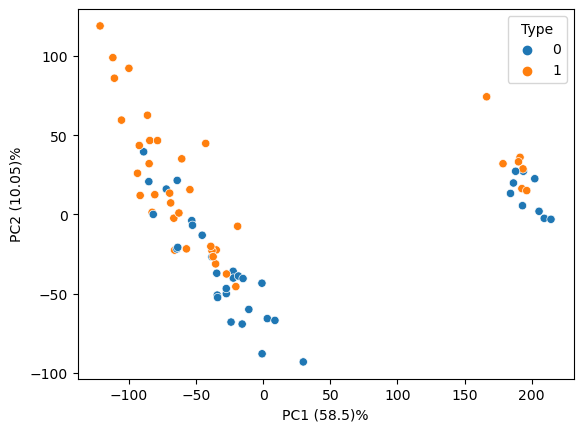

In [9]:
plot.pca(adata[:,adata.var[2]=='ok'], 'ar', hue=True)

In [21]:
from sklearn.model_selection import GroupKFold

X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12]])
y = np.array([1, 1, 1, 0, 0, 0])
groups = np.array([0, 0, 2, 2, 3, 3])
group_kfold = GroupKFold(n_splits=3)
group_kfold.get_n_splits(X, y, groups)

print(group_kfold)
for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}, group={groups[train_index]}")
    print(f"  Test:  index={test_index}, group={groups[test_index]}")

GroupKFold(n_splits=3)
Fold 0:
  Train: index=[0 1 2 3], group=[0 0 2 2]
  Test:  index=[4 5], group=[3 3]
Fold 1:
  Train: index=[0 1 4 5], group=[0 0 3 3]
  Test:  index=[2 3], group=[2 2]
Fold 2:
  Train: index=[2 3 4 5], group=[2 2 3 3]
  Test:  index=[0 1], group=[0 0]


In [8]:
adata[:,adata.var[2]=='ok'].X

ArrayView([[5.3311434, 5.6659303, 8.935043 , ..., 4.4211082, 5.9078493,
            4.9463625],
           [4.0439644, 5.9036784, 9.082359 , ..., 3.3183072, 4.3143806,
            4.2777863],
           [5.7545476, 5.483194 , 8.305562 , ..., 4.687125 , 6.5056524,
            5.626111 ],
           ...,
           [5.512342 , 5.5420556, 8.037399 , ..., 4.271015 , 6.0373564,
            5.6129365],
           [3.6218402, 5.961894 , 8.259135 , ..., 3.7023675, 4.100367 ,
            5.3610992],
           [4.5271206, 5.918036 , 5.595948 , ..., 3.4589264, 4.7701263,
            6.606148 ]], dtype=float32)

In [6]:
# model = RandomForestClassifier(random_state=42)
# scaler = StandardScaler()

# r = gene_selection.boruta_selection(adata[:,adata.var[2]=='ok'], model, class_col='ar', scaler=None)

In [8]:
tpm = correction.TPM(gl)

In [9]:
tpm.transform(a)

array([[333333.33333333, 333333.33333333, 333333.33333333,
             0.        ],
       [296296.2962963 , 308641.97530864, 395061.72839506,
             0.        ],
       [332594.23503326, 332594.23503326, 332594.23503326,
          2217.29490022]])

In [ ]:
t1 = time.time()
for gse in ['GSE46474']:#['GSE15296','GSE129166','GSE120397']: #'GSE14346'
    #['GSE14346','GSE14356-GPL1708','GSE14356-GPL8040','GSE14357-GPL8041','GSE14357-GPL8042']:#['GSE15296','GSE129166','GSE120397']:
    print(gse, end=': ')
    # with open('/data/input/postransplant_cristian_colab/'+gse+'/'+gse+'_mygene_translation.csv', 'w') as in_file:
    with open('/data/input/postransplant_cristian_colab/microarrays/'+gse+'_mygene_translation.csv', 'w') as in_file:
        # Import microarray data
        # df_GSE_expr = pd.read_csv('/data/input/postransplant_cristian_colab/'+gse+'/'+gse+'_expr.tsv', sep='\t', index_col=0).index
        df_GSE_expr = pd.read_csv('/data/input/postransplant_cristian_colab/microarrays/GSE46474_norm_exprs.tsv', sep='\t', index_col=0).index
        # Translate affy to gene symbol
        aux = ''
        for r in df_GSE_expr:
            try:
                aux = mg.query('reporter:'+str(r))
                if aux['hits']:
                    in_file.write(str(r)+','+str(aux['hits'][0]['symbol'])+',ok\n')
                else:
                    in_file.write(str(r)+','+str(r)+',empty\n')
            except:
                in_file.write(str(r)+','+str(r)+',exception\n')
    print(time.time()-t1,'s')

In [15]:
import os
import pandas as pd
import anndata as ad
import numpy as np

In [45]:
from multiprocessing import Pool
import itertools
import os
import time
import numpy as np
import pandas as pd
import anndata as ad
from gotx import *#as gt



path='/mnt/d/postransplant_cristian_colab/microarrays/'

fig = plt.figure(figsize=(20,10))
rows = 4
cols = 5

gse_list = ['GSE15296']#, 'GSE46474', 'GSE129166', 'GSE120397']#'GSE14346',

times = dict()
biomarkers = []
aux_adata = dict()

exclude_outliers = False

for gse in gse_list:
    print(gse)

# gse = gse_list[3]
    counts = os.path.join(path,gse+'_norm_exprs.tsv')
    obs = os.path.join(path,gse+'_meta.tsv')
    var = os.path.join(path,gse+'_mygene_translation.tsv')

    adata = read.from_oligo(counts, obs=obs, var=var)
    if gse == 'GSE14346':
        adata.obs['ar'] = np.where(adata.obs['disease state:ch1'].str.startswith('AR'), 1, 0)#'GSE14346'
    elif gse == 'GSE15296':
        adata.obs['ar'] = np.where(adata.obs['phenotype:ch1'].str.contains('Acute Kidney Rejection'), 1, 0)#'GSE15296'
    elif gse == 'GSE46474':
        adata.obs['ar'] = np.where(adata.obs['source_name_ch1'].str.contains('(AR)'), 1, 0)#'GSE46474'
    elif gse == 'GSE129166':
        adata.obs['ar'] = np.where(( adata.obs['characteristics_ch1.1'].str.endswith('1') | adata.obs['characteristics_ch1.2'].str.endswith('1')), 1, 0)#'GSE129166'
    elif gse == 'GSE120397':
        adata.obs['ar'] = np.where(adata.obs['characteristics_ch1.1'].str.endswith('Yes'), 1, 0)#'GSE46474'

    adata.var.columns = ['symbol', 'status']
    adata.layers['zscore'] = zscore(adata.X)
    # adata.var = adata.var.reset_index().set_index('symbol')
    aux_adata[gse] = adata


# def parallel_r(gse):
#     with open('/mnt/d/GoTx_Folder/tests/'+gse+'_r_pv_high_corr_p.csv', 'w') as file:
#         file.write('gene_1,gene_2,statistic,pvalue\n')

#     gene_comb = itertools.combinations(aux_adata[gse].var[aux_adata[gse].var['status']=='ok'].index, 2)
#     r_09_list = []
#     for xy in gene_comb:
#         x = aux_adata[gse][:,(aux_adata[gse].var['status']=='ok') & (aux_adata[gse].var.index==xy[0])].X.reshape(1,-1)[0]
#         y = aux_adata[gse][:,(aux_adata[gse].var['status']=='ok') & (aux_adata[gse].var.index==xy[1])].X.reshape(1,-1)[0]

#         statistic, pvalue = pearsonr(x,y)

#         if (pvalue <= .05) and (statistic >= .9):
#             with open('/mnt/d/GoTx_Folder/tests/'+gse+'_r_pv_high_corr_p.csv', 'a') as file:
#                 file.write(str(xy[0])+','+str(xy[1])+','+str(statistic)+','+str(pvalue)+'\n')

# if __name__ == '__main__':
#     with Pool(processes=4) as p:
#         p.map(parallel_r, gse_list)

# p = Pool(processes=4)
# p.map(parallel_r, gse_list[1:])
# p.close()


GSE15296


<Figure size 2000x1000 with 0 Axes>

In [324]:
end = adata.layers['zscore'].shape[1]

In [325]:
list(range(end))[-1]

54674

In [326]:
adata.layers['zscore'][:,list(range(end))[-1]]

array([-0.05525893, -0.6881384 , -0.8835269 ,  0.25115332, -0.6193322 ,
        0.90677613, -0.8098422 , -0.77056986, -1.1079128 , -0.65611345,
       -0.94267553,  0.19210257,  0.80414   ,  0.11008228,  0.7092464 ,
        0.8152832 , -0.25718877, -0.98580855, -0.16847585,  0.4886845 ,
       -0.16926143,  1.6888835 ,  1.9728245 ,  2.353056  , -0.29724982,
       -0.11133552, -0.05913787, -0.71164745, -0.16885334, -1.4788977 ,
        0.1623426 ,  2.9245906 ,  0.07931512, -1.661034  ,  0.8403924 ,
        3.256818  , -0.26072842, -0.09862273, -0.47780418, -1.2967355 ,
        1.3423522 , -1.4113998 ,  0.07076096,  0.9658086 ,  1.7271748 ,
       -0.23901367, -0.5899039 , -0.18904893,  0.50404745, -0.49166018,
        0.2967317 , -0.536641  , -0.43691632, -1.1126446 ,  1.4414059 ,
        0.04425941,  0.19709416,  0.9204319 , -0.24693203, -0.6697753 ,
       -1.060988  , -0.7721624 , -1.4728134 ,  0.38491276, -0.6842029 ,
       -1.6735595 , -0.6898578 , -0.24508579,  1.5339152 ,  0.39

In [304]:
from scipy.stats import zscore
from scipy.stats import pearsonr
import time

end = 10
def parallel_r(i):
    pv = []
    r = []
    x = adata.layers['zscore'][:,i]
    # end = 5#adata.layers['zscore'].shape[1]
    for j in range(i+1, end):
        y = adata.layers['zscore'][:,j]        
        statistic, pvalue = pearsonr(x,y)      
        r.append(statistic)
        pv.append0(pvalue)
    with open('/mnt/d/postransplant_cristian_colab/microarrays/correlations/'+gse+'_'+str(i)+'_'+str(j)+'_r.np', 'wb') as f:
        np.save(f, np.array(r))
    with open('/mnt/d/postransplant_cristian_colab/microarrays/correlations/'+gse+'_'+str(i)+'_'+str(j)+'_p.np', 'wb') as f:
        np.save(f, np.array(pv))    

t1 = time.time()
if __name__ == '__main__':
    with Pool(processes=10) as p:
        # p.map(parallel_r, range(50000, adata.layers['zscore'].shape[1]) )
        p.map(parallel_r, range(end-1))
tf = time.time() - t1
print(tf,'(s)', tf/60, '(min)')

0.09454631805419922 (s) 0.001575771967569987 (min)


In [243]:
np.concatenate(m)

array([-0.00138829, -0.04291718,  0.45201921, ...,  0.12448418,
        0.1689071 , -0.0162814 ])

In [239]:
squareform(np.concatenate(m)).shape

(100, 100)

array([[ 0.        , -0.00138829, -0.04291718,  0.45201921,  0.23953379],
       [-0.00138829,  0.        ,  0.28251168,  0.03838287,  0.13148745],
       [-0.04291718,  0.28251168,  0.        ,  0.25622655,  0.03469614],
       [ 0.45201921,  0.03838287,  0.25622655,  0.        ,  0.30460948],
       [ 0.23953379,  0.13148745,  0.03469614,  0.30460948,  0.        ]])

In [148]:
from scipy.spatial.distance import squareform, pdist

In [146]:
x = np.array([[2, 0, 2], [2, 2, 3], [-2, 4, 5], [0, 1, 9], [2, 2, 4]])

In [151]:
pdist(x)

array([2.23606798, 6.40312424, 7.34846923, 2.82842712, 4.89897949,
       6.40312424, 1.        , 5.38516481, 4.58257569, 5.47722558])

In [181]:
squareform(pdist(x))

array([[0.        , 2.23606798, 6.40312424, 7.34846923, 2.82842712],
       [2.23606798, 0.        , 4.89897949, 6.40312424, 1.        ],
       [6.40312424, 4.89897949, 0.        , 5.38516481, 4.58257569],
       [7.34846923, 6.40312424, 5.38516481, 0.        , 5.47722558],
       [2.82842712, 1.        , 4.58257569, 5.47722558, 0.        ]])

In [ ]:
[[1.0, -0.0013882936576370374, -0.04291718466631177, 0.452019205647878, 0.23953379266866642], [1.0, 0.282511682661227, 0.03838287412510569, 0.13148744898653578], 
 [1.0, 0.2562265453820154, 0.03469614281363842], [1.0, 0.3046094845955733], [1.0], [], [], [], [], []]

In [308]:
with open('/mnt/d/postransplant_cristian_colab/microarrays/correlations/GSE14346_r_concatenated.np', 'rb') as f:
    a = np.load(f)
a

array([-0.63742496,  0.02992176,  0.88455387,  0.45859485, -0.49635896,
        0.21156492,  0.35583001,  0.48431452,  0.26826496,  0.06636676,
       -0.69730896, -0.37294739,  0.38916639, -0.21079786, -0.45364365,
       -0.3009318 , -0.29644762,  0.14108381,  0.16670823, -0.02007529,
       -0.01508381,  0.0049477 , -0.04740789,  0.00345816,  0.49463418,
       -0.67356152,  0.18879723,  0.52638317,  0.43334153,  0.24376417,
       -0.41276616,  0.24947507,  0.21790661, -0.07128659,  0.22226457,
       -0.09608162, -0.46261438, -0.03381624, -0.1651224 ,  0.22316609,
        0.08925374, -0.06294643,  0.05471086,  0.24383111,  0.04415427])

In [306]:
with open('/mnt/d/postransplant_cristian_colab/microarrays/correlations/GSE14346_p_concatenated.np', 'rb') as f:
    a = np.load(f)
a

array([7.78364496e-10, 7.98850707e-01, 6.95713295e-26, 3.50726832e-05,
       5.92917730e-06, 6.84371430e-02, 1.73003892e-03, 1.06951554e-05,
       1.99625193e-02, 5.71581560e-01, 3.64923017e-12, 9.83084344e-04,
       5.58978301e-04, 6.94688587e-02, 4.36111080e-05, 8.70345702e-03,
       9.80808113e-03, 2.27297456e-01, 1.52857218e-01, 8.64259736e-01,
       8.97798521e-01, 9.66395970e-01, 6.86289362e-01, 9.76509227e-01,
       6.46069101e-06, 3.55111264e-11, 1.04761583e-01, 1.23110624e-06,
       1.02970827e-04, 3.50737064e-02, 2.33095813e-04, 3.08902374e-02,
       6.03720028e-02, 5.43343484e-01, 5.52905944e-02, 4.12207514e-01,
       2.93134055e-05, 7.73330823e-01, 1.56856806e-01, 5.42842743e-02,
       4.46359007e-01, 5.91607095e-01, 6.41071403e-01, 3.50220561e-02,
       7.06806741e-01])

In [328]:
aux = np.array([])
path = '/mnt/d/postransplant_cristian_colab/microarrays/correlations/'
for f in [i for i in os.listdir(path) if (i.endswith('_r.np')) and (i.startswith('GSE14346'))]:
    with open(path+f, 'rb') as f:
        aux = np.concatenate([aux,np.load(f)])

In [329]:
aux

array([ 0.59289187,  0.0346503 ,  0.48808849,  0.3024048 , -0.02227728,
        0.43953287,  0.1075083 ,  0.02624651,  0.24568523,  0.18900712])

In [330]:
squareform(aux)

array([[ 0.        ,  0.59289187,  0.0346503 ,  0.48808849,  0.3024048 ],
       [ 0.59289187,  0.        , -0.02227728,  0.43953287,  0.1075083 ],
       [ 0.0346503 , -0.02227728,  0.        ,  0.02624651,  0.24568523],
       [ 0.48808849,  0.43953287,  0.02624651,  0.        ,  0.18900712],
       [ 0.3024048 ,  0.1075083 ,  0.24568523,  0.18900712,  0.        ]])

In [277]:
a

array([-0.00138829, -0.04291718,  0.45201921,  0.23953379, -0.1406617 ,
        0.19209361,  0.04043827, -0.18258969,  0.37544226])

In [280]:
aux = np.concatenate([a,b])

In [283]:
aux = np.concatenate([aux,c])

In [286]:
aux

array([], dtype=float64)

In [30]:
zscore(adata.X[:,0])

array([-0.3603533 , -1.4186375 ,  1.6386906 ,  1.8742218 ,  2.022186  ,
        0.07585323,  1.3467823 ,  0.36001128,  0.61533135,  0.93963283,
       -0.26686412, -1.0725347 , -1.6675359 ,  1.6181415 , -0.37208188,
        1.2292874 ,  1.6719179 ,  0.8865724 ,  0.54795164,  0.36344597,
        1.320764  , -0.5030031 , -0.9047201 ,  1.7255441 , -0.0640779 ,
        1.4215678 , -1.5032644 , -0.36678222, -1.1653644 , -0.7977088 ,
       -1.7574084 ,  0.24846792,  1.0704557 ,  0.96545196,  0.31814808,
        0.3943802 ,  0.34941447,  0.3134537 , -1.218752  , -1.5809358 ,
       -1.9048634 , -0.06791116, -0.23019229,  0.60117435,  0.35582864,
       -1.230333  , -1.4846221 , -0.93304884, -0.39098242,  0.4946846 ,
       -1.7761072 ,  0.08126605,  0.58571583, -0.465635  , -1.1406131 ,
       -0.3308313 , -0.1268272 , -1.8152566 ,  0.16908897, -0.0632143 ,
        0.05718886,  0.06112791,  0.22317778,  0.4410608 , -0.726513  ,
        0.21006645,  0.17605922, -0.16799165,  0.5590577 , -0.22

In [40]:
zscore(adata.X[:,20])

array([-0.62826824,  0.09491541,  0.9912368 , -0.05751789, -1.4217834 ,
        1.0457832 , -0.55386174,  0.59858954,  0.04877407, -1.1246855 ,
        0.03828299, -2.1545298 ,  0.17241918,  0.55822307, -1.2240009 ,
        0.12113316, -0.02608698, -0.5062521 , -0.5744952 ,  0.10188581,
        1.8173897 , -0.53014594,  1.2743466 , -0.11552148, -0.05751789,
        1.2976215 , -0.45915553, -0.5062521 , -1.1195247 , -0.74449706,
        0.665327  ,  1.4773548 , -0.28472632, -0.56905663,  0.02738218,
        3.3934011 , -0.884905  , -0.70036954, -0.6276978 , -0.448444  ,
       -0.39336956,  0.2036695 , -0.99303013, -0.52005213, -0.9729359 ,
       -0.9273002 , -0.29050115,  0.46473235,  1.4756747 , -0.25148338,
       -0.19931565, -0.05751789, -0.05751789, -0.42562616,  1.823248  ,
       -0.37702894,  0.30439088, -0.9349954 ,  4.339428  , -0.29050115,
       -0.74117315,  0.84669423, -0.75631326,  0.23688255,  0.98369604,
        0.17196211,  0.6931065 , -0.42679185,  0.17059842, -0.83

In [26]:
adata.X.shape[1]

54675

In [42]:
zscore(adata.X)[:,20]-zscore(adata.X[:,20])

array([-1.1920929e-06, -1.2516975e-06, -1.3113022e-06, -1.2405217e-06,
       -1.1920929e-06, -1.3113022e-06, -1.1920929e-06, -1.2516975e-06,
       -1.2479722e-06, -1.1920929e-06, -1.2479722e-06, -9.5367432e-07,
       -1.2665987e-06, -1.3113022e-06, -1.0728836e-06, -1.2591481e-06,
       -1.2423843e-06, -1.1920929e-06, -1.1920929e-06, -1.2516975e-06,
       -1.4305115e-06, -1.1920929e-06, -1.3113022e-06, -1.2367964e-06,
       -1.2405217e-06, -1.3113022e-06, -1.2218952e-06, -1.1920929e-06,
       -1.0728836e-06, -1.1920929e-06, -1.3113022e-06, -1.3113022e-06,
       -1.2218952e-06, -1.1920929e-06, -1.2461096e-06, -1.6689301e-06,
       -1.1920929e-06, -1.1920929e-06, -1.1920929e-06, -1.2218952e-06,
       -1.2218952e-06, -1.2665987e-06, -1.1920929e-06, -1.1920929e-06,
       -1.1920929e-06, -1.1920929e-06, -1.2218952e-06, -1.2814999e-06,
       -1.3113022e-06, -1.2218952e-06, -1.2218952e-06, -1.2405217e-06,
       -1.2405217e-06, -1.2218952e-06, -1.4305115e-06, -1.1920929e-06,
      

In [44]:
adata.layers['zscore']

array([[-0.36035082, -1.0550852 , -0.88216347, ..., -0.33574462,
        -0.6498859 , -0.05525893],
       [-1.418635  , -1.3379904 , -0.64601064, ..., -1.3046169 ,
         0.06306642, -0.6881384 ],
       [ 1.638693  , -0.2830847 ,  0.48888507, ...,  1.2925391 ,
         0.49576208, -0.8835269 ],
       ...,
       [-1.3008718 ,  0.8869115 ,  0.6163443 , ...,  1.2107071 ,
         0.17377417,  0.2586499 ],
       [ 0.592381  , -0.24233377, -0.3591303 , ..., -0.42349735,
         0.6215731 , -0.87869126],
       [ 1.709564  ,  1.0974116 , -0.836444  , ..., -0.9641458 ,
         1.031009  ,  0.27874917]], dtype=float32)